## Setup

In [ ]:
#connect to google drive
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'datathon'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
sys.path.append(GOOGLE_DRIVE_PATH)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['data', 'U of I IVR code data dictionary(updated).xlsx', 'reasons.txt', 'reasons.gdoc', '无标题电子表格.gsheet', 'Notes.gdoc', 'UIUC Datathon 2024 - Synchrony.pptx', 'Black and Yellow Modern Business Presentation.pptx', 'data_cleaning_Yuhong.ipynb']


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

In [ ]:
df1 = pd.read_csv(GOOGLE_DRIVE_PATH + "/data/file_3_Mar18_Output_1.csv")
df2 = pd.read_csv(GOOGLE_DRIVE_PATH + "/data/file_4_Mar18_Output_1.csv")
df = pd.concat([df1, df2], ignore_index=True)

## Exploratory Analysis

In [ ]:
df.head()

timestamp_call_key retailer_code       serial reason  \
0  240315173250 DAL1OA3M             D  10010009499     PP   
1  240315124742 DAL15XHK             E  10006021998     BA   
2  240317114237 DAL3BLK6             J  10016007830     PT   
3  240314120849 PHX6PL4U             E  10008003199     BA   
4  240314145902 DAL68RYS             I  10013002037     BA   

                    mos  resolved  no_of_accounts_with_syf_13_march  \
0              IA PP TR  resolved                               1.0   
1        IA BA TS nl TR     floor                               2.0   
2  IA AA BA MR nl PT TR  resolved                              12.0   
3                 IA BA  resolved                               2.0   
4     IA BA TS nl mm TR     floor                               6.0   

   account_balance_13_march delinquency_history_13_march  \
0                       NaN                         [00]   
1                    143.28                         [00]   
2                      0.00                         [00]   
3                     44.98                         [00]   
4                      7.00                         [00]   

  account_open_date_13_march  ... auto_pay_enrolled_status_13_march  \
0                  5/19/2013  ...                                 0   
1                  9/22/2003  ...                                 0   
2                   9/4/2017  ...                                 0   
3                   2/7/2024  ...                                 0   
4                   1/2/2022  ...                                 0   

  no_of_accounts_with_syf_18_march  account_balance_18_march  \
0                              1.0                       NaN   
1                              2.0                    143.28   
2                             12.0                      0.00   
3                              2.0                     -6.32   
4                              6.0                      7.00   

  delinquency_history_18_march  account_open_date_18_march  \
0                         [00]                   5/19/2013   
1                         [00]                   9/22/2003   
2                         [00]                    9/4/2017   
3                         [00]                    2/7/2024   
4                         [00]                    1/2/2022   

   account_status_18_march  card_activation_status_18_march  \
0                      NaN                                0   
1                      NaN                                0   
2                      NaN                                8   
3                      NaN                                0   
4                      NaN                                0   

  eservice_ind_18_march ebill_enrolled_status_18_march  \
0                     1                              E   
1                     1                              E   
2                     0                                  
3                     0                              L   
4                     1                                  

  auto_pay_enrolled_status_18_march  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0  

[5 rows x 24 columns]

In [ ]:
#parse timestamp call key
df['date'] = df['timestamp_call_key'].str[:6]
df['time'] = df['timestamp_call_key'].str[6:12]
df['call'] = df['timestamp_call_key'].str[13:21]
df['key'] = df['timestamp_call_key'].str[21:]

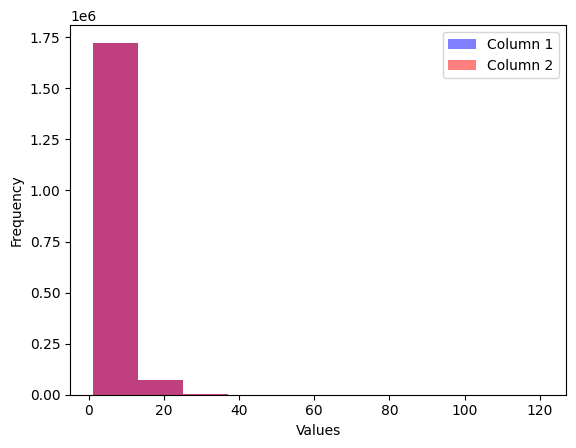

In [ ]:
# Plot histograms
plt.hist(df['no_of_accounts_with_syf_13_march'], bins=10, alpha=0.5, label='Column 1', color='blue')
plt.hist(df['no_of_accounts_with_syf_18_march'], bins=10, alpha=0.5, label='Column 2', color='red')

# Add labels and legend
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show plot
plt.show()

### Process mos to get code hierechary

In [ ]:
s = "a b c"
s.split(" ")

['a', 'b', 'c']

In [ ]:
#parse
moss = []
for i in range(df.shape[0]):
  moss.append(df.iloc[i, 4].split(" "))

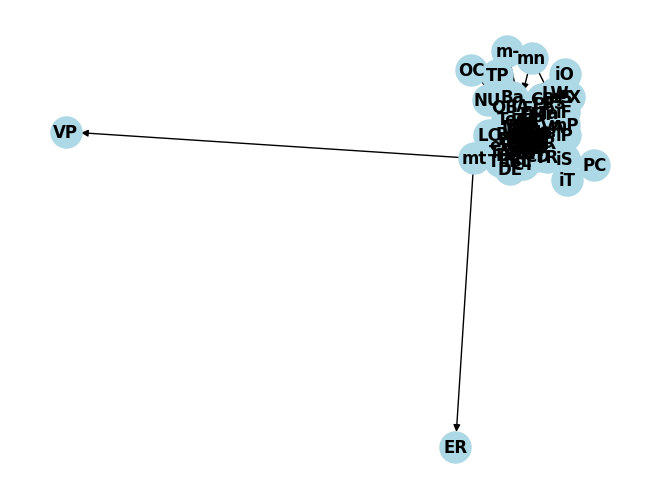

In [ ]:
#read mos key value
mos_val = pd.read_excel(GOOGLE_DRIVE_PATH + "/U of I IVR code data dictionary(updated).xlsx", sheet_name="mos")

G = nx.DiGraph()
G.add_nodes_from(mos_val['Code'].values)

#edges = [('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'E'), ('E', 'A')]
edges = []
for mos in moss:
  #reduce moss
  new_mos = []
  for page in mos:
    if page not in new_mos:
      new_mos.append(page)
  mos = new_mos

  #for edges
  for i in range(len(mos) - 1):
    if (mos[i], mos[i + 1]) not in edges:
      edges.append((mos[i], mos[i + 1]))
G.add_edges_from(edges)

# Draw the graph
#nx.draw(G, with_labels=True, node_color='lightblue', node_size=200, font_size=20, arrowsize=20)
connected_nodes = [n for n in G.nodes if G.degree[n] > 0]
H = G.subgraph(connected_nodes)

# Draw the graph
nx.draw(H, with_labels=True, node_size=500, node_color='lightblue', font_size=12, font_weight='bold')

# Display the plot
plt.show()

In [ ]:
#find a popular start and see how it goes
children_of_IA = list(G.successors("IA"))
print("Children of node 1:", children_of_IA)
print(len(children_of_IA))

Children of node 1: ['PP', 'BA', 'AA', 'PI', 'FI', 'DR', 'CB', 'DP', 'TR', 'OC', 'nl', 'mm', 'NU', 'Ba', 'LW']
15


In [ ]:
children_of_PP = list(G.successors("PP"))
print("Children of node PP:", children_of_PP)
print(len(children_of_PP))

children_of_BA = list(G.successors("BA"))
print("Children of node BA:", children_of_BA)
print(len(children_of_BA))

children_of_AA = list(G.successors("AA"))
print("Children of node AA:", children_of_AA)
print(len(children_of_AA))

Children of node PP: ['TR', 'BA', 'mt', 'PT', 'AT', 'PS', 'CA', 'SR', 'Ba', 'LW', 'AP', 'IC', 'LS', 'mm', 'SP', 'CD']
16
Children of node BA: ['TS', 'MR', 'nl', 'TA', 'TR', 'mm', 'RI', 'PT', 'mo', 'eL', 'AT', 'mp', 'SP', 'mt', 'CT', 'AU', 'PA', 'Pd', 'LS', 'ss', 'VA', 'mP', 'iL', 'wa', 'SR', 'CA']
26
Children of node AA: ['BA', 'Mr', 'HI', 'TR', 'Ta', 'CB', 'DP', 'mm', 'nl', 'mt', 'iR', 'CT', 'PT', 'GA', 'SP', 'LW']
16


In [ ]:
children_of_TR = list(G.successors("PT"))
print("Children of node TR:", children_of_TR)
print(len(children_of_TR))

Children of node TR: ['TR', 'AT', 'mt', 'mo', 'mm', 'me', 'mp', 'CT', 'eY', 'GA', 'CA', 'wa', 'AP', 'LS', 'IC', 'PA', 'AU', 'SP', 'MP', 'iR', 'RP', 'PS', 'RC', 'BA', 'iL', 'PC', 'Pd', 'SR', 'eL', 'mP', 'eA', 'BL', 'eP', 'nl']
34


### Key Question: How different are values from two dates (Not so different except account balance)


In [ ]:
diffdate_df = pd.DataFrame(columns=['Attribute', 'Number of changes', 'Percentage'])
n = df.shape[0]

date_columns = ['no_of_accounts_with_syf', 'account_balance', 'delinquency_history',
                'account_open_date', 'account_status', 'card_activation_status',
                'eservice_ind', 'ebill_enrolled_status', 'auto_pay_enrolled_status']
for date_column in date_columns:
  name_13 = date_column + "_13_march"
  name_18 = date_column + "_18_march"
  #print(f"Attribue {date_column} has {sum(df[name_13] != df[name_18])} differences.")
  diffdate_df = diffdate_df.append({'Attribute': date_column,
                                    'Number of changes': sum(df[name_13] != df[name_18]),
                                   'Percentage':  sum(df[name_13] != df[name_18])/n}, ignore_index=True)

diffdate_df

<ipython-input-33-0fffab40d1dd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diffdate_df = diffdate_df.append({'Attribute': date_column,
<ipython-input-33-0fffab40d1dd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diffdate_df = diffdate_df.append({'Attribute': date_column,
<ipython-input-33-0fffab40d1dd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diffdate_df = diffdate_df.append({'Attribute': date_column,
<ipython-input-33-0fffab40d1dd>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  diffdate_df = diffdate_df.append({'Attribute': date_column,
<ipython-input-33-0fffab40d1dd>:11: FutureWarning: The frame.append method i

Attribute Number of changes  Percentage
0   no_of_accounts_with_syf             20521    0.011408
1           account_balance            282339    0.156960
2       delinquency_history             28928    0.016082
3         account_open_date                 2    0.000001
4            account_status           1735683    0.964913
5    card_activation_status             35530    0.019752
6              eservice_ind              8037    0.004468
7     ebill_enrolled_status             25118    0.013964
8  auto_pay_enrolled_status              1165    0.000648

### Key Question: How to extract features from mos

#### Approach One: Add a ton more variables

In [ ]:
#df['substring_count'] = df['text_column'].str.count(substring)

In [ ]:
#parse
moss = []
for i in range(df.shape[0]):
  moss.append(df.iloc[i, 4].split(" "))

unique_codes = sorted(list(set([item for sublist in moss for item in sublist])))

In [ ]:
for code in tqdm(unique_codes):
  df[code] = df['mos'].str.count(code)

 97%|█████████▋| 83/86 [01:29<00:03,  1.09s/it]<ipython-input-16-e139ee6068b9>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[code] = df['mos'].str.count(code)
 98%|█████████▊| 84/86 [01:31<00:02,  1.11s/it]<ipython-input-16-e139ee6068b9>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[code] = df['mos'].str.count(code)
 99%|█████████▉| 85/86 [01:32<00:01,  1.10s/it]<ipython-input-16-e139ee6068b9>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

In [ ]:
df.to_csv(GOOGLE_DRIVE_PATH + '/data/moss_onehot.csv', index=False)

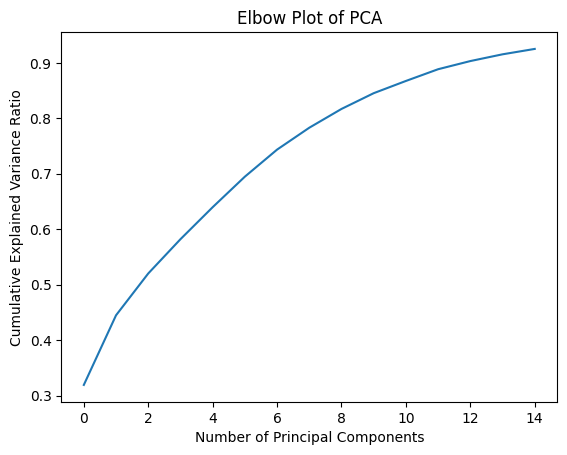

In [ ]:
#PCA on all code variables: doesn't perform well
code_mat = df.iloc[:, 28:].values

pca = PCA(n_components=15)
pca.fit(code_mat)

transformed_code = pca.transform(code_mat)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Elbow Plot of PCA')
plt.show()

In [ ]:
df.columns[1:28]

Index(['retailer_code', 'serial', 'reason', 'mos', 'resolved',
       'no_of_accounts_with_syf_13_march', 'account_balance_13_march',
       'delinquency_history_13_march', 'account_open_date_13_march',
       'account_status_13_march', 'card_activation_status_13_march',
       'eservice_ind_13_march', 'ebill_enrolled_status_13_march',
       'auto_pay_enrolled_status_13_march', 'no_of_accounts_with_syf_18_march',
       'account_balance_18_march', 'delinquency_history_18_march',
       'account_open_date_18_march', 'account_status_18_march',
       'card_activation_status_18_march', 'eservice_ind_18_march',
       'ebill_enrolled_status_18_march', 'auto_pay_enrolled_status_18_march',
       'date', 'time', 'call', 'key'],
      dtype='object')

In [ ]:
num_columns = []
cate_columns = ['retailer_code', ]

In [ ]:
#this takes very long so maybenot
!pip install kmodes

from kmodes.kmodes import KModes

k_modes = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1)

clusters = k_modes.fit_predict(code_mat)

print("Cluster Centroids:")
print(k_modes.cluster_centroids_)

print("Cluster Labels:")
print(clusters)

#### Approach Two: Extract Meaningful features from mos
* length of mos
* number of repeated codes
* authenticate/not authenticate
* starting point
* ending point

### Key Question: How is mos features related to results?

#### Mos Length

In [ ]:
df['mos_len'] = 1 + df['mos'].str.count(' ')
df['resolved_bi'] = (df['resolved'] == 'floor')

<ipython-input-23-6ab0ca9f9659>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['resolved_bi'] = (df['resolved'] == 'floor')


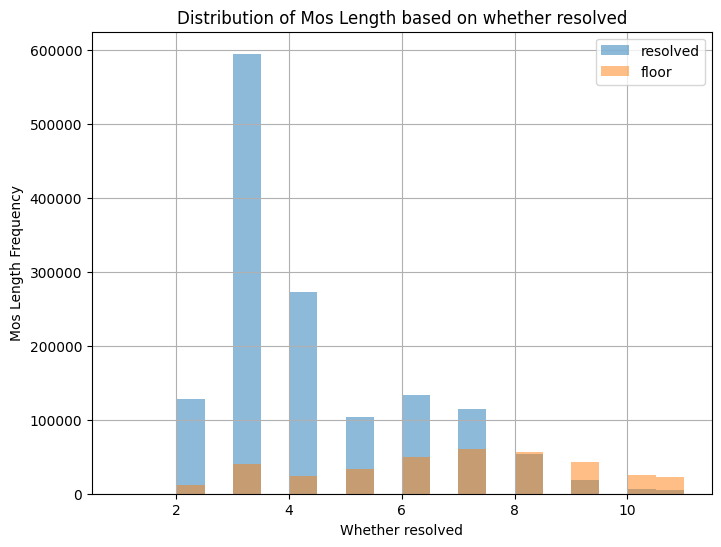

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['mos_len'][df['resolved_bi'] == 0], bins=20, alpha=0.5, label='resolved')
plt.hist(df['mos_len'][df['resolved_bi'] == 1], bins=20, alpha=0.5, label='floor')

plt.xlabel('Whether resolved')
plt.ylabel('Mos Length Frequency')
plt.title('Distribution of Mos Length based on whether resolved')
plt.legend()
plt.grid(True)
plt.show()

#### Number of repeated items in mos

In [ ]:
from collections import Counter
df['mos_dup'] = [sum(1 for count in Counter(sublist).values() if count > 1) for sublist in moss]
#df['mos_dup'] = [len(sublist) - len(set(sublist)) for sublist in moss]

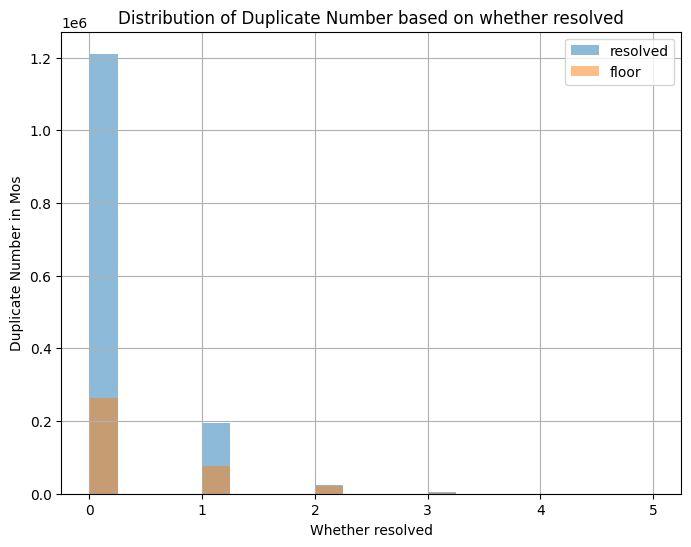

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['mos_dup'][df['resolved_bi'] == 0], bins=20, alpha=0.5, label='resolved')
plt.hist(df['mos_dup'][df['resolved_bi'] == 1], bins=20, alpha=0.5, label='floor')

plt.xlabel('Whether resolved')
plt.ylabel('Duplicate Number in Mos')
plt.title('Distribution of Duplicate Number based on whether resolved')
plt.legend()
plt.grid(True)
plt.show()

#### Approach Three: Bigram even more variables

### Key Question: What mos codes are strongly related to specific retailers (Not very helpful since unique functionalities are rare)

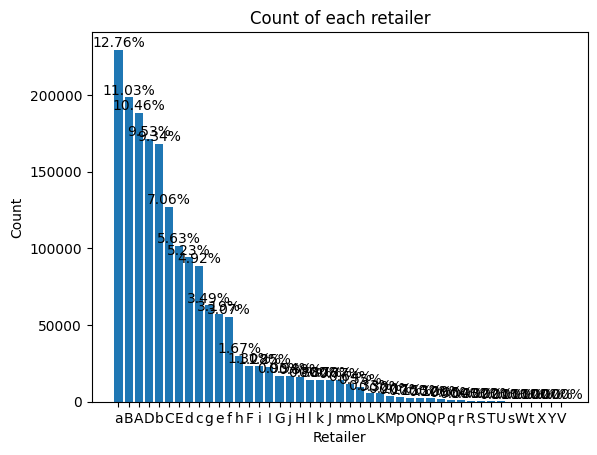

In [ ]:
retailers = df['retailer_code'].unique()

retailer_counts = df['retailer_code'].value_counts()

# Calculate percentages
total_count = retailer_counts.sum()
percentage = (retailer_counts / total_count) * 100

# Plot histogram
plt.bar(retailer_counts.index, retailer_counts.values)
plt.xlabel('Retailer')
plt.ylabel('Count')
plt.title('Count of each retailer')
# Annotate bars with percentages
for i, count in enumerate(retailer_counts.values):
    plt.text(i, count, f'{percentage[i]:.2f}%', ha='center', va='bottom')
plt.show()

#### Determine which moss code are strongly related to company

In [ ]:
arr = np.array([1,1, 1, 2, 3])
np.unique(arr)

array([1, 2, 3])

In [ ]:
#rule-based filtering: which moss code only appear in one company
for code in tqdm(unique_codes):
  retailers = df[df['mos'].str.contains(code)]['retailer_code'].values
  if len(np.unique(retailers)) == 1:
    print(f"Code {code} is unique to retailer {retailers[0]}")

 28%|██▊       | 24/86 [00:25<01:06,  1.08s/it]

Code LW is unique to retailer l


 33%|███▎      | 28/86 [00:29<00:55,  1.05it/s]

Code NU is unique to retailer V


 43%|████▎     | 37/86 [00:37<00:46,  1.06it/s]

Code PX is unique to retailer g


 60%|██████    | 52/86 [00:49<00:24,  1.40it/s]

Code TP is unique to retailer j


 79%|███████▉  | 68/86 [01:04<00:13,  1.37it/s]

Code iF is unique to retailer E


 83%|████████▎ | 71/86 [01:08<00:16,  1.10s/it]

Code iO is unique to retailer D


 86%|████████▌ | 74/86 [01:10<00:09,  1.22it/s]

Code iS is unique to retailer D


 87%|████████▋ | 75/86 [01:11<00:08,  1.28it/s]

Code iT is unique to retailer n


 88%|████████▊ | 76/86 [01:12<00:07,  1.32it/s]

Code m- is unique to retailer C


100%|██████████| 86/86 [01:22<00:00,  1.04it/s]


In [ ]:
#reasons
unique_reasons = df['reason'].unique()
for code in tqdm(unique_reasons):
  retailers = df[df['mos'].str.contains(code)]['retailer_code'].values
  if len(np.unique(retailers)) == 1:
    print(f"Reason {code} is unique to retailer {retailers[0]}")

 55%|█████▍    | 40/73 [00:40<00:36,  1.09s/it]

Reason iF is unique to retailer E


 68%|██████▊   | 50/73 [00:50<00:23,  1.04s/it]

Reason NU is unique to retailer V


 81%|████████  | 59/73 [00:56<00:09,  1.45it/s]

Reason iS is unique to retailer D


 82%|████████▏ | 60/73 [00:57<00:09,  1.44it/s]

Reason m- is unique to retailer C


 84%|████████▎ | 61/73 [00:57<00:08,  1.45it/s]

Reason iO is unique to retailer D


 92%|█████████▏| 67/73 [01:03<00:06,  1.03s/it]

Reason LW is unique to retailer l


 99%|█████████▊| 72/73 [01:07<00:00,  1.26it/s]

Reason iT is unique to retailer n


100%|██████████| 73/73 [01:08<00:00,  1.06it/s]


## Reason

In [ ]:
reasons = df['reason'].unique()
reason_explains = []
for i in range(mos_val.shape[0]):
  if mos_val.iloc[i, 0] in reasons:
    reason_explains.append(mos_val.iloc[i, 1])

In [ ]:
#write reason to txt
with open(GOOGLE_DRIVE_PATH + "/reasons.txt", "w") as file:
  file.write(",".join(reason_explains))

## One-hot-encode model

In [ ]:
df_cleaned = pd.read_csv(GOOGLE_DRIVE_PATH + "/data/cleaned_data.csv")

In [ ]:
#add one shot
#parse moss
moss = []
for i in range(df_cleaned.shape[0]):
  moss.append(df_cleaned.iloc[i, 4].split(" "))
unique_codes = sorted(list(set([item for sublist in moss for item in sublist])))

#add moss to column
for code in tqdm(unique_codes):
  res = df_cleaned['mos'].str.count(code)
  if np.sum(res) != 0:
    df_cleaned[code] = df_cleaned['mos'].str.count(code)

In [ ]:
#drop uncessary columns
drop_columns = [
  "timestamp_call_key",
  "mos",
  "no_of_accounts_with_syf_18_march",
  "account_balance_18_march",
  "delinquency_history_18_march",
  "account_open_date_18_march",
  "account_status_18_march",
  "card_activation_status_18_march",
  "eservice_ind_18_march",
  "ebill_enrolled_status_18_march",
  "auto_pay_enrolled_status_18_march",
  "account_status_description_18_march",
  "current_delinquency_delinquency_history_18_march",
  "previous_delinquency_delinquency_history_18_march",
  "date_time",
  "date",
  "call_count",
  "years_since_opened"
]

df_cleaned.drop(columns=drop_columns, inplace=True)

In [ ]:
df_cleaned.shape[1] - df_cleaned.columns.get_loc("AA")

68

In [ ]:
df_cleaned.to_csv(GOOGLE_DRIVE_PATH + "/data/data_cleaned_onehot.csv")

In [ ]:
#add bigram
bigram_df = pd.DataFrame()
for i in tqdm(range(len(unique_codes) - 1)):
  for j in range(i + 1, len(unique_codes)):
    substring = f"{unique_codes[i]} {unique_codes[j]}"
    res = df['mos'].str.count(substring)
    if np.sum(res) != 0:
      bigram_df[substring] = res

  6%|▌         | 4/72 [05:05<1:25:51, 75.76s/it]

#### Decision Tree

#### Lasso

In [ ]:
#load model
df_nona = pd.read_csv(GOOGLE_DRIVE_PATH + "/data/df_final_2.csv")
df_one_bi = pd.read_csv(GOOGLE_DRIVE_PATH + "/data/df_cleaned_one_bi.csv")

In [97]:
print(df_nona.shape)
print(df_one_bi.shape)

(1549150, 27)
(1798798, 219)


In [ ]:
#join data based on serial and merge
df_one_bi_only = df_one_bi.iloc[:, [4] + [i for i in range(47, 219)]]
df_final = pd.concat([df_nona, df_one_bi_only], axis=1, join="inner")
df_final = df_final.drop(['mos', 'serial', 'Unnamed: 0'], axis=1)

In [ ]:
df_final.shape

(1549150, 196)

#### Test for multi-colinearity

In [ ]:
col_cate  = ["reason", "ebill_enrolled_status_13_march", "account_status_description_13_march", "date_time"]
df_nocat = df_final.drop(col_cate, axis=1)

In [ ]:
correlation_matrix = df_nocat.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

<ipython-input-13-0348e3b0cd7f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_nocat.corr()


KeyboardInterrupt: 

In [ ]:
# the independent variables set
X = df_nocat.drop(columns=['resolved'])
y = df_nocat[['resolved']] == "floor"

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

## Auto ML

In [76]:
def print_param(mdl):
  my_param = ['max_depth', 'learn_rate', 'sample_rate', 'scale_pos_weight', 'colsample_bytree', 'ntrees']
  params = mdl.params
  for param in my_param:
    print(f"{param}:{params[param]}\n")

In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 5.1 MB/s eta 0:00:00


In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpia2qfext
  JVM stdout: /tmp/tmpia2qfext/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpia2qfext/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    11 days
H2O_cluster_name:           H2O_from_python_unknownUser_m7u21w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    12.75 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [ ]:
from h2o.frame import H2OFrame
auto_df = H2OFrame(df_final)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
#dropped time
enum_columns = ['retailer_code', 'reason',  'resolved', 'account_status_description_13_march']

# Convert enum columns to factors
for column in enum_columns:
    auto_df[column] = auto_df[column].asfactor()

# Verify changes
auto_df.describe()

Rows:1549150
Cols:196

retailer_code    reason    resolved    no_of_accounts_with_syf_13_march    account_balance_13_march    account_status_13_march    card_activation_status_13_march    eservice_ind_13_march    ebill_enrolled_status_13_march      auto_pay_enrolled_status_13_march    account_status_description_13_march    current_delinquency_delinquency_history_13_march    previous_delinquency_delinquency_history_13_march    date_time            call_count          years_since_opened_full    no_of_accounts_with_syf_diff    account_balance_diff    delinquency_history_diff    account_status_diff    card_activation_status_diff    eservice_ind_diff      ebill_enrolled_status_diff    auto_pay_enrolled_status_diff    AA                   AP                    AT                   AU                    BA                  BL                     CA                     CB                     CD                     CS       CT                    DE                      DP                     DR                    ER                     FD       FI                     FM                     FR       GA                     HI                    IA                 IC                    LC                    LS                    LW                     Ls       MP                     NU                      OB                     PA                     PC                      PI                   PP                   PS                    PT                   Pd                     RC                    RI                    RP                     RS                   RV       SP                    SR                     VA                      VP                      WA                     eA                     eB                      eL                     eP                      eR                      eS                     eY                     iA                    iF                     iL                     iM                      iO                     iP                      iR                     iS                      iT                     m-                     mP                     me                     mm                   mn                   mo                    mp                   mt                   ss                     wa                   AA BA                AA CB                   AA CT                  AA DP                  AA GA                  AA HI                  AA LW                   AA PT                  AA RC                  AA SP                  AA iR                  AA mm                   AA mt                   AP HI                   AP mm                  AT mm                  AU mm                  BA Pd                 BA RI                  BA mm                 CA mm                   CT mm                   CT mt                CT wa                   DE mt                   DE wa                  DR IC                 DR PI                  DR PT                  FI IA                   FI PI                   FI PP                  FM HI                   FM IA                 FM mm                   GA mm                   GA wa                  HI IA                  HI LS                   HI PP                  HI mm                   IA IC                  IA LS                  IA LW                   IA NU                   IA PI                IA PP                IA PS                  IA PT                   IA SP                 IA SR                   IA mm                   IC mm                  LS mm                  LW PI                  MP mm                 NU mm                   OB PI                 PA mm                  PI mm                  PP PS                  PP PT                  PP SP    PP SR                  PS mm                  PT mm                 Pd mm                   RC mm                   RI mm                   RP mm                  RS wa                SR mm                   VA mm                 VA wa                  eA mm                   eB mm

In [ ]:
response="resolved"
predictor= [x for x in auto_df.columns if x != 'resolved']

In [57]:
from h2o.estimators import H2OXGBoostEstimator
from sklearn.metrics import f1_score

def train_and_evaluate_model(data, response, predictors, reason_filter, seed=1234, train_ratio=0.8, show = True):
    """
    Train and evaluate an XGBoost model using h2o.

    :param data: h2o H2OFrame containing the training data
    :param response: String, the name of the response column
    :param predictors: List of strings, the names of the predictor columns
    :param reason_filter: String, the value of 'reason' column to filter on
    :param seed: Integer, a seed for random operations
    :param train_ratio: Float, the ratio of training set split
    :return: The trained model and performance metrics
    """
    # Filter data based on reason
    sampled_data = data[data['reason'] == reason_filter]

    # Split the data into train and test sets
    splits = sampled_data.split_frame(ratios=[train_ratio], seed=seed)
    train = splits[0]
    test = splits[1]

    # Convert the response column to a categorical factor
    train[response] = train[response].asfactor()
    test[response] = test[response].asfactor()
    class_counts_df = train[response].asfactor().table().as_data_frame()
    # Assuming the minority class is at index 1 and the majority class is at index 0
    class_ratio = class_counts_df['Count'].iloc[0] / class_counts_df['Count'].iloc[1]

    # Initialize and train the XGBoost model with scale_pos_weight parameter
    xgboost_model = H2OXGBoostEstimator(scale_pos_weight=class_ratio)
    xgboost_model.train(x=predictors, y=response, training_frame=train)

    # Initialize and train the XGBoost model
    #xgboost_model = H2OXGBoostEstimator()
    #xgboost_model.train(x=predictors, y=response, training_frame=train)
    # Evaluate the model's performance on the test set
    performance = xgboost_model.model_performance(test)
    # Explain the model on the train set
    #
    if show:
      #print(xgboost_model)
      print(performance)
      explanation = xgboost_model.explain(train)
      print(explanation)
    return xgboost_model, performance

#### AA XGB

In [ ]:
aa_xgb_mdl, aa_perf, aa_exp= train_and_evaluate_model(auto_df, 'resolved', predictor, 'AA', show = False)
aa_var_imp = aa_xgb_mdl.varimp(use_pandas=True)

In [ ]:
aa_var_imp.head()

variable  relative_importance  scaled_importance  \
0           retailer_code.a          2886.980225           1.000000   
1                 date_time          1047.447632           0.362818   
2  account_balance_13_march           893.568420           0.309517   
3   years_since_opened_full           429.049438           0.148615   
4                call_count           372.390411           0.128990   

   percentage  
0    0.403708  
1    0.146473  
2    0.124954  
3    0.059997  
4    0.052074

In [ ]:
#step: takes long and not very effeictive
response="resolved"
predictor= [x for x in auto_df.columns if x != 'resolved']
min_imp = 0
drop_df = pd.DataFrame(columns=['variable', 'F1_1', 'F1_2'])

while(min_imp <= 0.1):
  xgb_mdl, perf = train_and_evaluate_model(auto_df, 'resolved', predictor, 'AA', show = False)
  var_imp = xgb_mdl.varimp(use_pandas=True)

  min_imp = var_imp['scaled_importance'].min()
  min_index = var_imp['scaled_importance'].idxmin()
  min_var = var_imp.loc[min_index, 'variable']

  predictor = [p for p in predictor if p != min_var.split(".")[0]]
  print(min_var)
  print(min_imp)

  f1 = perf.F1()
  data = {'variable': min_var, 'F1_1': f1[0][0], 'F1_2': f1[0][1]}
  drop_df = drop_df.append(data, ignore_index=True)

In [ ]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OXGBoostEstimator

sampled_data = auto_df[auto_df['reason'] == "AA"]

response="resolved"
predictor= [x for x in auto_df.columns if x != 'resolved']
train,test,valid = sampled_data.split_frame(ratios=[.6, .2], seed = 2018)

# GBM hyperparameters
gbm_params1 = {'learn_rate': [0.9, 0.1],
               'max_depth': [6, 8],
               'sample_rate': [ 0.8, 0.9, 1.0],
               'scale_pos_weight': [0.5, 0.6],
               'colsample_bytree': [0.5, 0.6]}

# Train and validate a cartesian grid of GBMs
gbm_grid1 = H2OGridSearch(model=H2OXGBoostEstimator,
                          grid_id='gbm_grid1',
                          hyper_params=gbm_params1)
gbm_grid1.train(x=predictor, y=response,
                training_frame=train,
                validation_frame=valid,
                ntrees=100,
                seed=1)

# Get the grid results, sorted by validation AUC
gbm_gridperf1 = gbm_grid1.get_grid(sort_by='auc', decreasing=True)
gbm_gridperf1

# Grab the top GBM model, chosen by validation AUC
best_gbm1 = gbm_gridperf1.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf1 = best_gbm1.model_performance(test)

best_gbm_perf1.auc()
# 0.7781778619721595

xgboost Grid Build progress: |█

In [ ]:
my_param = ['max_depth', 'learn_rate', 'sample_rate', 'scale_pos_weight', 'colsample_bytree']
params = best_gbm1.params
for param in my_param:
  print(f"{param}:{params[param]}\n")

max_depth:{'default': 6, 'actual': 6, 'input': 6}

learn_rate:{'default': 0.3, 'actual': 0.1, 'input': 0.1}

sample_rate:{'default': 1.0, 'actual': 1.0, 'input': 1.0}

scale_pos_weight:{'default': 1.0, 'actual': 0.8, 'input': 0.8}

colsample_bytree:{'default': 1.0, 'actual': 0.8, 'input': 0.8}



Model Details
H2OXGBoostEstimator : XGBoost
Model Key: gbm_grid1_model_67


Model Summary: 
    number_of_trees
--  -----------------
    100

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1644781408087596
RMSE: 0.4055590472529982
LogLoss: 0.5061004553829734
Mean Per-Class Error: 0.39129057323702493
AUC: 0.7469935583072526
AUCPR: 0.8754943782682507
Gini: 0.4939871166145051

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44701003772871833
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ----------------
floor     1815     5316        0.7455   (5316.0/7131.0)
resolved  722      18737       0.0371   (722.0/19459.0)
Total     2537     24053       0.2271   (6038.0/26590.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.44701      0.861234  294
max f2                

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## gbm_grid1_model_67

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44701003772871833
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ----------------
floor     1815     5316        0.7455   (5316.0/7131.0)
resolved  722      18737       0.0371   (722.0/19459.0)
Total     2537     24053       0.2271   (6038.0/26590.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

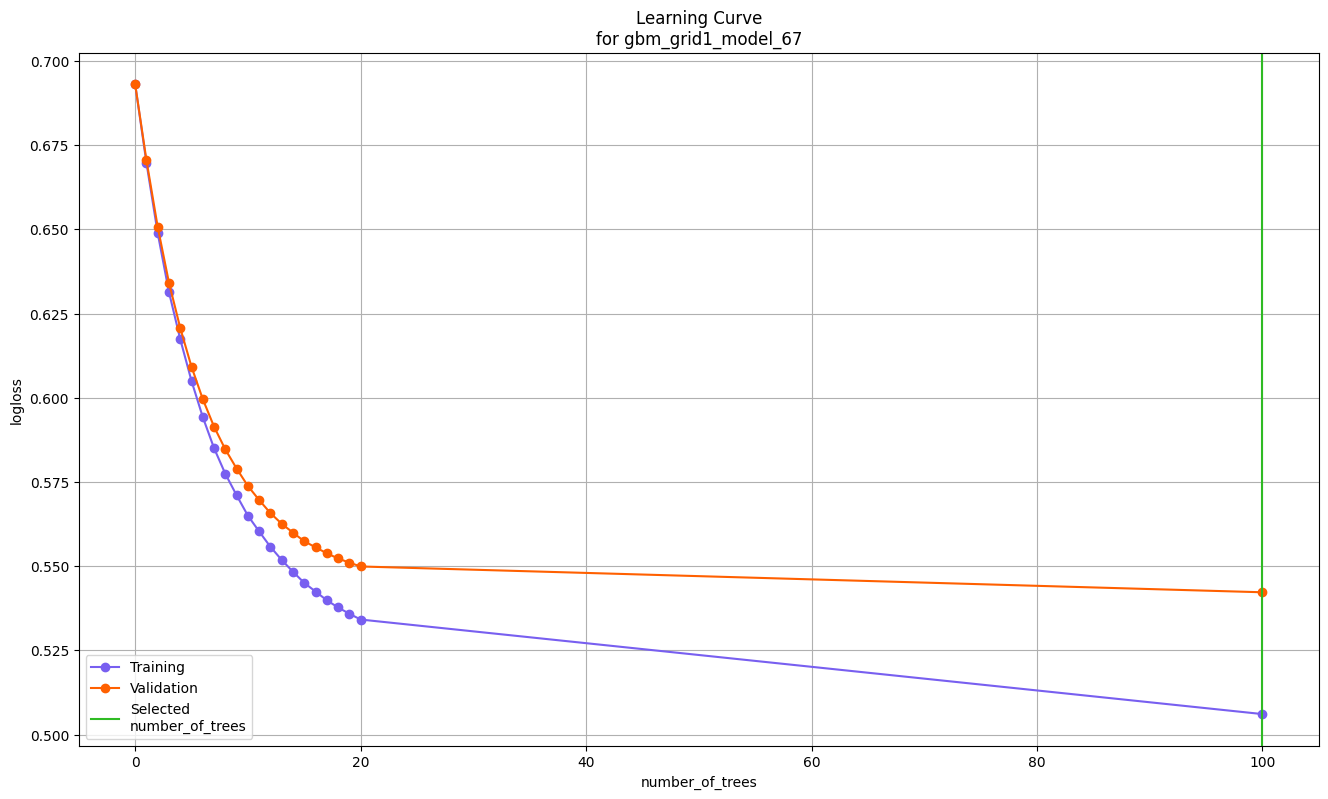

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

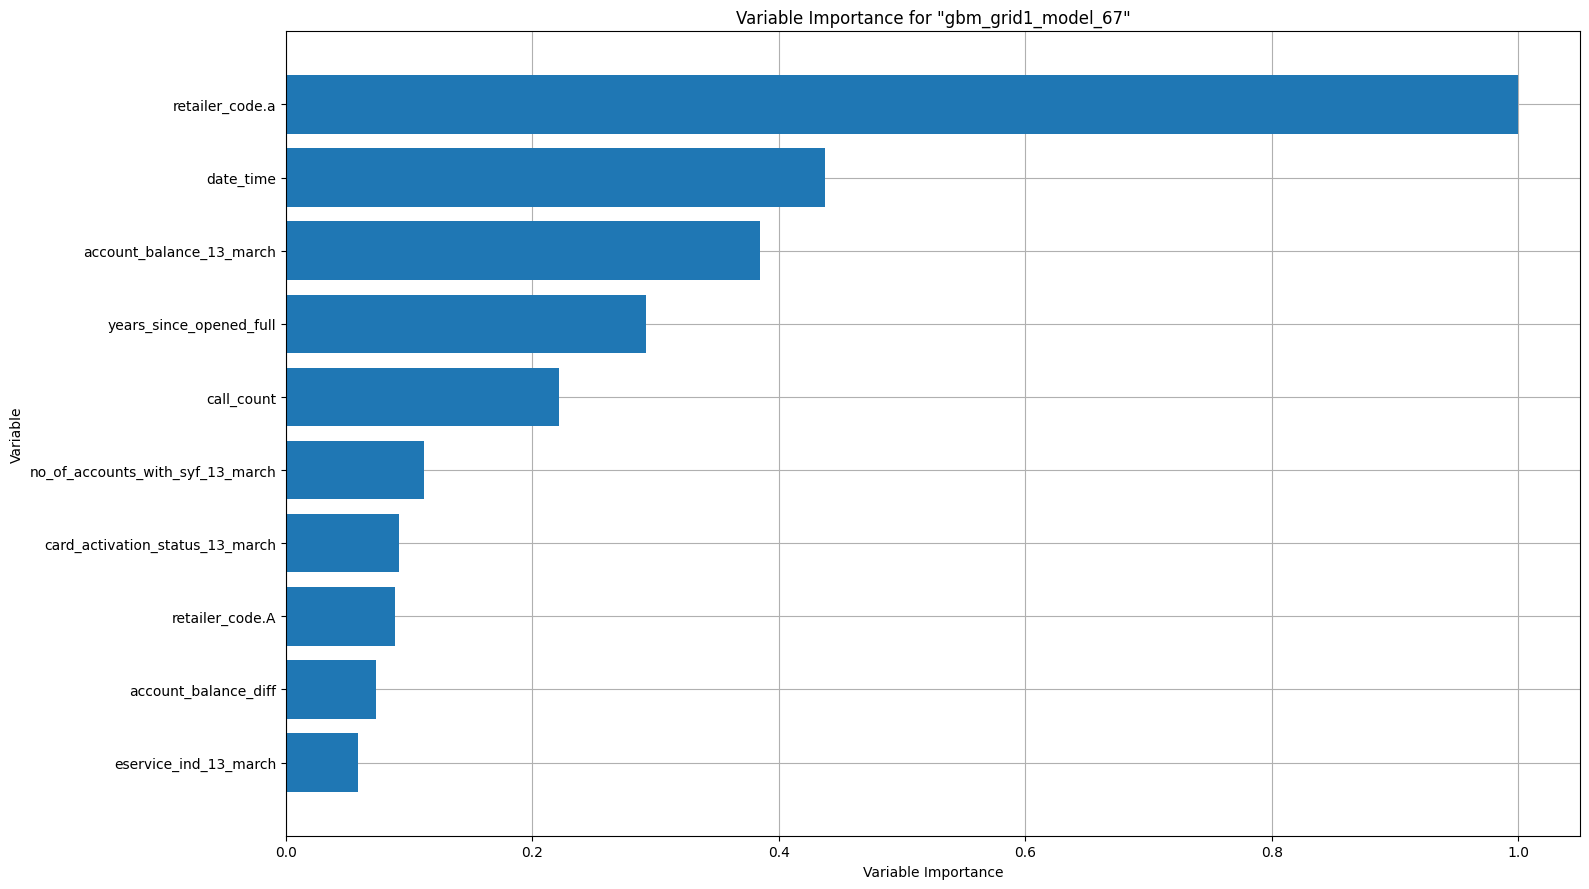

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

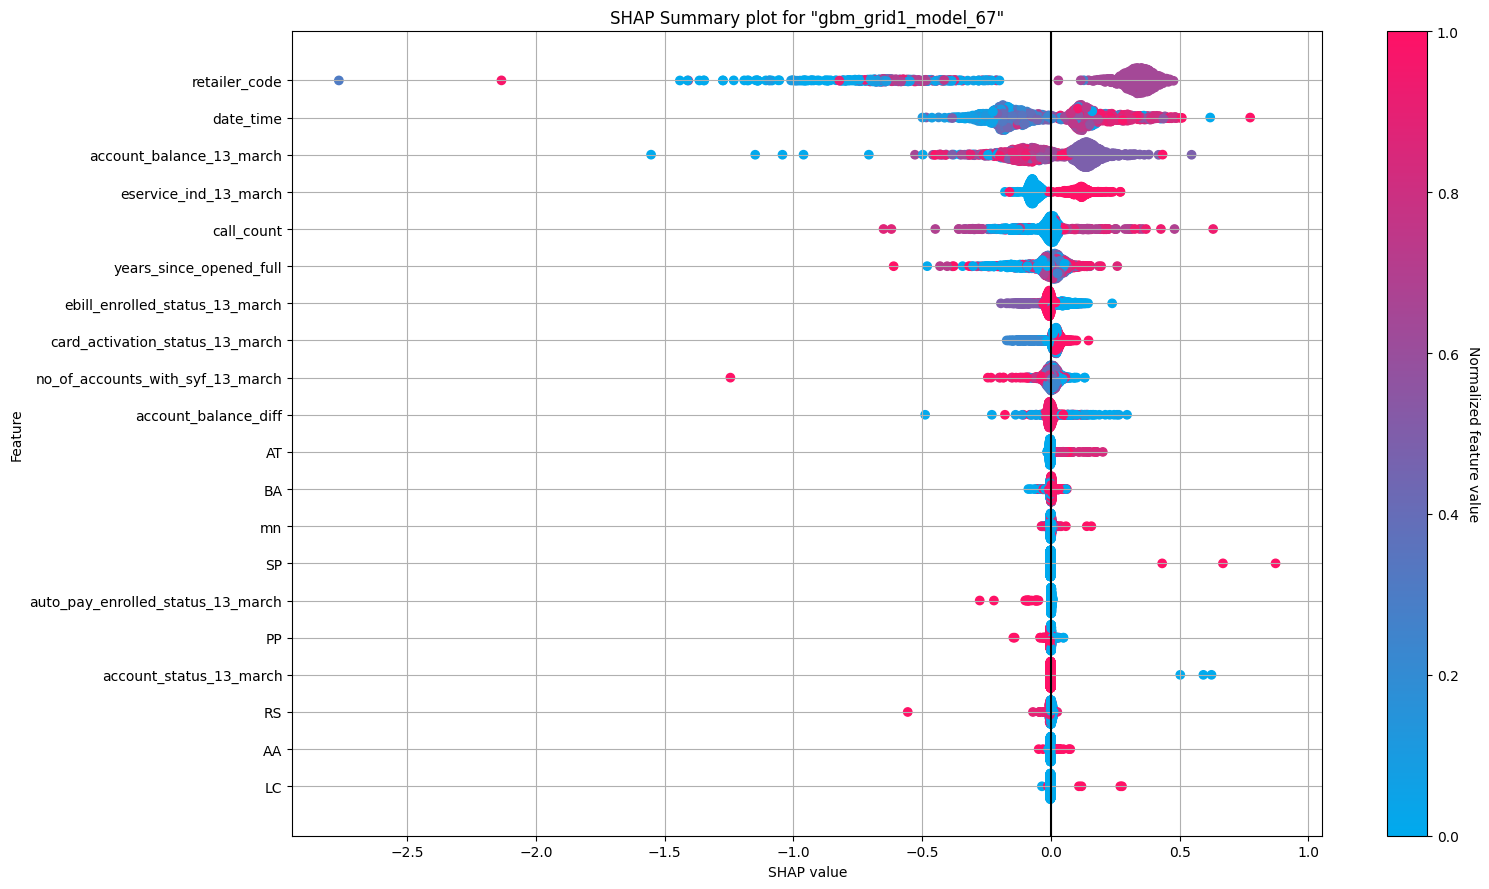

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

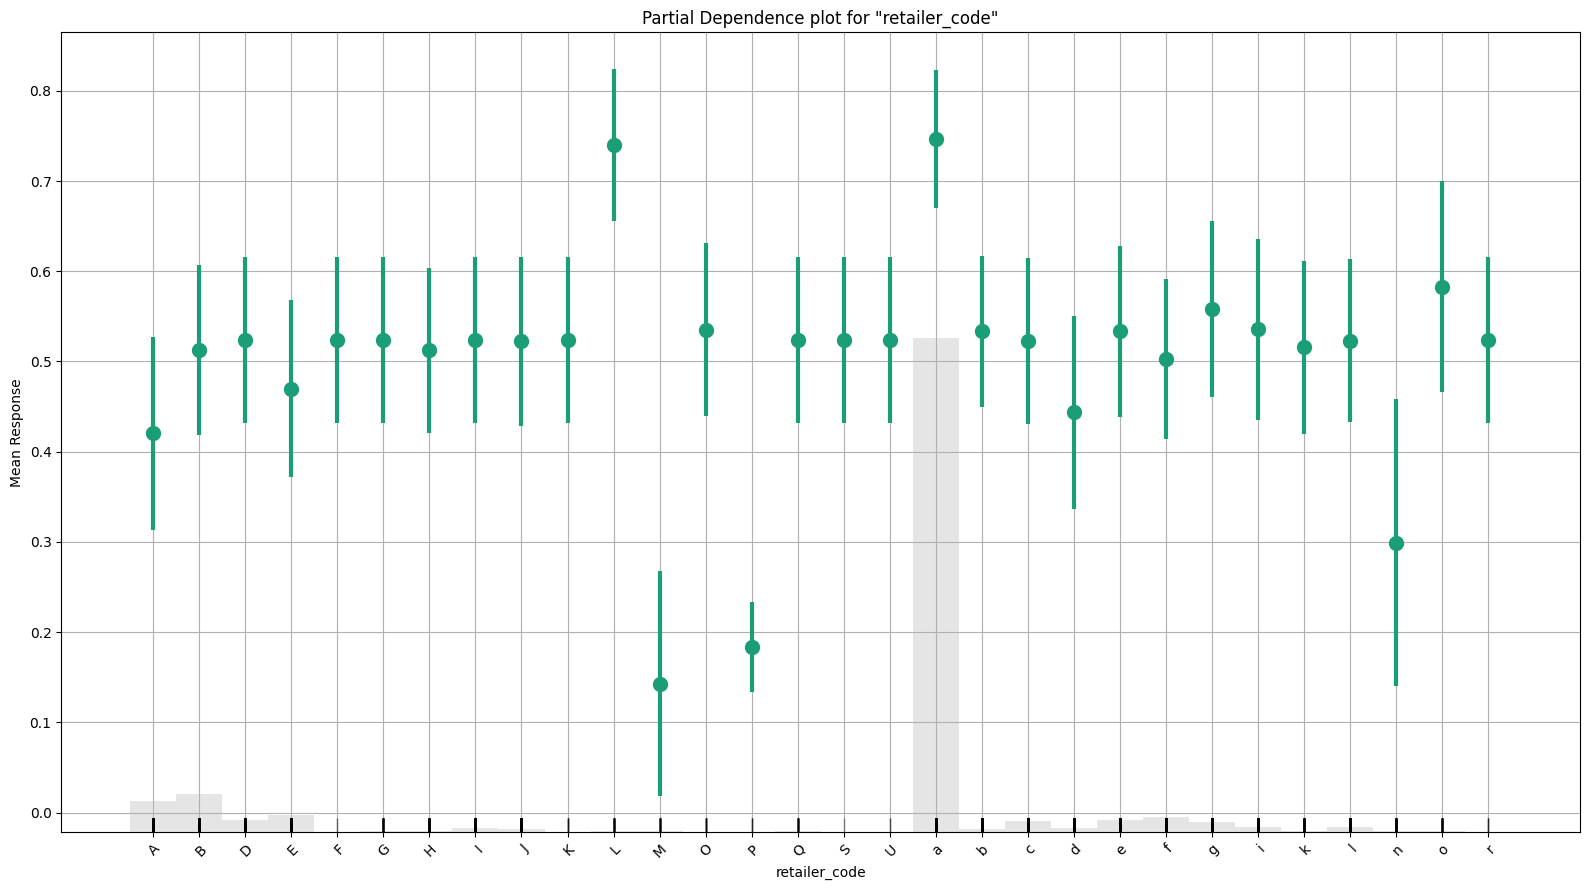

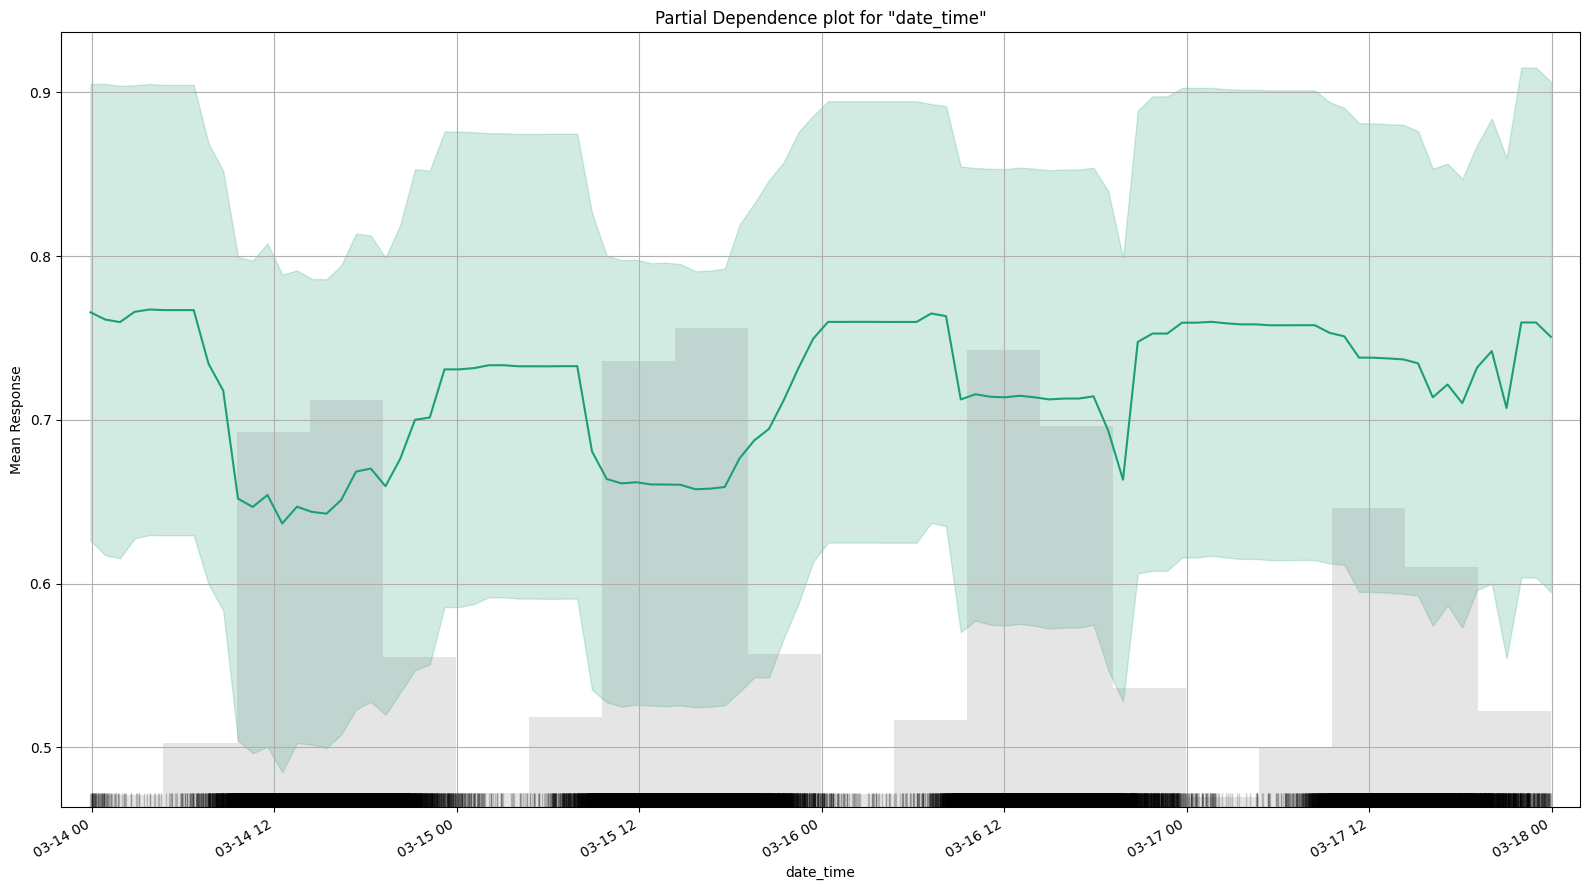

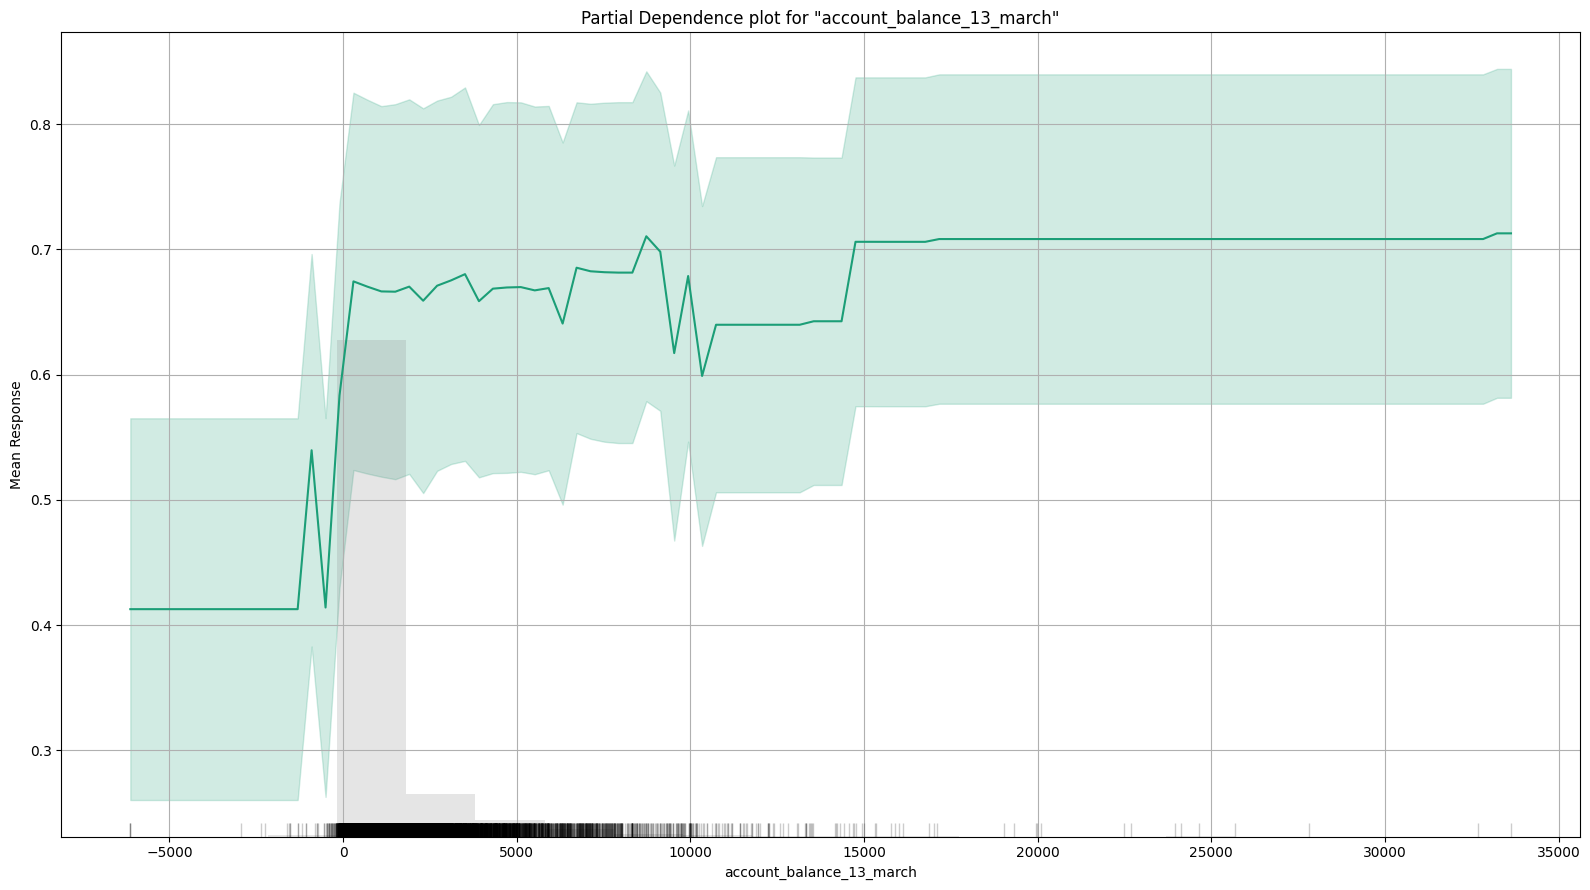

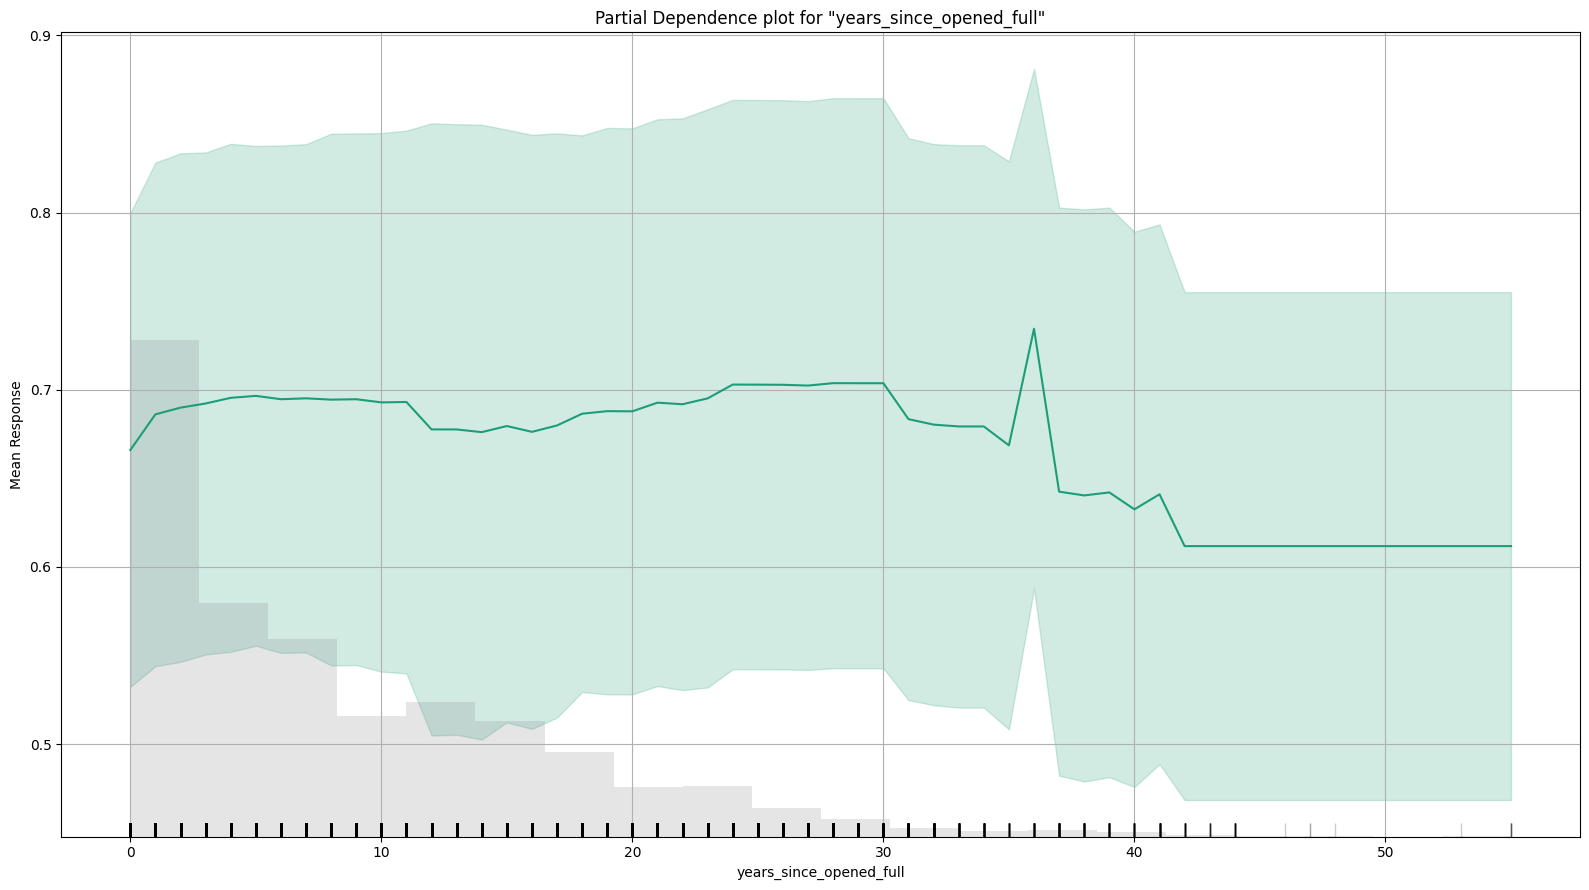

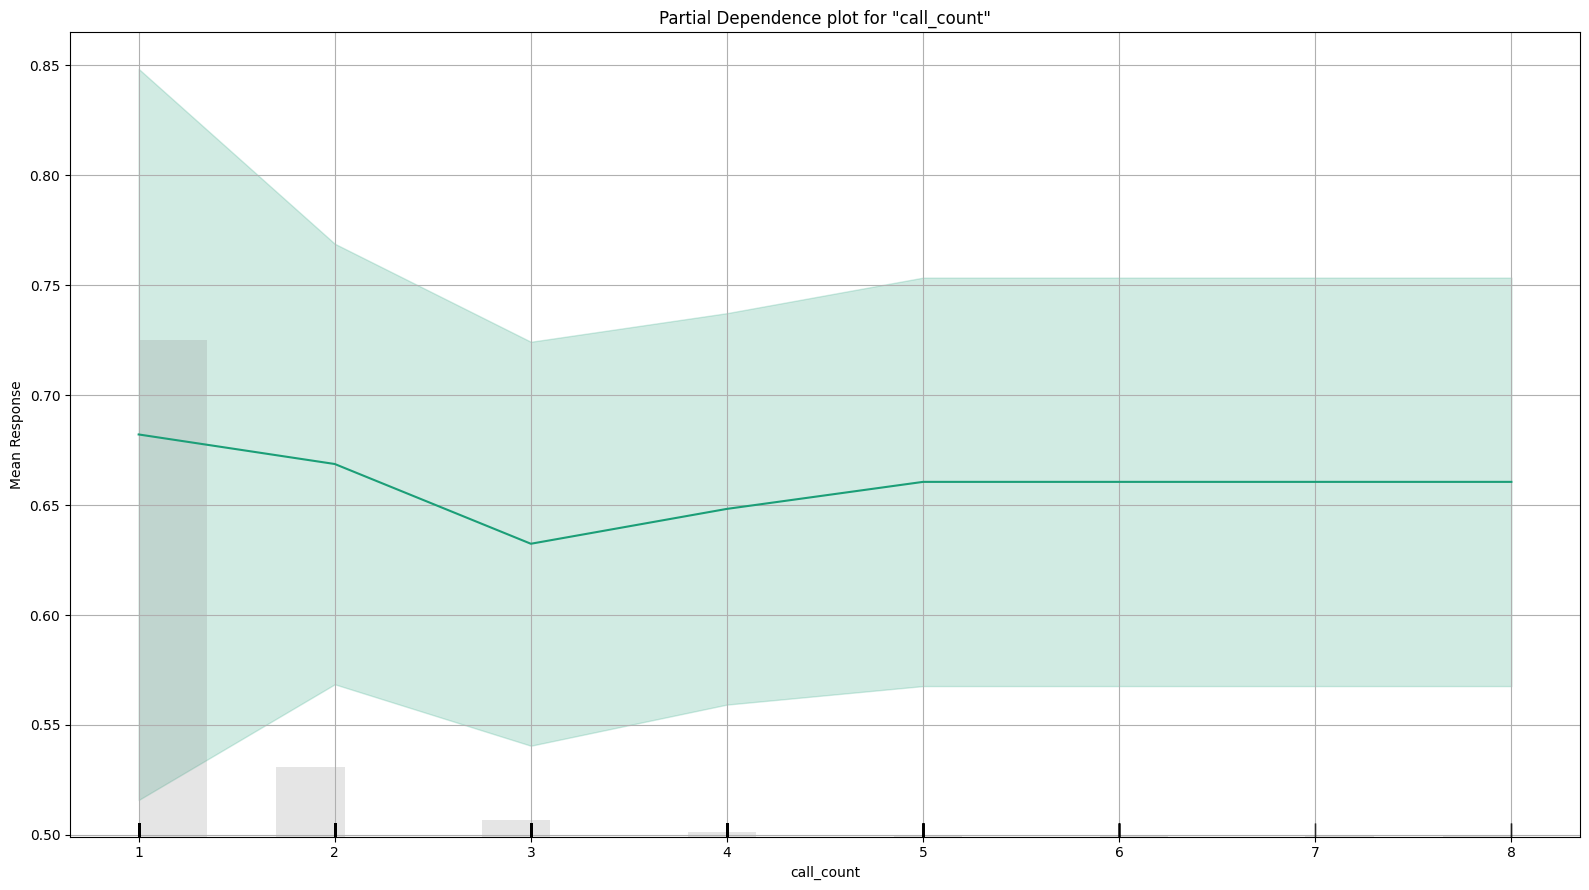



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada937cbf70>), ('description', <h2o.explanation._explain.Description object at 0x7ada937cb9d0>), ('subexplanations', H2OExplanation([('gbm_grid1_model_67', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada009f4790>), ('plots', H2OExplanation([('gbm_grid1_model_67', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44701003772871833', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada009f5ae0>), ('description', <h2o.explanation._explain.Description object at 0x7ada009f7b80>), ('plots', H2OExplanation([('gbm_grid1_model_67', <h2o.plot._plot_result._MObject object at 0x7ada93e716f0>)]))])), ('varimp', H2OExplanation([('header', <h2o.explanation._explain.Header object at

In [ ]:
#performance on test
performance = best_gbm1.model_performance(test)
print(best_gbm1 )
print(performance)
explanation = best_gbm1.explain(train)
print(explanation)

In [ ]:
xgb_mdl, perf = train_and_evaluate_model(auto_df, 'resolved', predictor, 'AA', show = True)

#### CT XGB

default model

In [90]:
# Filter data based on reason
sampled_data = auto_df[auto_df['reason'] == "CT"]

# Split the data into train and test sets
splits = sampled_data.split_frame(ratios=[0.8], seed=2018)
train = splits[0]
test = splits[1]

# Convert the response column to a categorical factor
train[response] = train[response].asfactor()
test[response] = test[response].asfactor()
class_counts_df = train[response].asfactor().table().as_data_frame()
# Assuming the minority class is at index 1 and the majority class is at index 0
class_ratio = class_counts_df['Count'].iloc[0] / class_counts_df['Count'].iloc[1]

# Initialize and train the XGBoost model with scale_pos_weight parameter
mdl_CT = H2OXGBoostEstimator(scale_pos_weight=class_ratio)
mdl_CT.train(x=predictor, y=response, training_frame=train)

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [IA IC, reason, DE, FI PP, AA RC, iO, VA wa, iP, HI mm, iS, FI PI, LW, iT, RI mm, eS, eB mm, CT wa, HI IA, AA mm, eY mm, AA mt, DE wa, iS mm, HI LS, GA mm, mP wa, eR mm, Ls, IA PS, IA LS, PI mm, PP PS, IA LW, iP mm, AA PT, AU mm, AA LW, Pd mm, VP, mo wa, AA iR, iT mm, FD, AA CT, RV, IA SR, NU, IA SP, eS mm, FR, mp wa, GA wa, iM mm, eP mm, FM mm, HI PP, AA GA, FI IA, eA mm, RP mm, NU mm, eL mm, FM IA, VA mm, IA NU, AA SP, CS, PP SP, PP SR, DE mt, mm wa, LW PI, mP mm, eB, iF]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711280219938_16338


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11964563598674416
RMSE: 0.34589830295441487
LogLoss: 0.3863869066123553
Mean Per-Class Error: 0.2463150259707776
AUC: 0.9558775264237895
AUCPR: 0.5727682087253375
Gini: 0.9117550528475791

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.72649295706498
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     15669    154         0.0097   (154.0/15823.0)
resolved  240      257         0.4829   (240.0/497.0)
Total     15909    411         0.0241   (394.0/16320.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.726493     0.566079  41
max f2                       0.65109      0.595197  66
max f0point5                 0.765188     0.616863  30
max accuracy                 0.765188     0.976838  30
max precision                0.968777     1         0
max recall                   0.313066     1         223
max specificity              0.968777     1         0
max absolute_mcc             0.726493     0.556423  41
max min_per_class_accuracy   0.538785     0.878342  112
max mean_per_class_accuracy  0.514931     0.882708  123
max tns                      0.968777     15823     0
max fns                      0.968777     495       0
max fps                      0.00181959   15823     399
max tps                      0.313066     497       223
max tnr                      0.968777     1         0
max fnr                      0.968777     0.995976  0
max fpr                      0.00181959   1         399
max tpr                      0.313066     1         223

Gains/Lift Table: Avg response rate:  3.05 %, avg score: 30.46 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010049                    0.804581           26.8302    26.8302            0.817073         0.859241   0.817073                    0.859241            0.269618        0.269618                   2583.02   2583.02            0.267722
2        0.0200368                   0.747619           17.3251    22.0922            0.527607         0.774143   0.672783                    0.816822            0.173038        0.442656                   1632.51   2109.22            0.435894
3        0.0300245                   0.706269           10.6771    18.2949            0.325153         0.724562   0.557143                    0.786132            0.10664         0.549296                   967.707   1729.49            0.535582
4        0.0400123                   0.679671           5.23781    15.0356            0.159509         0.691833   0.457887                    0.762593            0.0523139       0.60161                    423.781   1403.56            0.579237
5        0.05                        0.656907           5.23781    13.0785            0.159509         0.668229   0.398284                    0.743743            0.0523139       0.653924                   423.781   1207.85            0.622893
6        0.1                         0.58713            2.8169     7.94769            0.0857843        0.619164   0.242034                    0.681453            0.140845        0.794769                   181.69    694.769            0.716591
7        0.15             

In [91]:
print_param(mdl_CT)

max_depth:{'default': 6, 'actual': 6, 'input': 6}

learn_rate:{'default': 0.3, 'actual': 0.3, 'input': 0.3}

sample_rate:{'default': 1.0, 'actual': 1.0, 'input': 1.0}

scale_pos_weight:{'default': 1.0, 'actual': 31.837023, 'input': 31.837023}

colsample_bytree:{'default': 1.0, 'actual': 1.0, 'input': 1.0}

ntrees:{'default': 50, 'actual': 50, 'input': 50}



In [92]:
performance = mdl_CT.model_performance(test)
print(performance)

ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.13936612752794567
RMSE: 0.3733177299940972
LogLoss: 0.4364568852128257
Mean Per-Class Error: 0.46399613998706485
AUC: 0.5523729840158507
AUCPR: 0.04287594352009291
Gini: 0.10474596803170133

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6350583500332303
          floor    resolved    Error    Rate
--------  -------  ----------  -------  --------------
floor     3628     207         0.054    (207.0/3835.0)
resolved  111      16          0.874    (111.0/127.0)
Total     3739     223         0.0803   (318.0/3962.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.635058     0.0914286  53
max f2                       0.206571     0.157895   278
max f0point5                 0.752281     0.0990099  16
max accuracy                 0.890453     0.967693   0
m

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711280219938_16338

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.72649295706498
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     15669    154         0.0097   (154.0/15823.0)
resolved  240      257         0.4829   (240.0/497.0)
Total     15909    411         0.0241   (394.0/16320.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

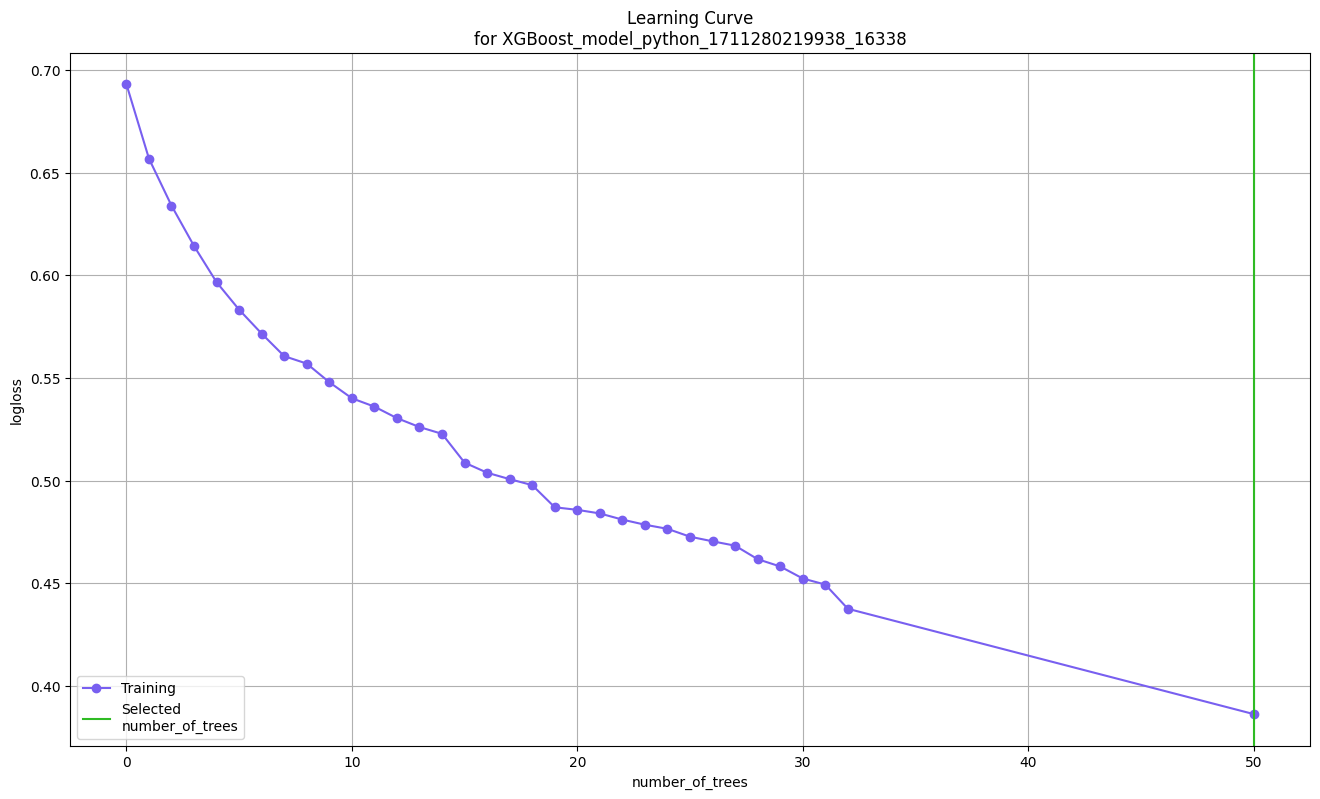

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

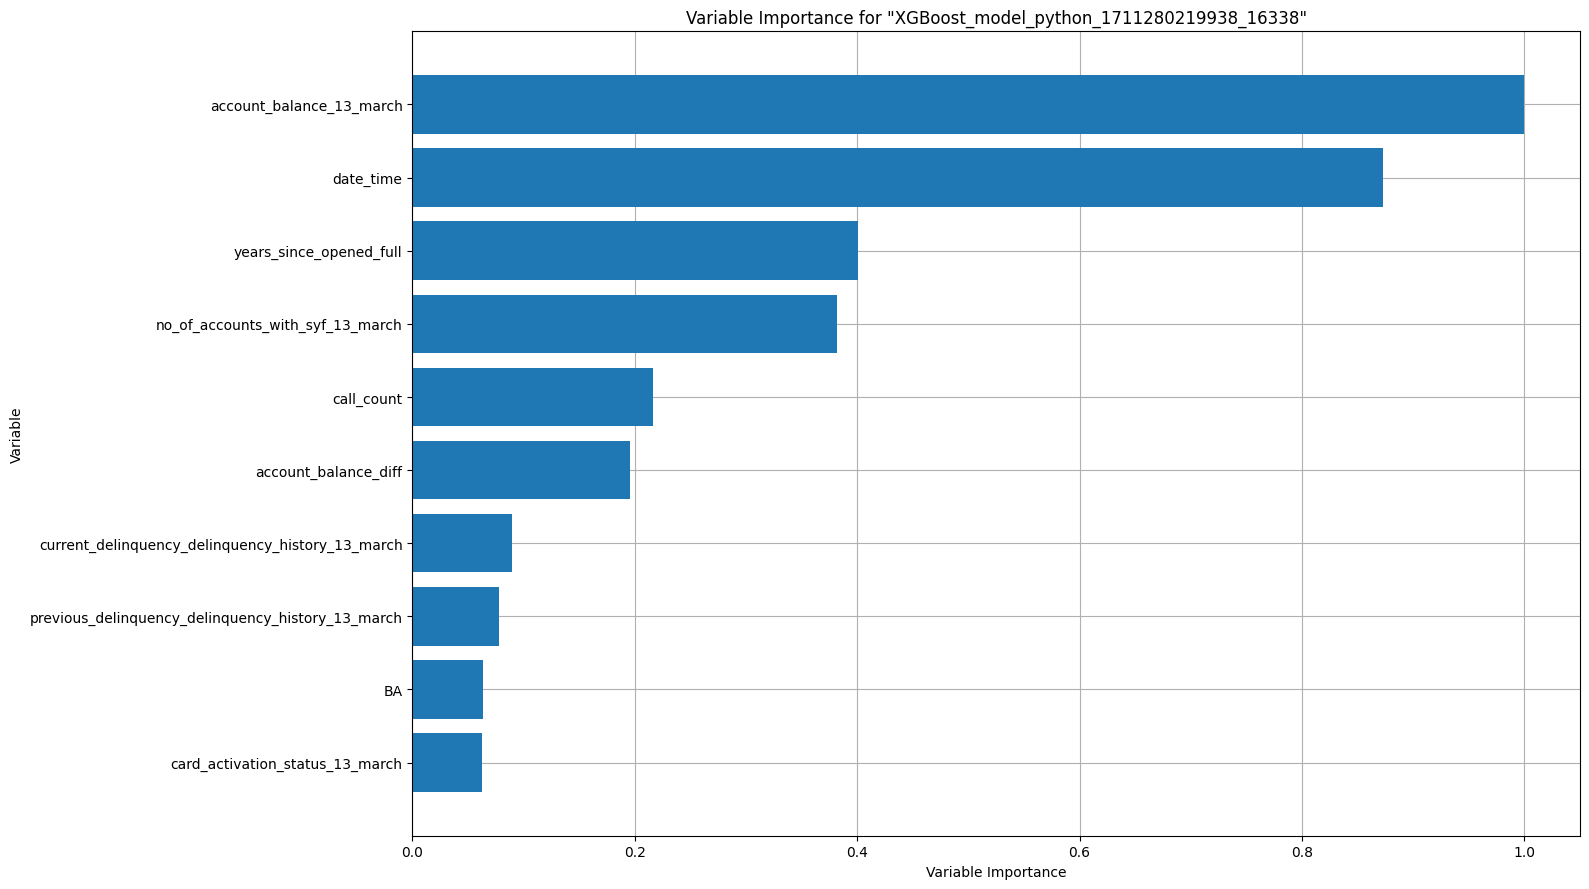

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

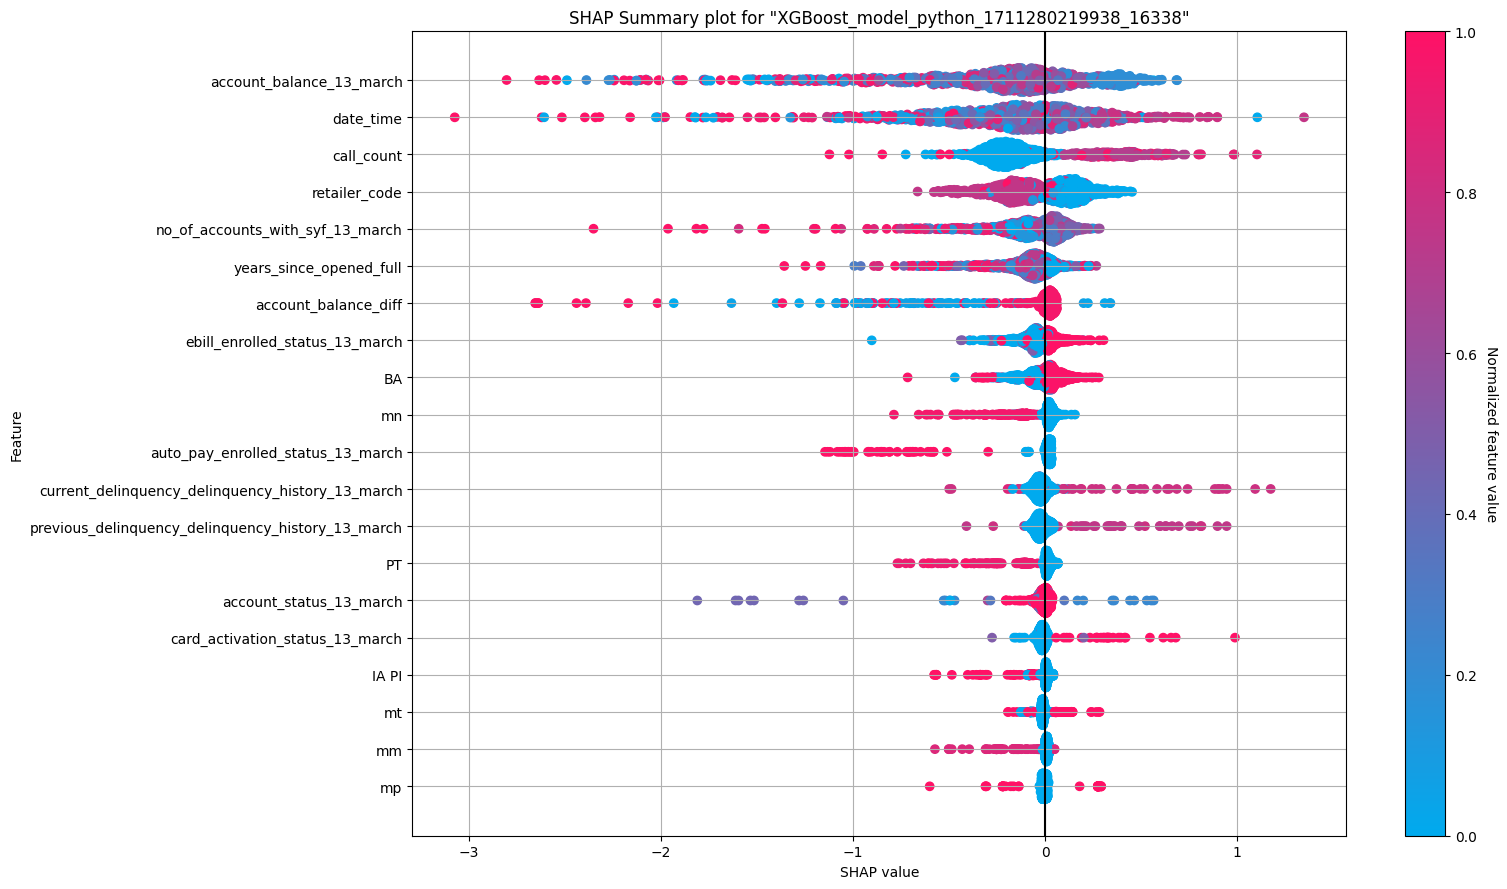

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

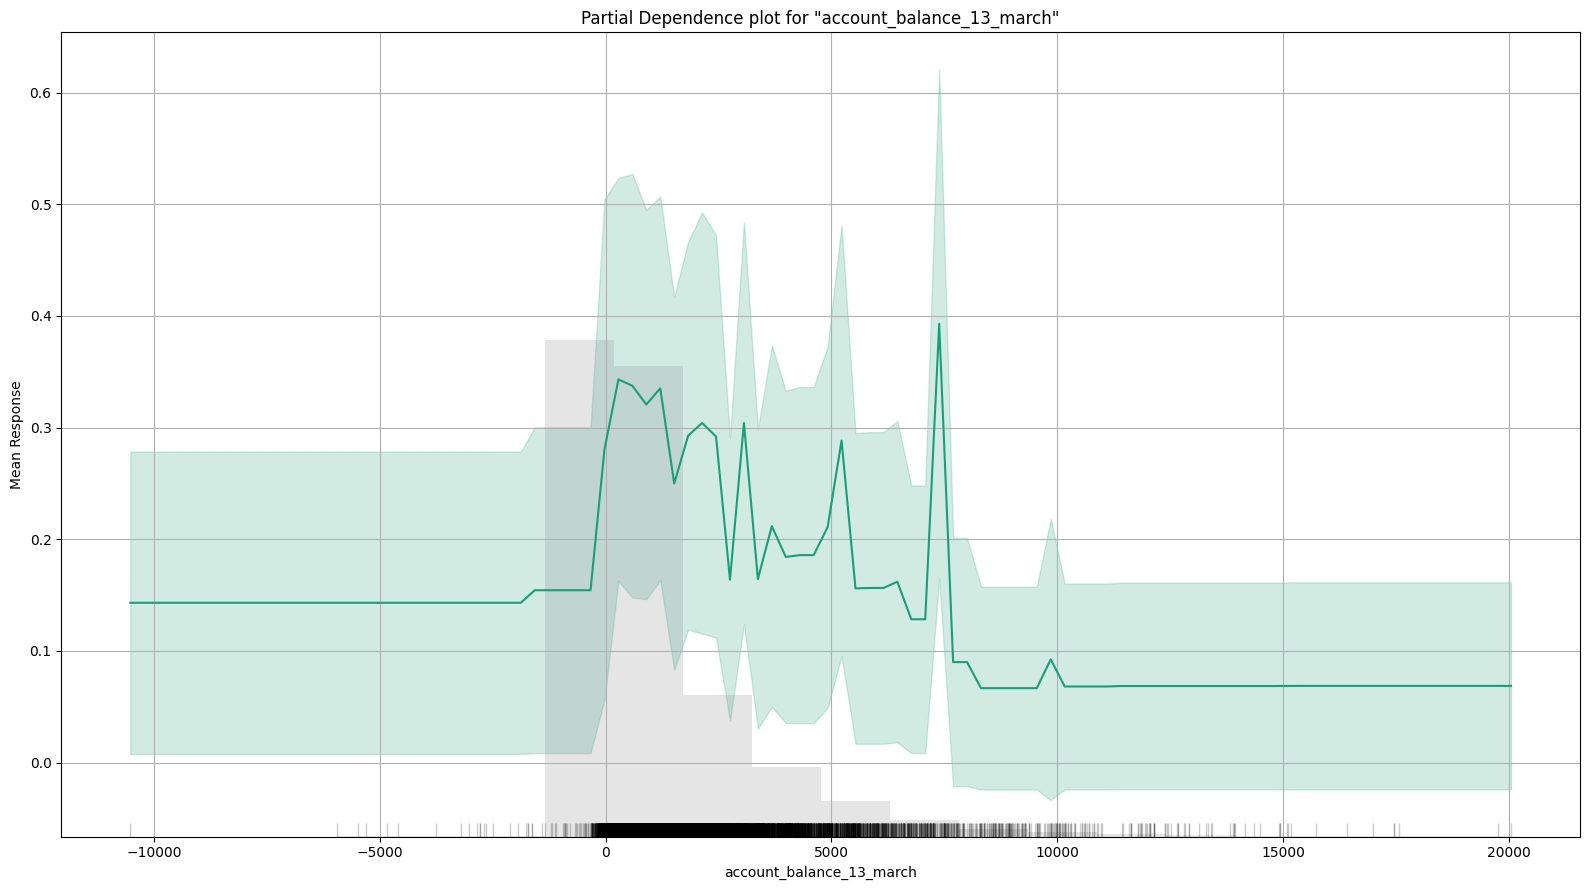

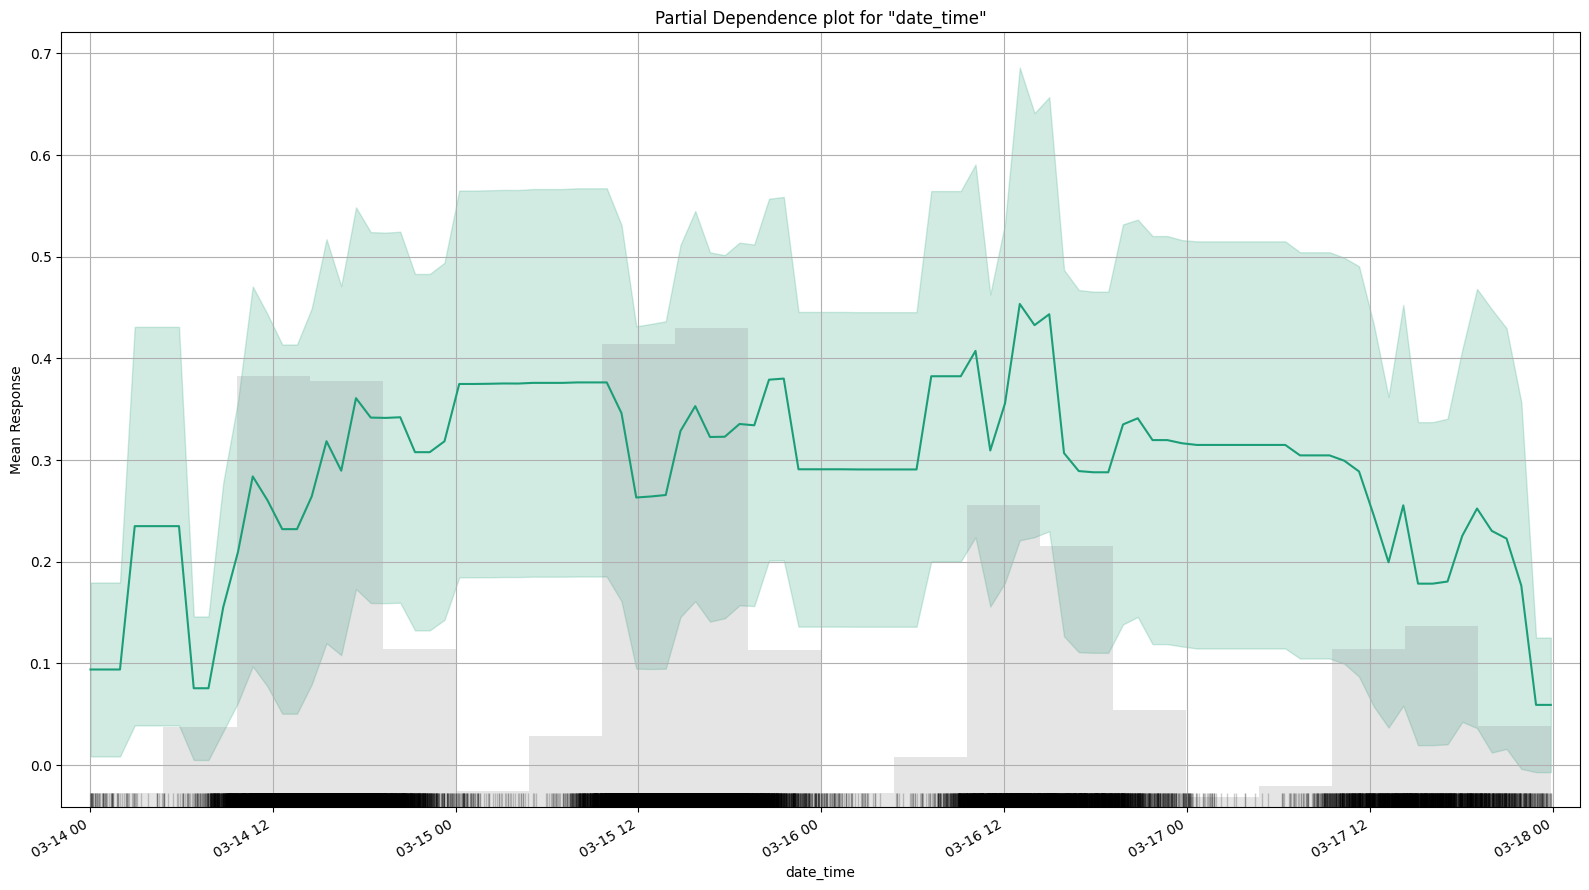

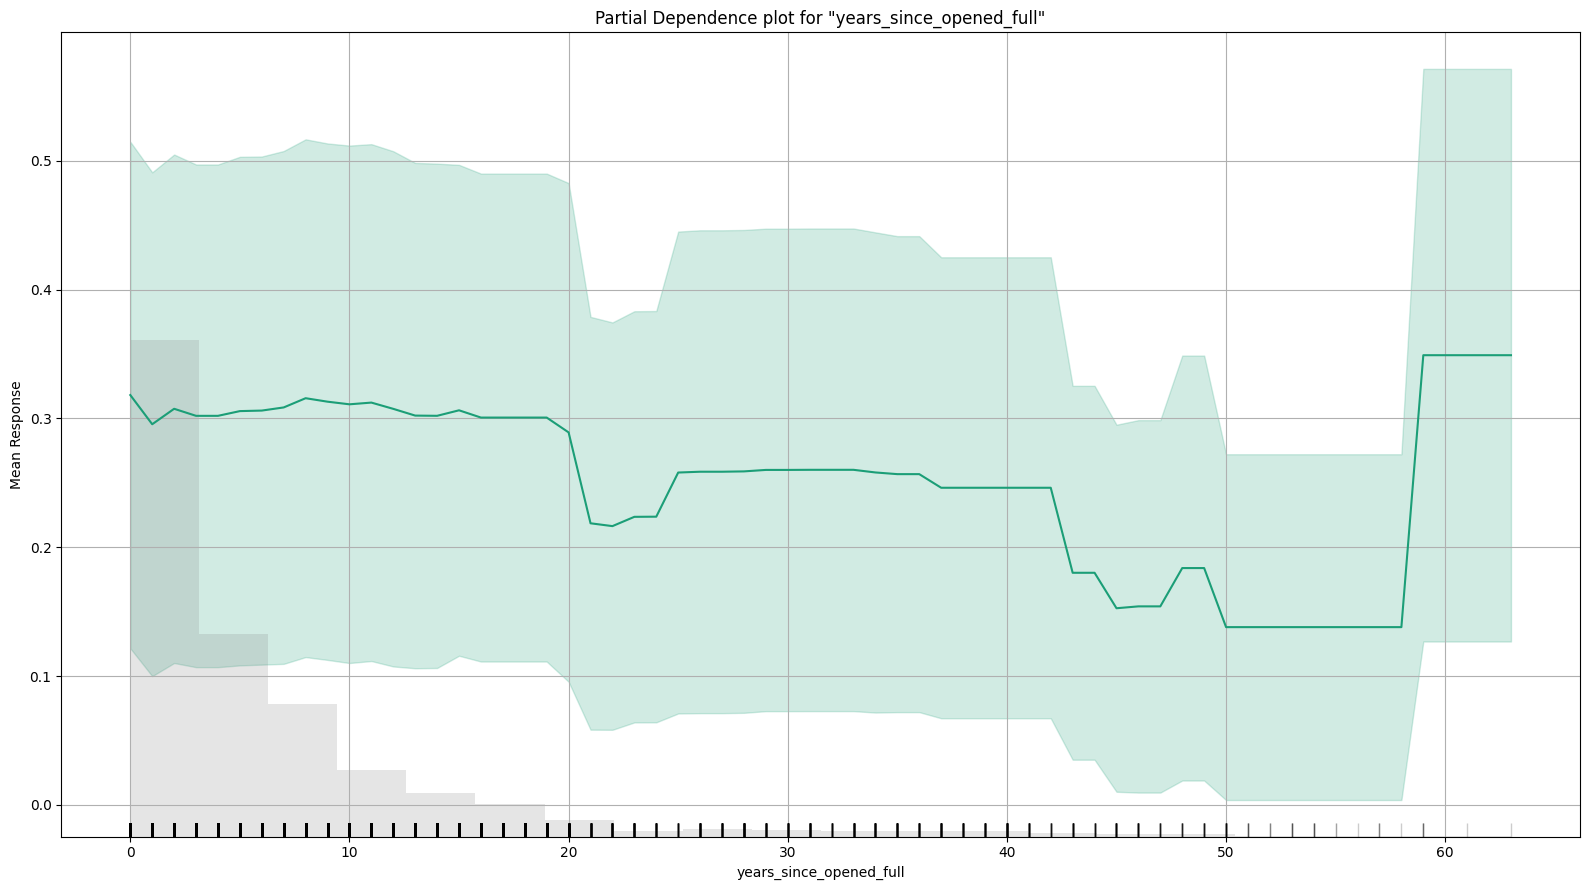

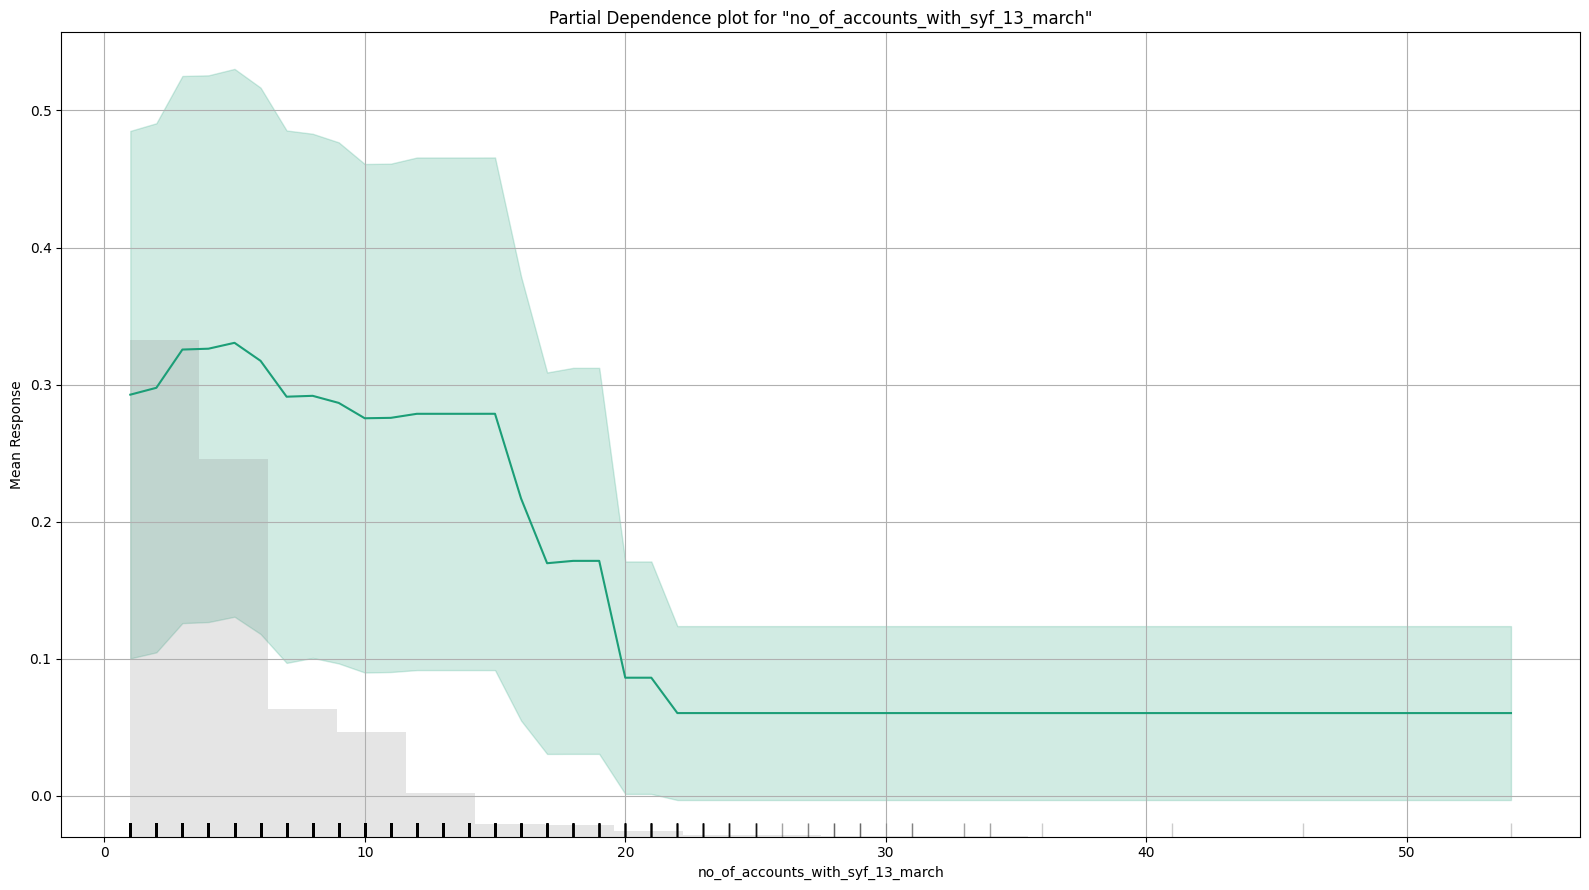

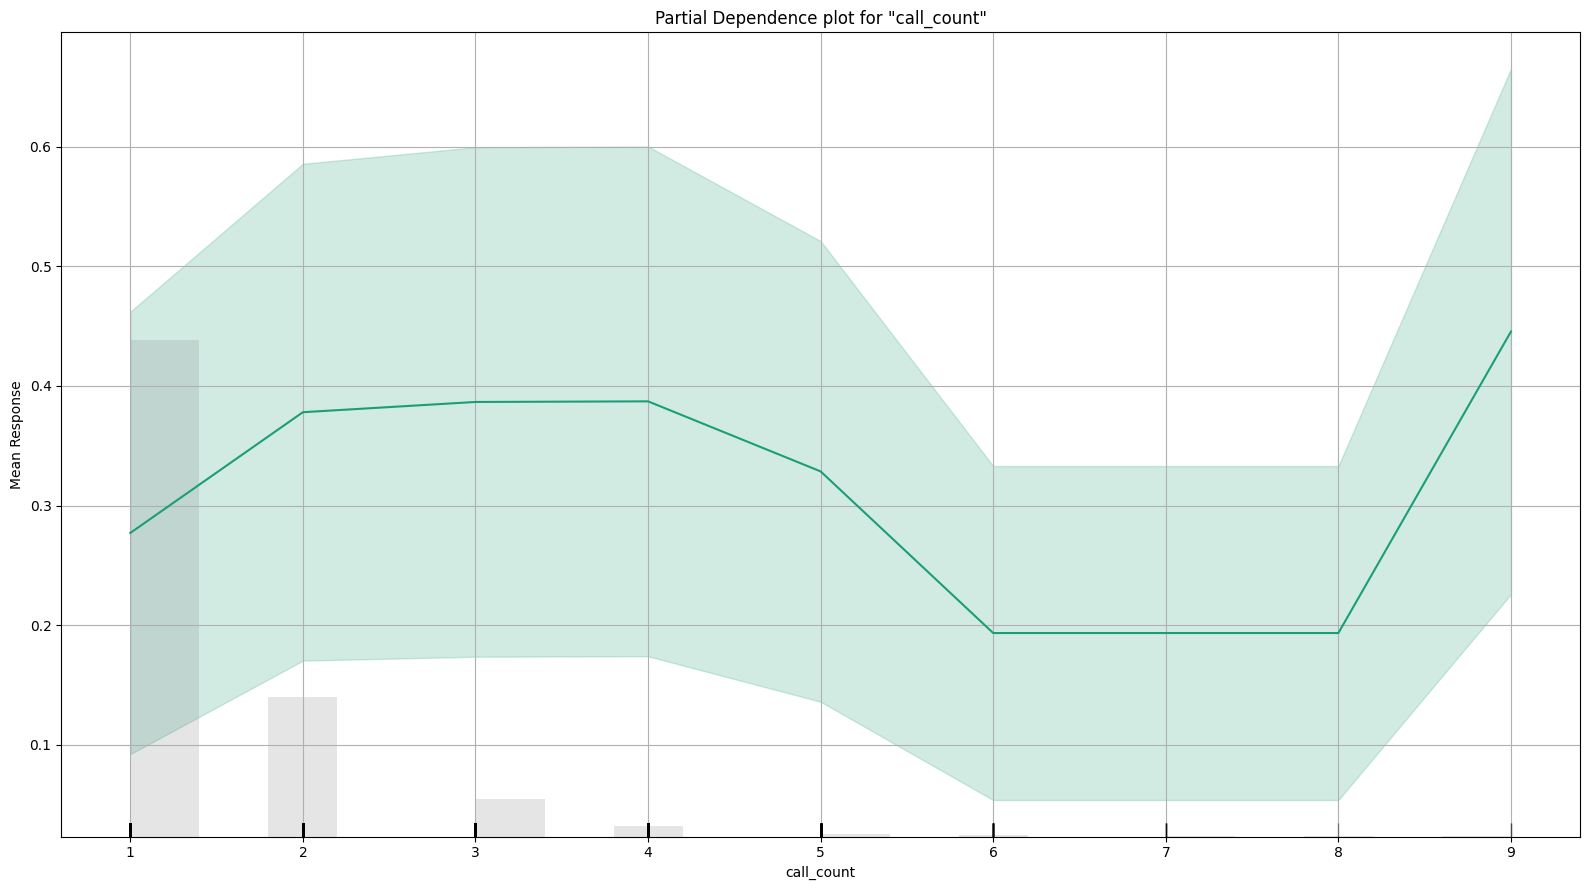



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada189bb970>), ('description', <h2o.explanation._explain.Description object at 0x7ad9d22bed10>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711280219938_16338', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ad9d20114b0>), ('plots', H2OExplanation([('XGBoost_model_python_1711280219938_16338', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.72649295706498', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ad9d2013850>), ('description', <h2o.explanation._explain.Description object at 0x7ad9d20113f0>), ('plots', H2OExplanation([('XGBoost_model_python_1711280219938_16338', <h2o.plot._plot_result._MObject object at 0x7ada02c8de70>)]))])), ('varimp', H2OExp

In [93]:
explanation = mdl_CT.explain(train)
print(explanation)

grid search mdl

In [80]:
sampled_data = auto_df[auto_df['reason'] == "CT"]

train,test,valid = sampled_data.split_frame(ratios=[.6, .2], seed = 2018)

# GBM hyperparameters
gbm_params_CT = {'learn_rate': [0.1, 0.2, 0.3],
               'max_depth': [6, 9, 12],
               'sample_rate': [ 0.8, 0.9, 1.0],
                }

# Train and validate a cartesian grid of GBMs
gbm_grid_CT = H2OGridSearch(model=H2OXGBoostEstimator,
                          grid_id='gbm_grid_CT',
                          hyper_params=gbm_params_CT)

class_counts_df = train[response].asfactor().table().as_data_frame()
class_ratio = class_counts_df['Count'].iloc[0] / class_counts_df['Count'].iloc[1]

gbm_grid_CT.train(x=predictor, y=response,
                training_frame=train,
                validation_frame=valid,
                ntrees=50,
                scale_pos_weight=class_ratio,
                seed=1)

# Get the grid results, sorted by validation AUC
gbm_gridperf_CT = gbm_grid_CT.get_grid(sort_by='auc', decreasing=True)
gbm_gridperf_CT

# Grab the top GBM model, chosen by validation AUC
best_gbm_CT = gbm_gridperf_CT.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf_CT = best_gbm_CT.model_performance(test)

best_gbm_perf_CT.auc()
# 0.7781778619721595

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Grid Build progress: |███████████████████████████████████████████████████| (done) 100%


0.5937617710158694

In [81]:
my_param = ['max_depth', 'learn_rate', 'sample_rate', 'scale_pos_weight', 'colsample_bytree']
params = best_gbm_CT.params
for param in my_param:
  print(f"{param}:{params[param]}\n")

max_depth:{'default': 6, 'actual': 6, 'input': 6}

learn_rate:{'default': 0.3, 'actual': 0.1, 'input': 0.1}

sample_rate:{'default': 1.0, 'actual': 1.0, 'input': 1.0}

scale_pos_weight:{'default': 1.0, 'actual': 1.0, 'input': 1.0}

colsample_bytree:{'default': 1.0, 'actual': 1.0, 'input': 1.0}



In [ ]:
#performance on test
performance = best_gbm_CT.model_performance(test)
print(best_gbm_CT)
print(performance)

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## gbm_grid_CT_model_19

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08573171496391296
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     11623    196         0.0166   (196.0/11819.0)
resolved  165      210         0.44     (165.0/375.0)
Total     11788    406         0.0296   (361.0/12194.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

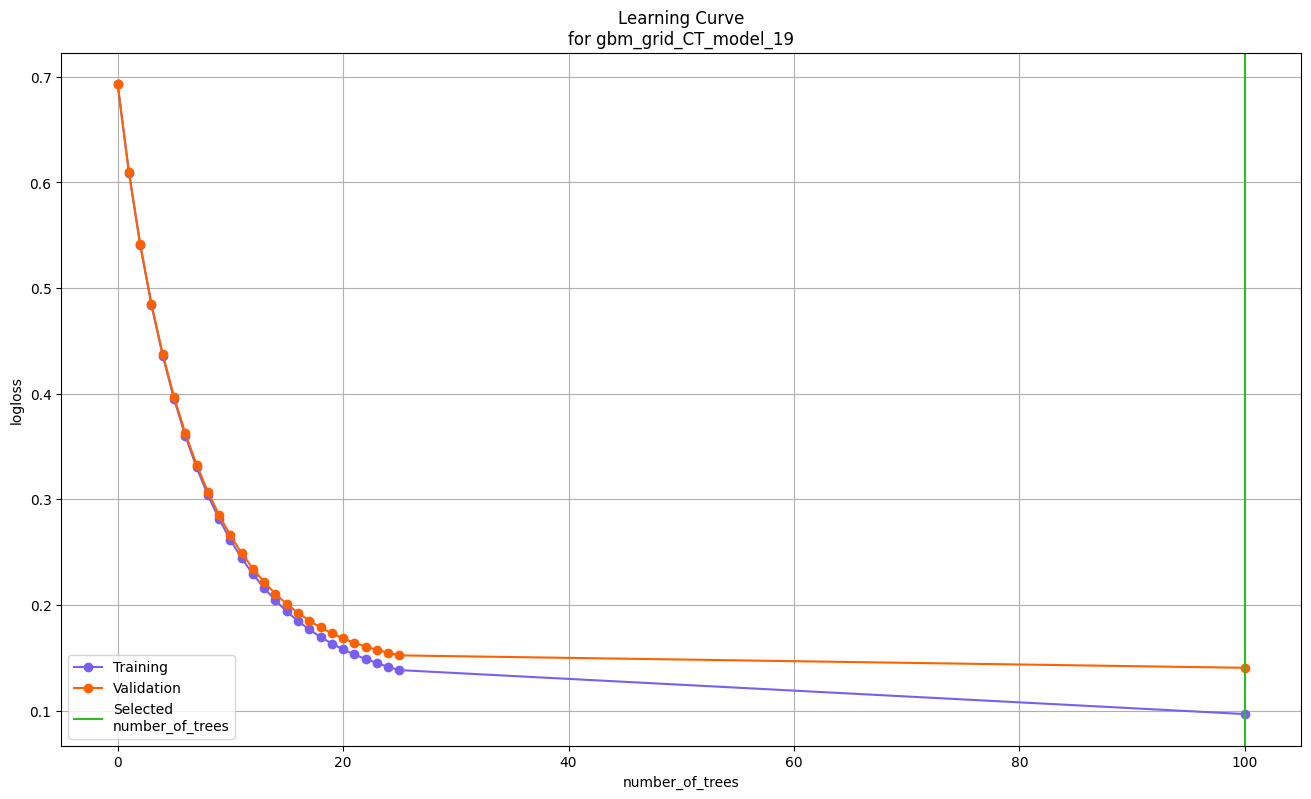

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

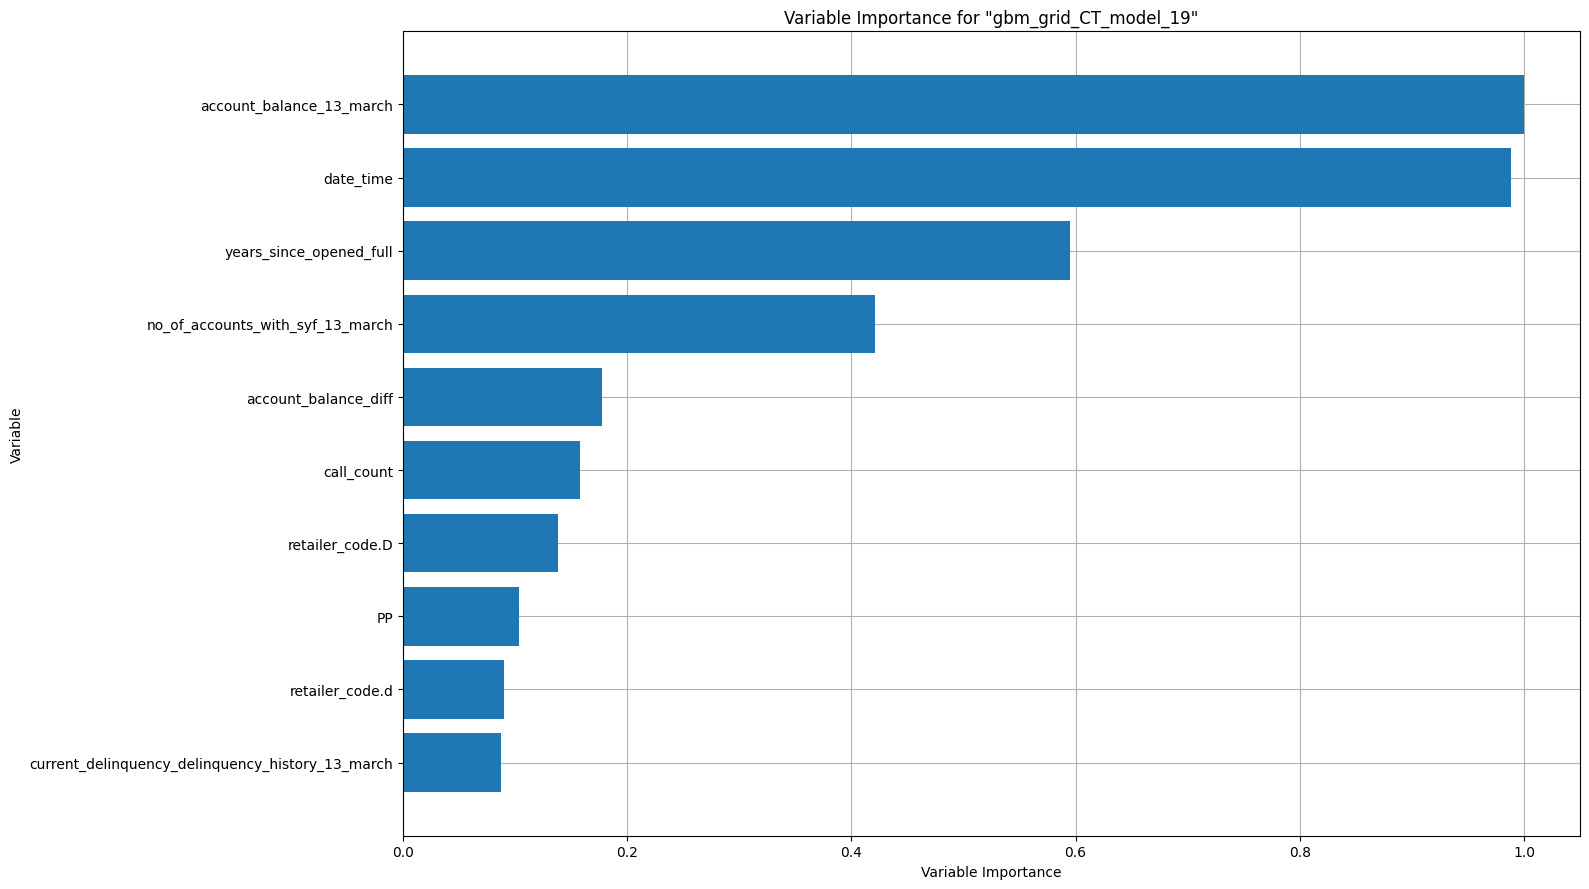

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

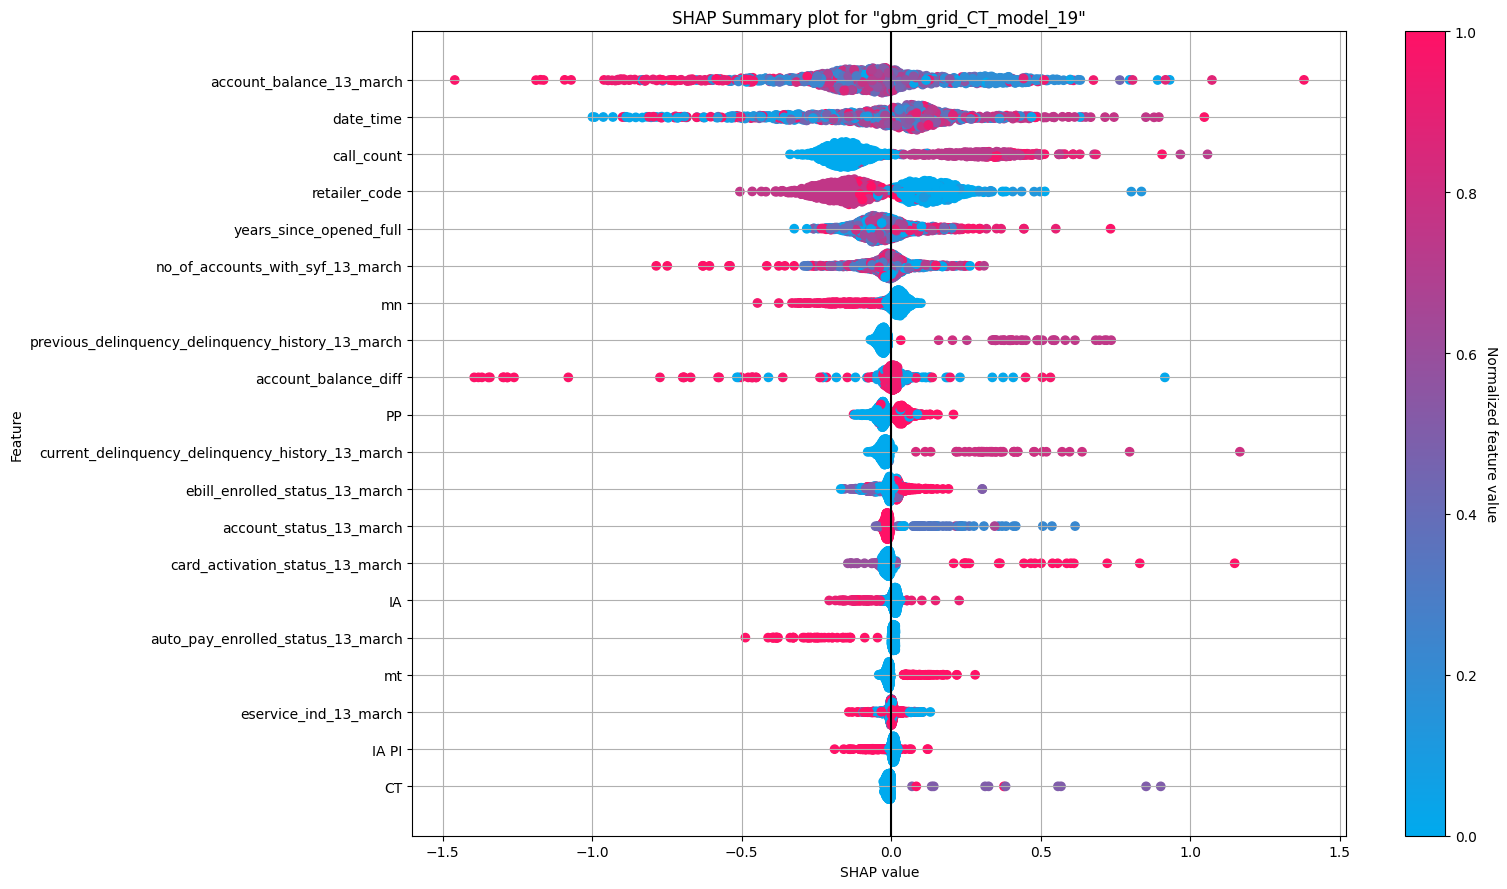

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

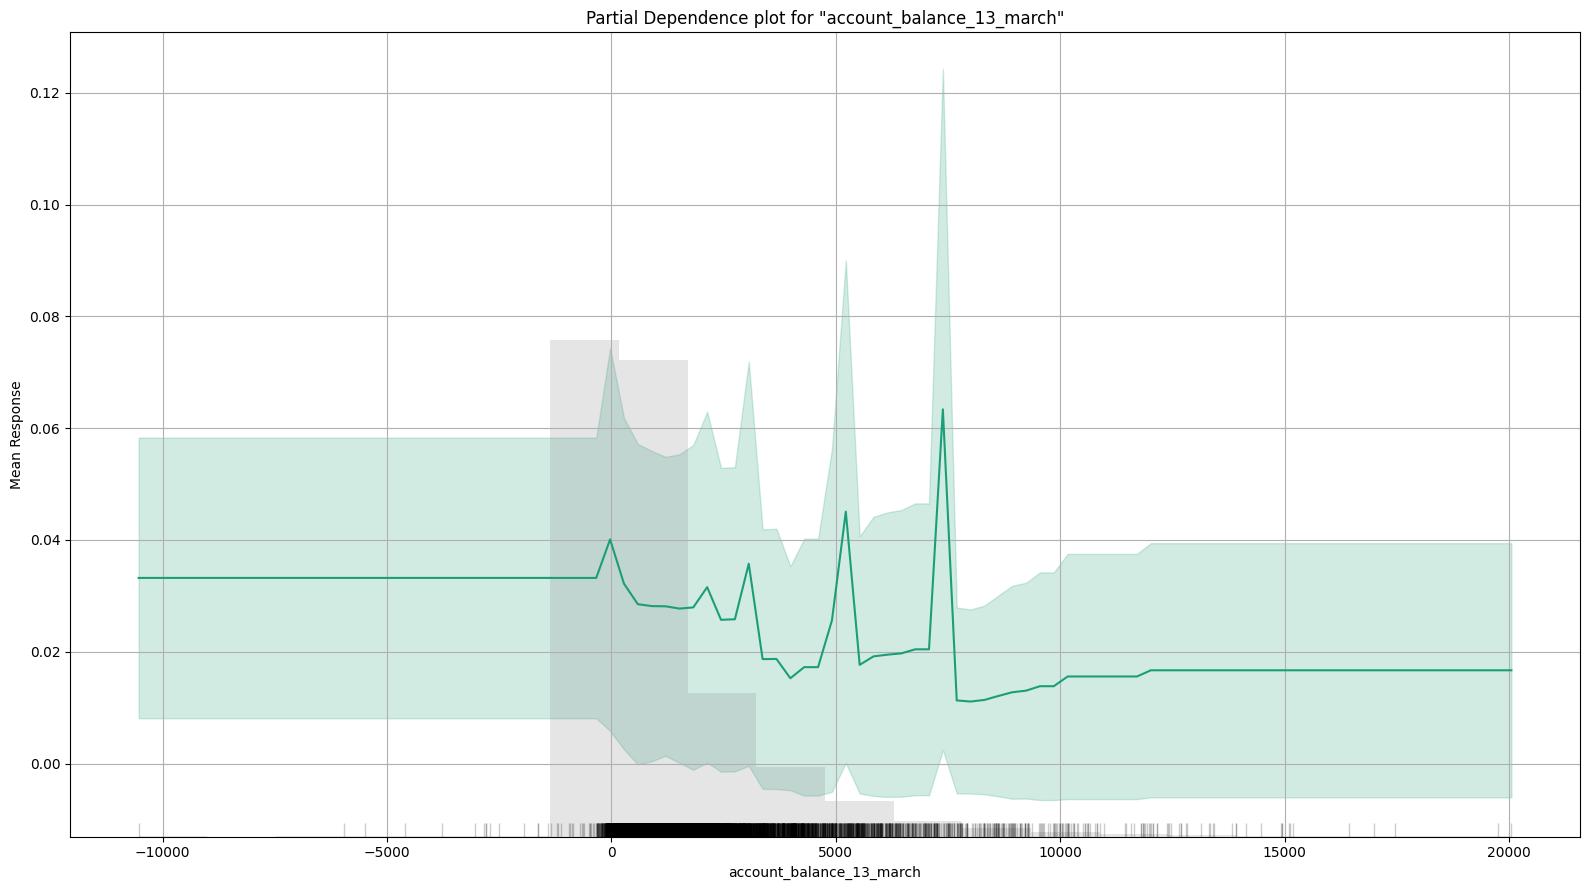

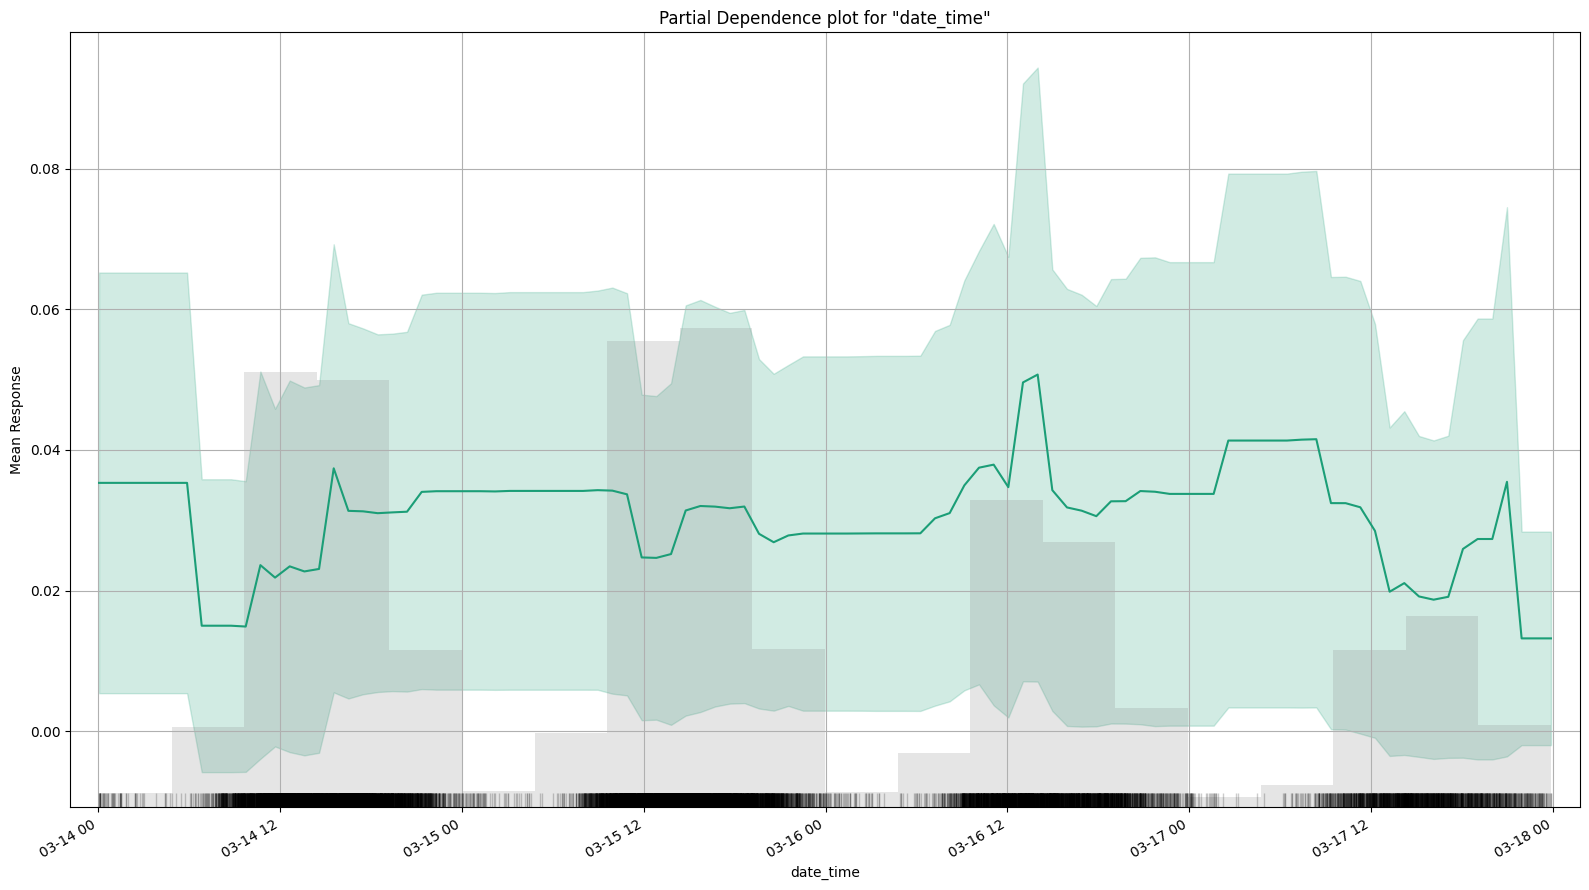

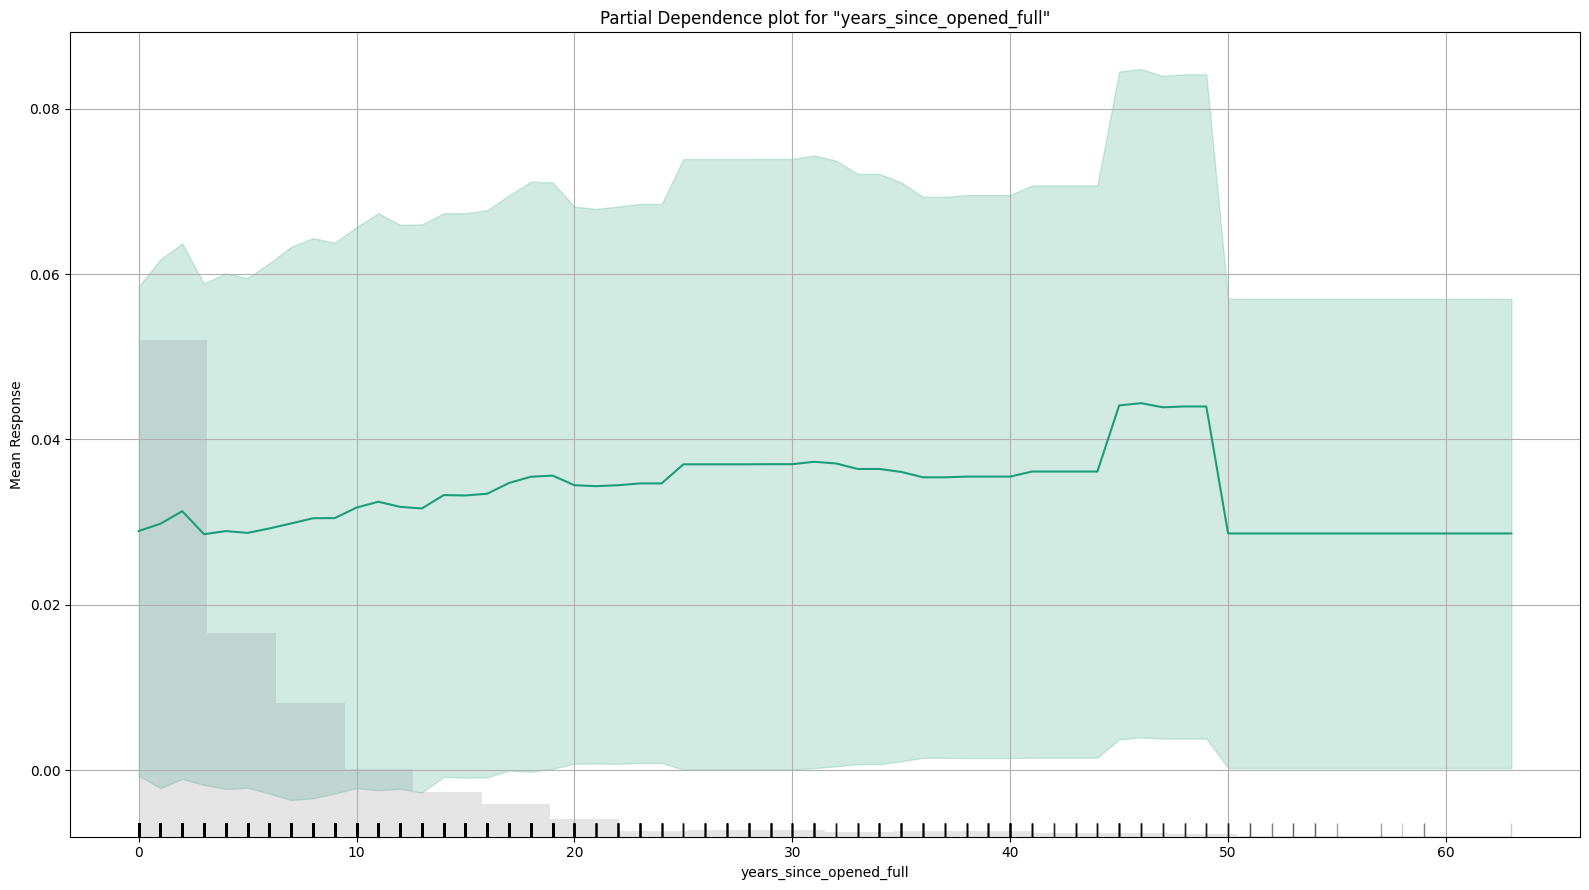

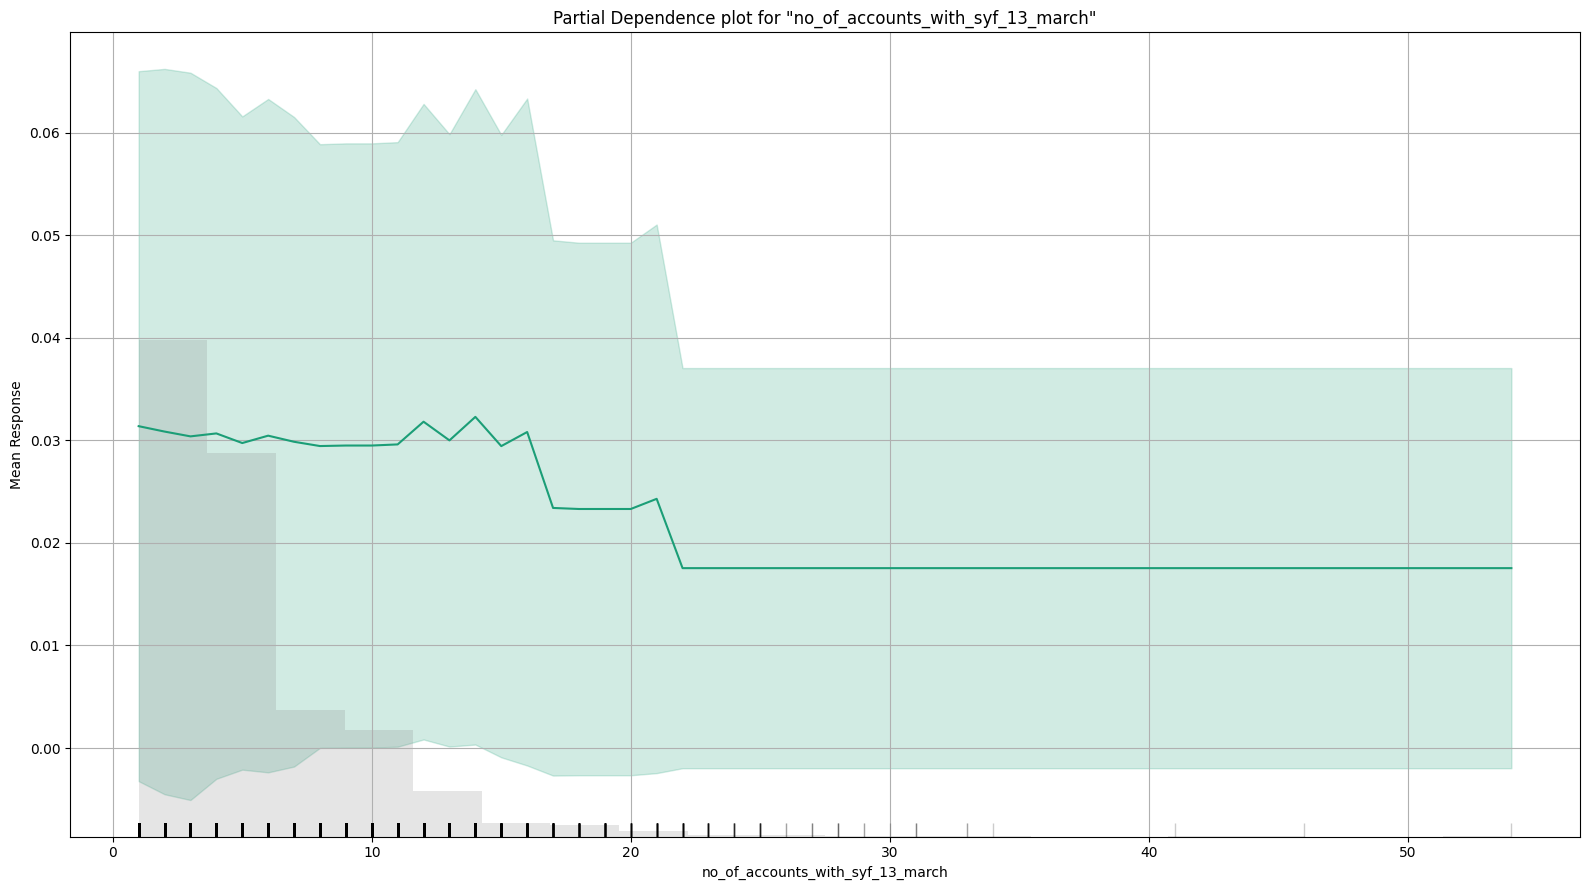

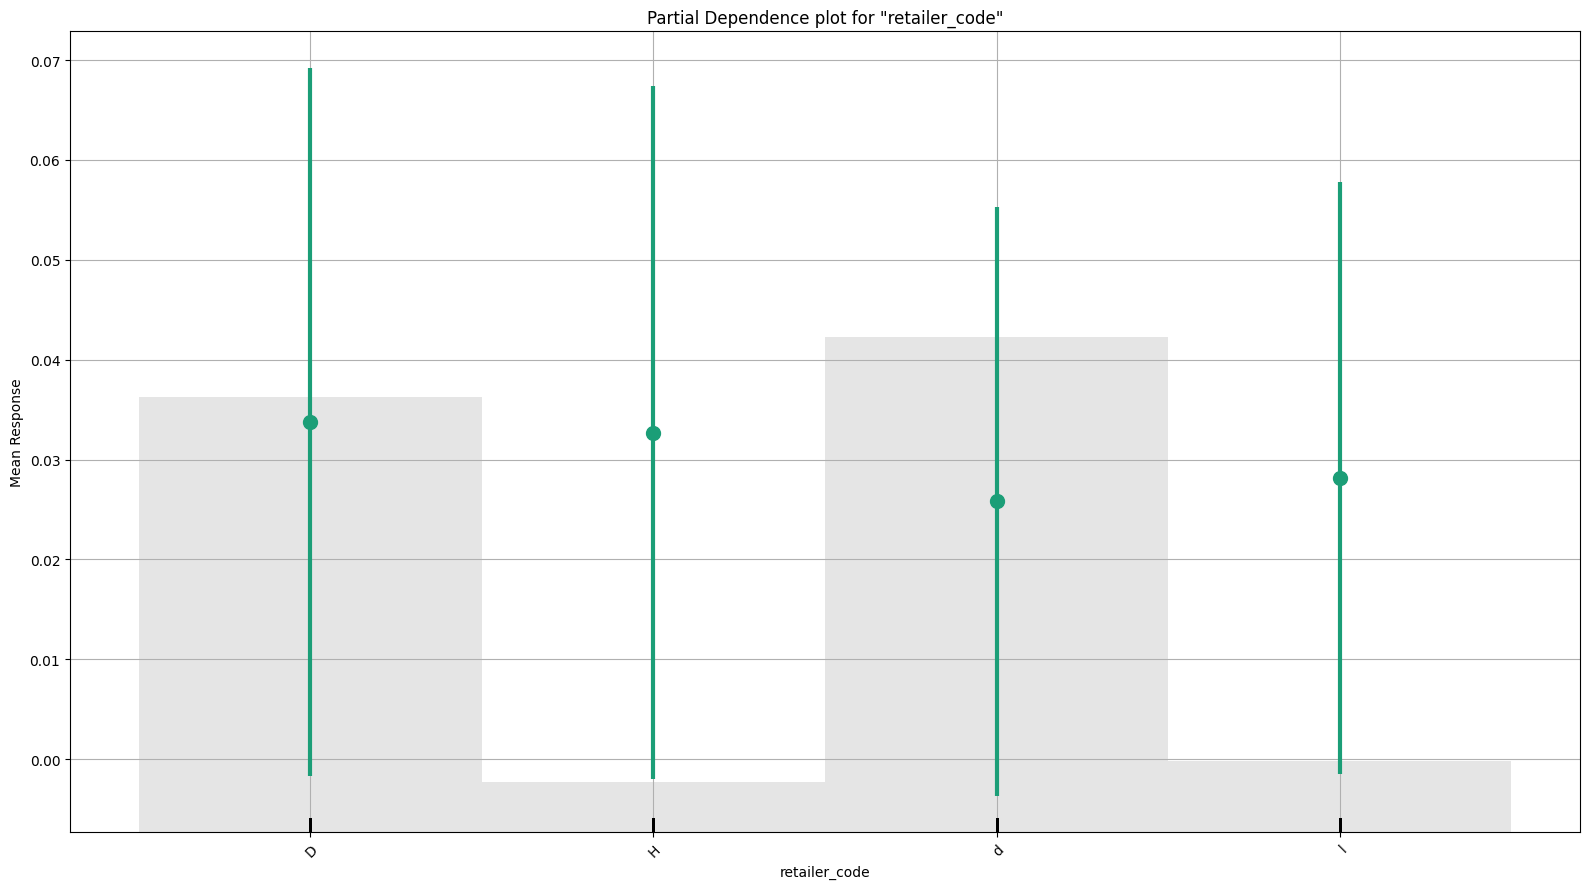



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ad9d451c580>), ('description', <h2o.explanation._explain.Description object at 0x7ada03c76110>), ('subexplanations', H2OExplanation([('gbm_grid_CT_model_19', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada31fa7c10>), ('plots', H2OExplanation([('gbm_grid_CT_model_19', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08573171496391296', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada03c74610>), ('description', <h2o.explanation._explain.Description object at 0x7ad9d45fdde0>), ('plots', H2OExplanation([('gbm_grid_CT_model_19', <h2o.plot._plot_result._MObject object at 0x7ada0346cca0>)]))])), ('varimp', H2OExplanation([('header', <h2o.explanation._explain.Header obj

In [70]:
explanation = best_gbm_CT.explain(train)
print(explanation)

#### wa XGB

In [86]:
# Filter data based on reason
sampled_data = auto_df[auto_df['reason'] == "wa"]

# Split the data into train and test sets
splits = sampled_data.split_frame(ratios=[0.8], seed=2018)
train = splits[0]
test = splits[1]

# Convert the response column to a categorical factor
train[response] = train[response].asfactor()
test[response] = test[response].asfactor()
class_counts_df = train[response].asfactor().table().as_data_frame()
# Assuming the minority class is at index 1 and the majority class is at index 0
class_ratio = class_counts_df['Count'].iloc[0] / class_counts_df['Count'].iloc[1]

# Initialize and train the XGBoost model with scale_pos_weight parameter
mdl_wa = H2OXGBoostEstimator(scale_pos_weight=class_ratio)
mdl_wa.train(x=predictor, y=response, training_frame=train)

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [IA IC, reason, FI PP, AA RC, iO, HI mm, AP mm, iS, FI PI, LW, iT, LS mm, RI mm, eS, eB mm, CT wa, HI IA, AA mm, eY mm, AA mt, DE wa, iS mm, HI LS, GA mm, mP wa, eR mm, Ls, IA PS, ER, IA LS, PI mm, IA LW, DR PT, AA PT, AU mm, AA LW, Pd mm, VP, mo wa, AA iR, iT mm, FD, AA CT, RV, IA SR, NU, IA SP, eS mm, FR, mp wa, GA wa, iM mm, eP mm, FM mm, HI PP, AA GA, FI IA, eA mm, RP mm, NU mm, CA mm, FM IA, VA mm, IA NU, AA SP, CS, PP SP, PP SR, mm wa, CT mm, LW PI, mP mm, iR mm, iF]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711280219938_16293


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12446246769709739
RMSE: 0.3527923861098725
LogLoss: 0.3962939965628563
Mean Per-Class Error: 0.1965747110931247
AUC: 0.9457628240678289
AUCPR: 0.6423959844338569
Gini: 0.8915256481356577

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6759253018780759
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     9150     381         0.04     (381.0/9531.0)
resolved  267      489         0.3532   (267.0/756.0)
Total     9417     870         0.063    (648.0/10287.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.675925     0.601476  69
max f2                       0.588006     0.683602  104
max f0point5                 0.760721     0.629139  41
max accuracy                 0.760721     0.945271  41
max precision                0.933047     1         0
max recall                   0.190632     1         291
max specificity              0.933047     1         0
max absolute_mcc             0.675925     0.56911   69
max min_per_class_accuracy   0.551667     0.868534  119
max mean_per_class_accuracy  0.513672     0.871867  136
max tns                      0.933047     9531      0
max fns                      0.933047     754       0
max fps                      0.00275962   9531      399
max tps                      0.190632     756       291
max tnr                      0.933047     1         0
max fnr                      0.933047     0.997354  0
max fpr                      0.00275962   1         399
max tpr                      0.190632     1         291

Gains/Lift Table: Avg response rate:  7.35 %, avg score: 32.47 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100126                   0.845242           12.6824    12.6824            0.932039         0.878313   0.932039                    0.878313            0.126984        0.126984                   1168.24   1168.24            0.12625
2        0.0200253                   0.81114            10.0402    11.3613            0.737864         0.826814   0.834951                    0.852563            0.100529        0.227513                   904.022   1036.13            0.223946
3        0.0300379                   0.784511           9.24757    10.6567            0.679612         0.796672   0.783172                    0.833933            0.0925926       0.320106                   824.757   965.673            0.313076
4        0.0400505                   0.760206           7.92649    9.97417            0.582524         0.773327   0.73301                     0.818781            0.0793651       0.399471                   692.649   897.417            0.38793
5        0.0500632                   0.741203           6.4733     9.27399            0.475728         0.750104   0.681553                    0.805046            0.0648148       0.464286                   547.33    827.399            0.447079
6        0.100029                    0.650923           4.60631    6.94242            0.338521         0.692239   0.510204                    0.748697            0.230159        0.694444                   360.631   594.242            0.641564
7        0.149995          

In [87]:
performance = mdl_wa.model_performance(test)
print(performance)

ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.15390614619089593
RMSE: 0.3923087383565346
LogLoss: 0.4689870473655412
Mean Per-Class Error: 0.39835622352892797
AUC: 0.658311145606316
AUCPR: 0.11772532683415636
Gini: 0.31662229121263197

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5822144031524659
          floor    resolved    Error    Rate
--------  -------  ----------  -------  --------------
floor     2058     286         0.122    (286.0/2344.0)
resolved  112      54          0.6747   (112.0/166.0)
Total     2170     340         0.1586   (398.0/2510.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.582214     0.213439  91
max f2                       0.407781     0.317881  178
max f0point5                 0.685967     0.178082  49
max accuracy                 0.889594     0.933068  0
max prec

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711280219938_16293

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6759253018780759
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     9150     381         0.04     (381.0/9531.0)
resolved  267      489         0.3532   (267.0/756.0)
Total     9417     870         0.063    (648.0/10287.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

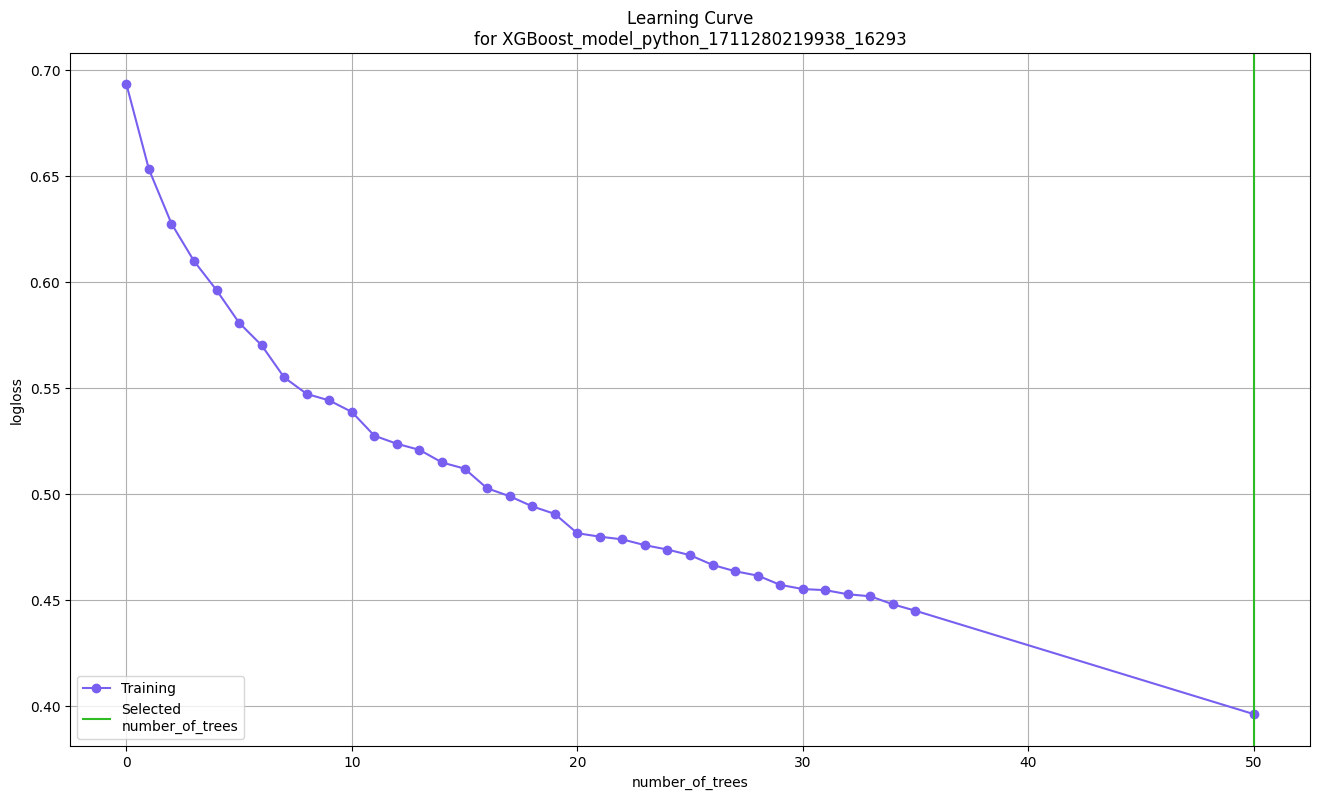

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

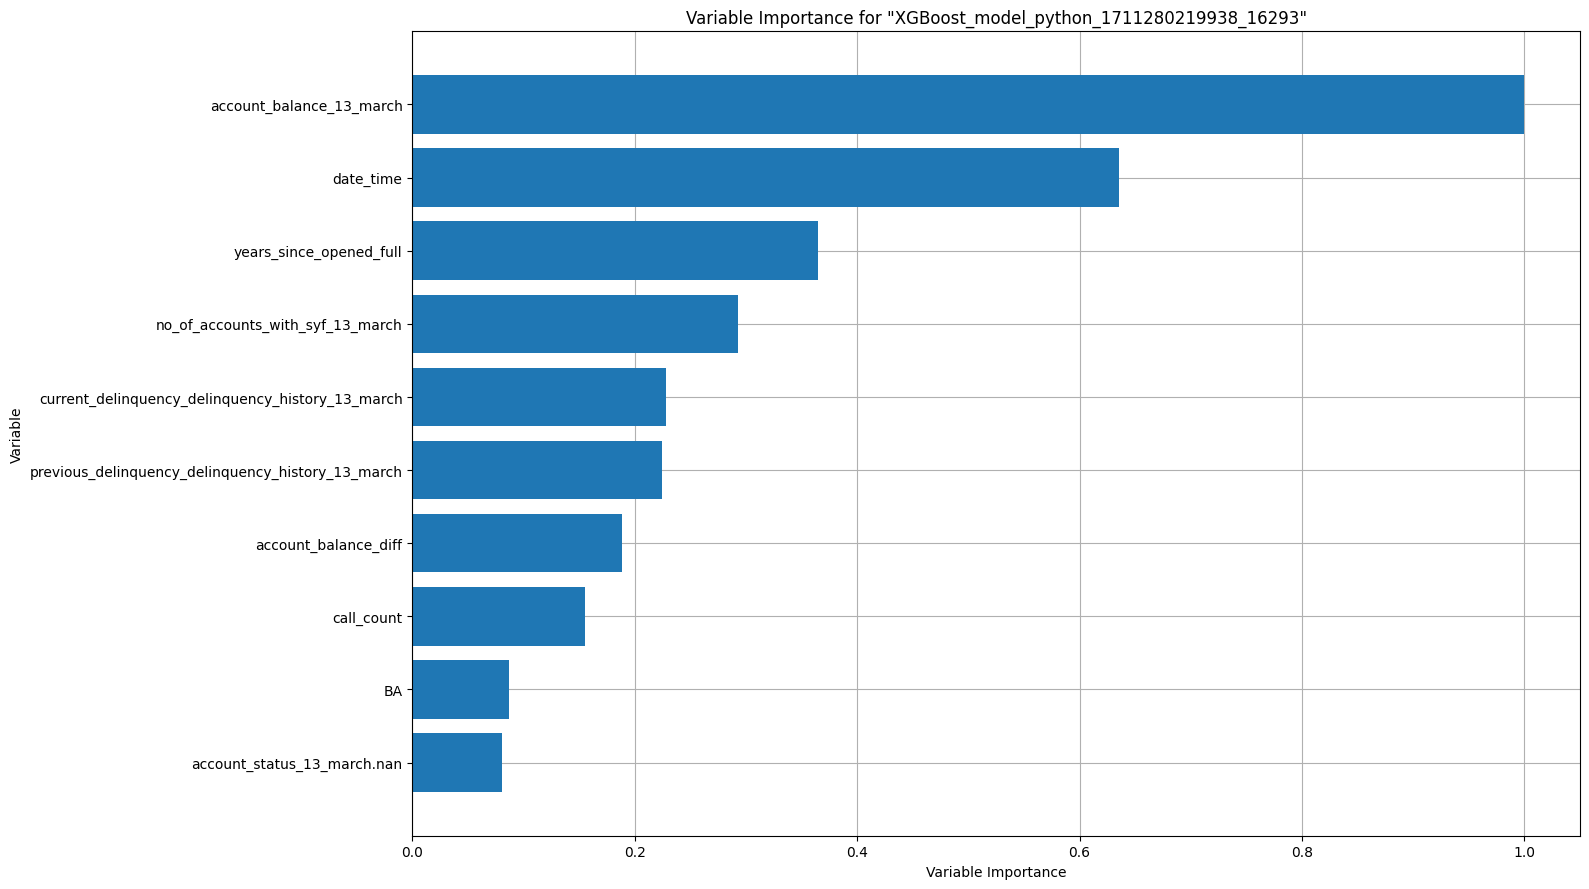

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

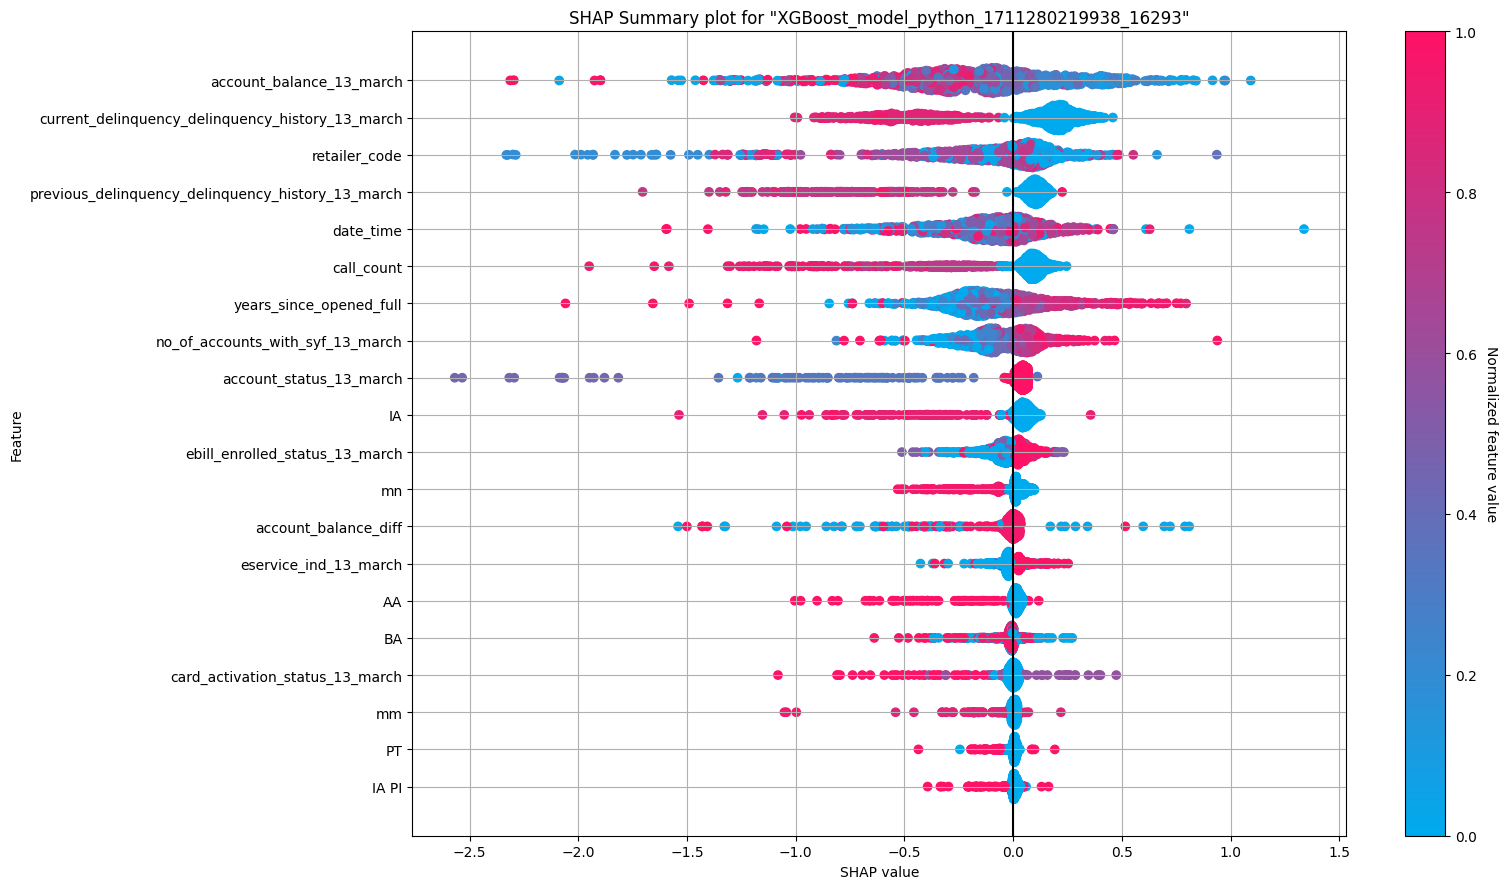

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

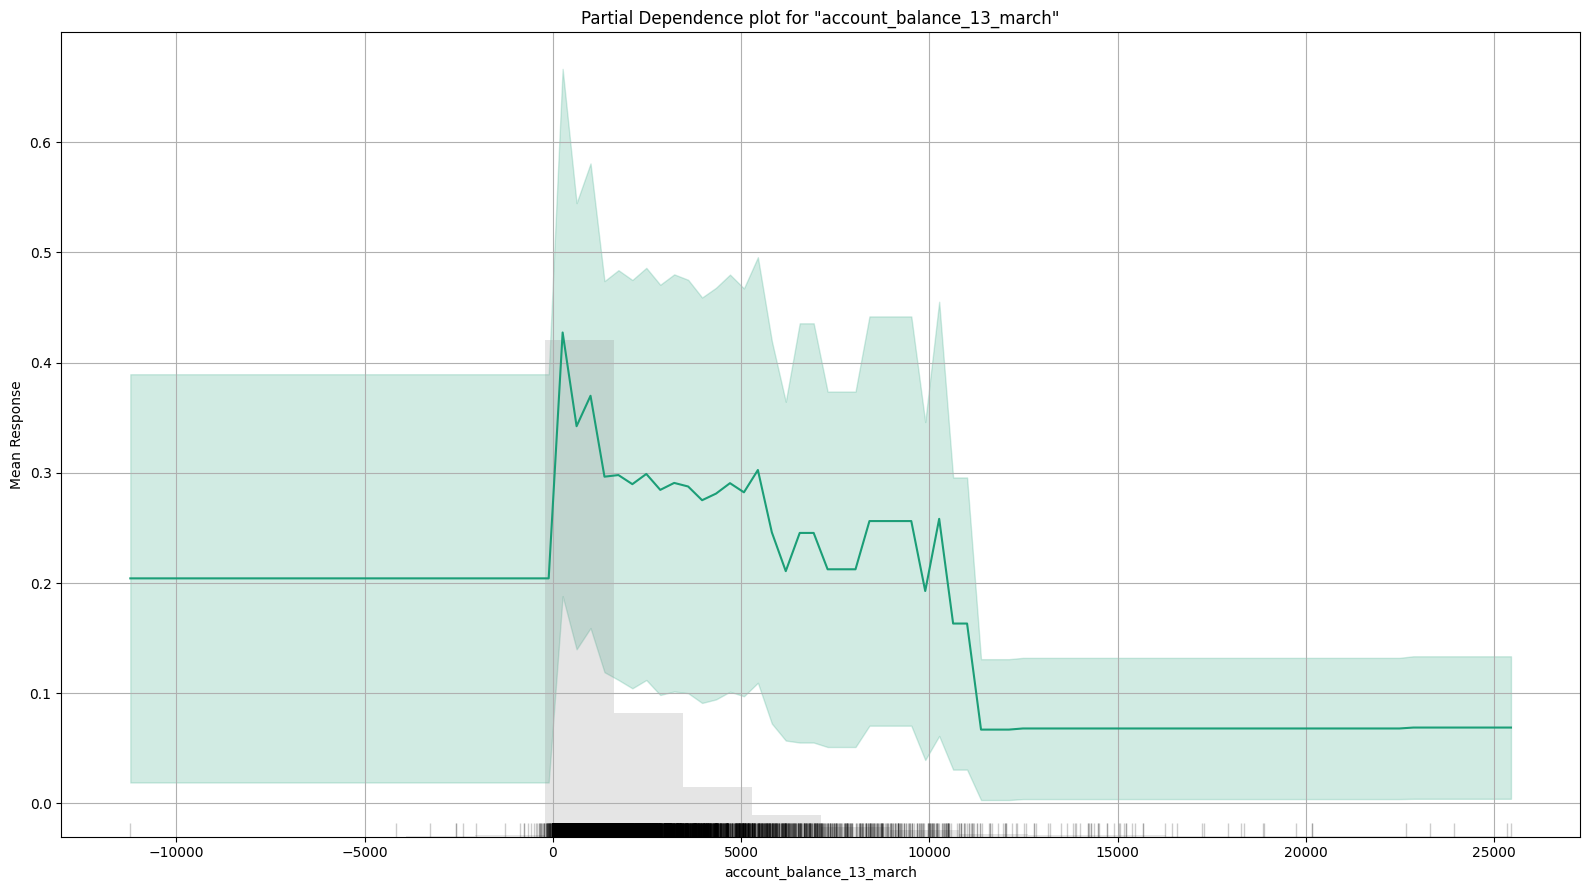

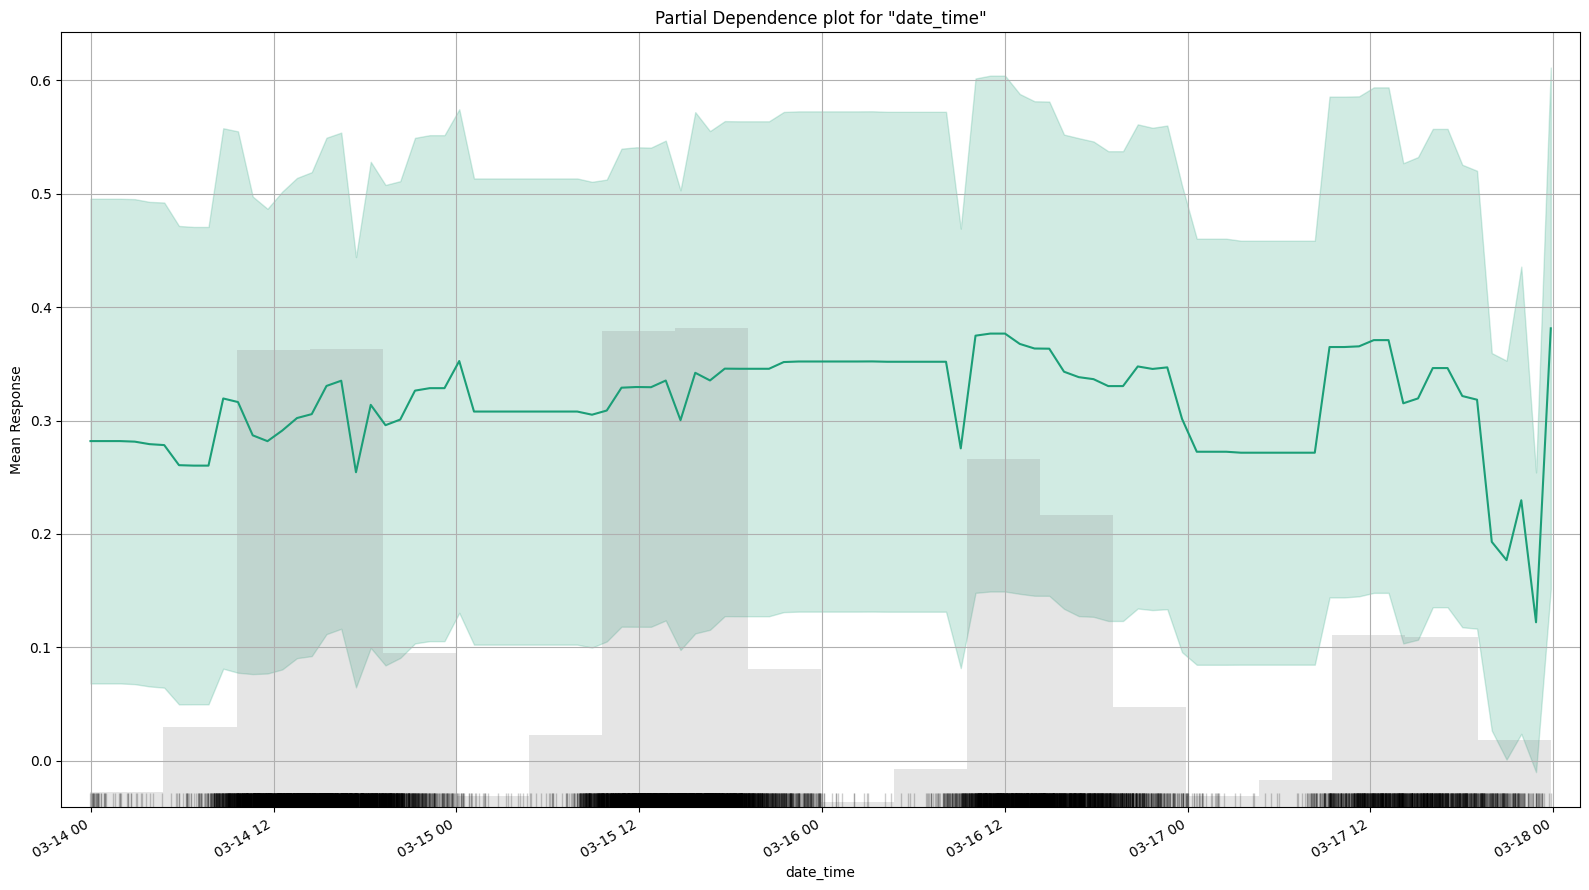

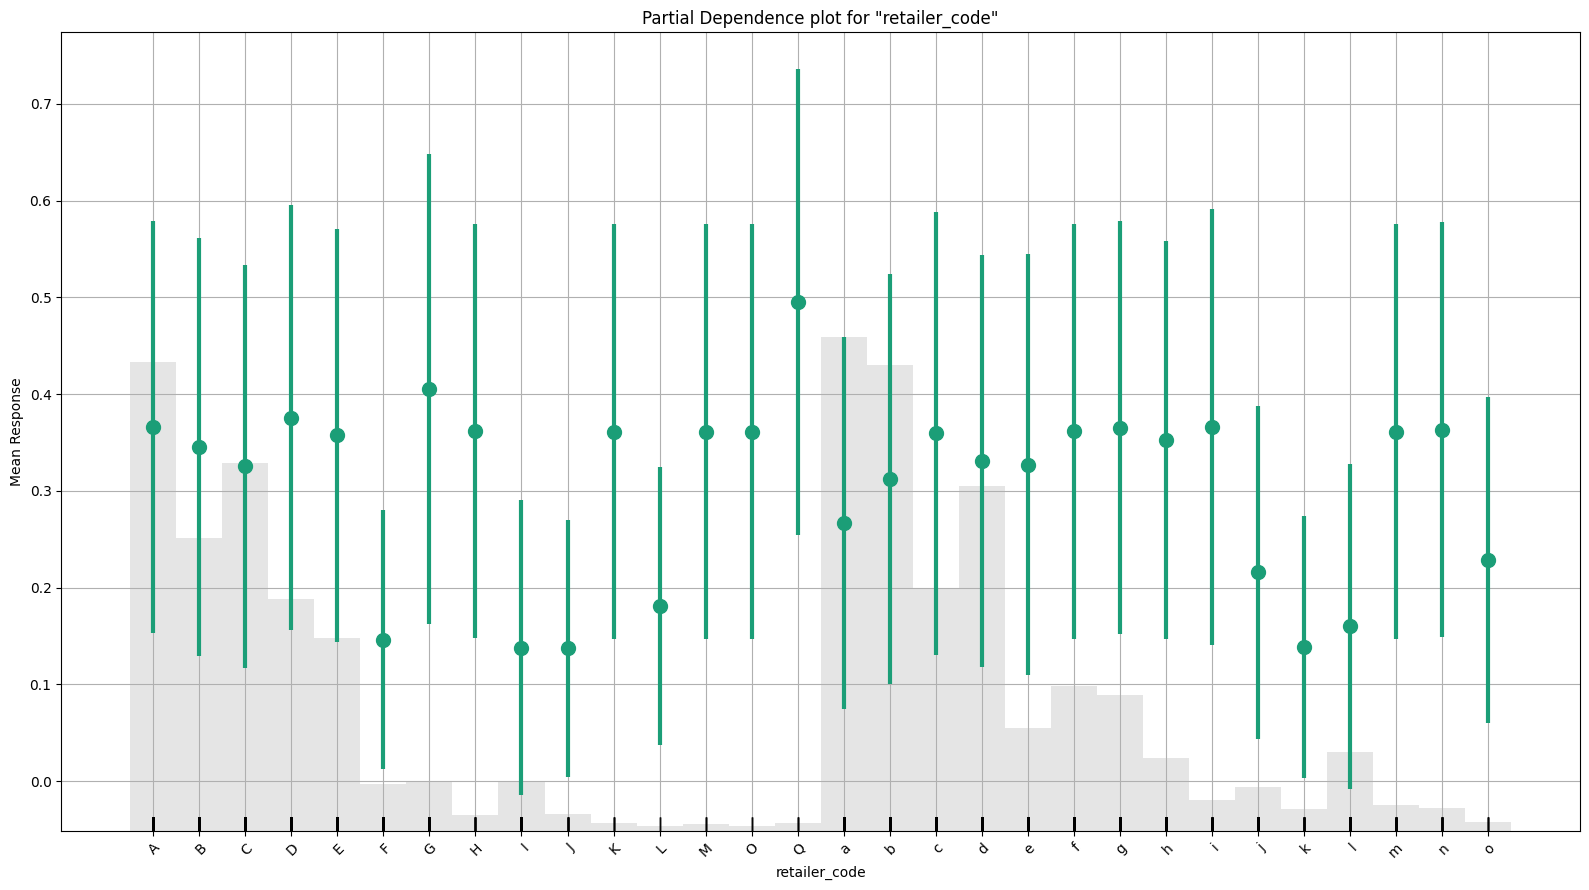

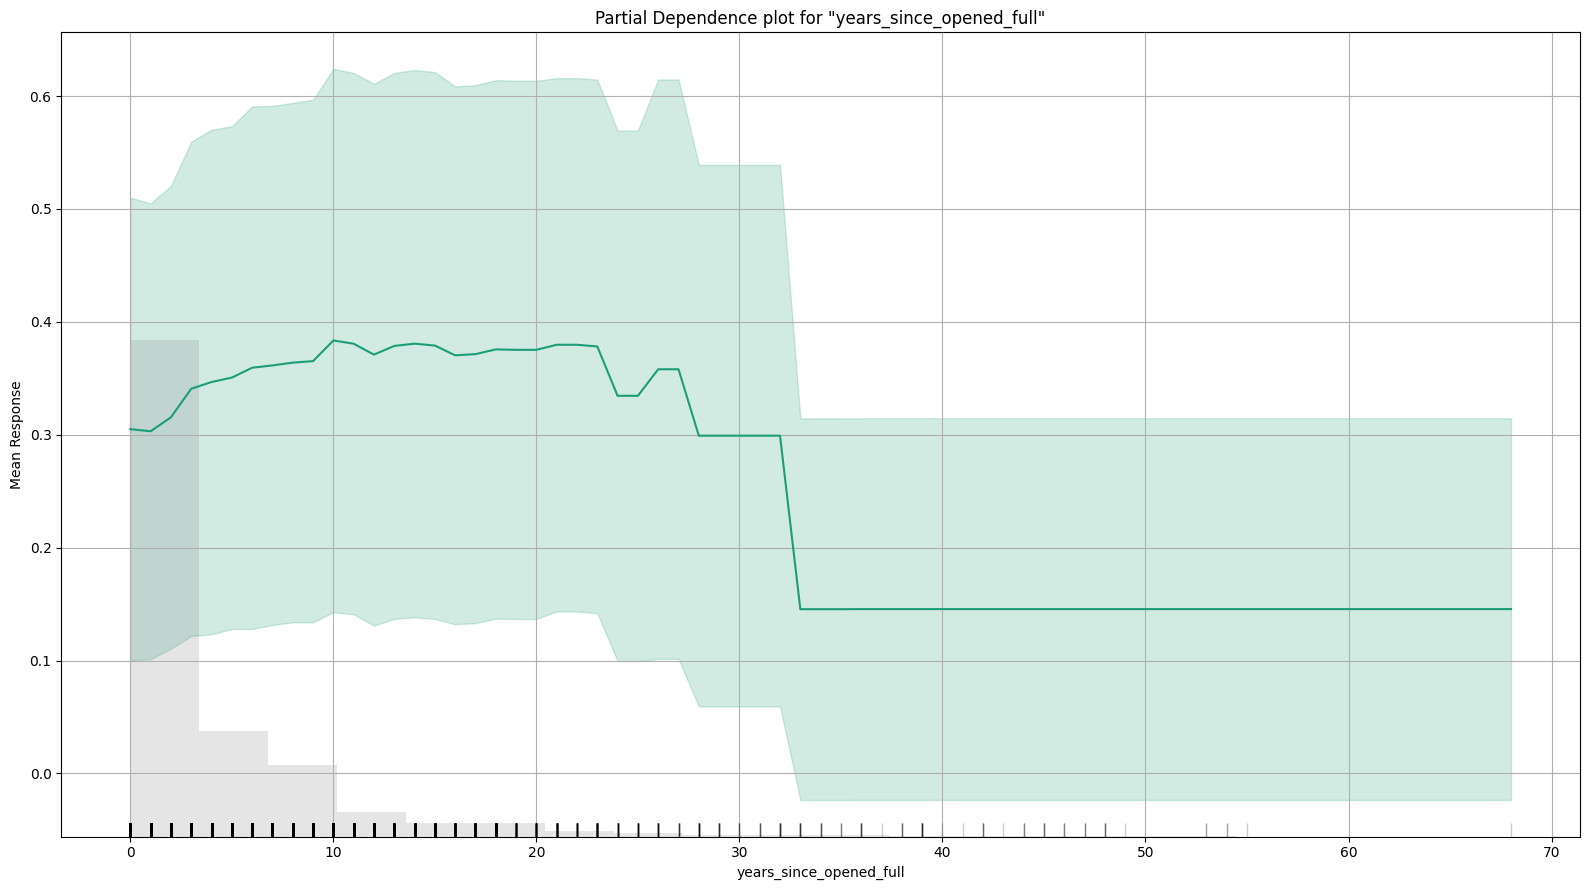

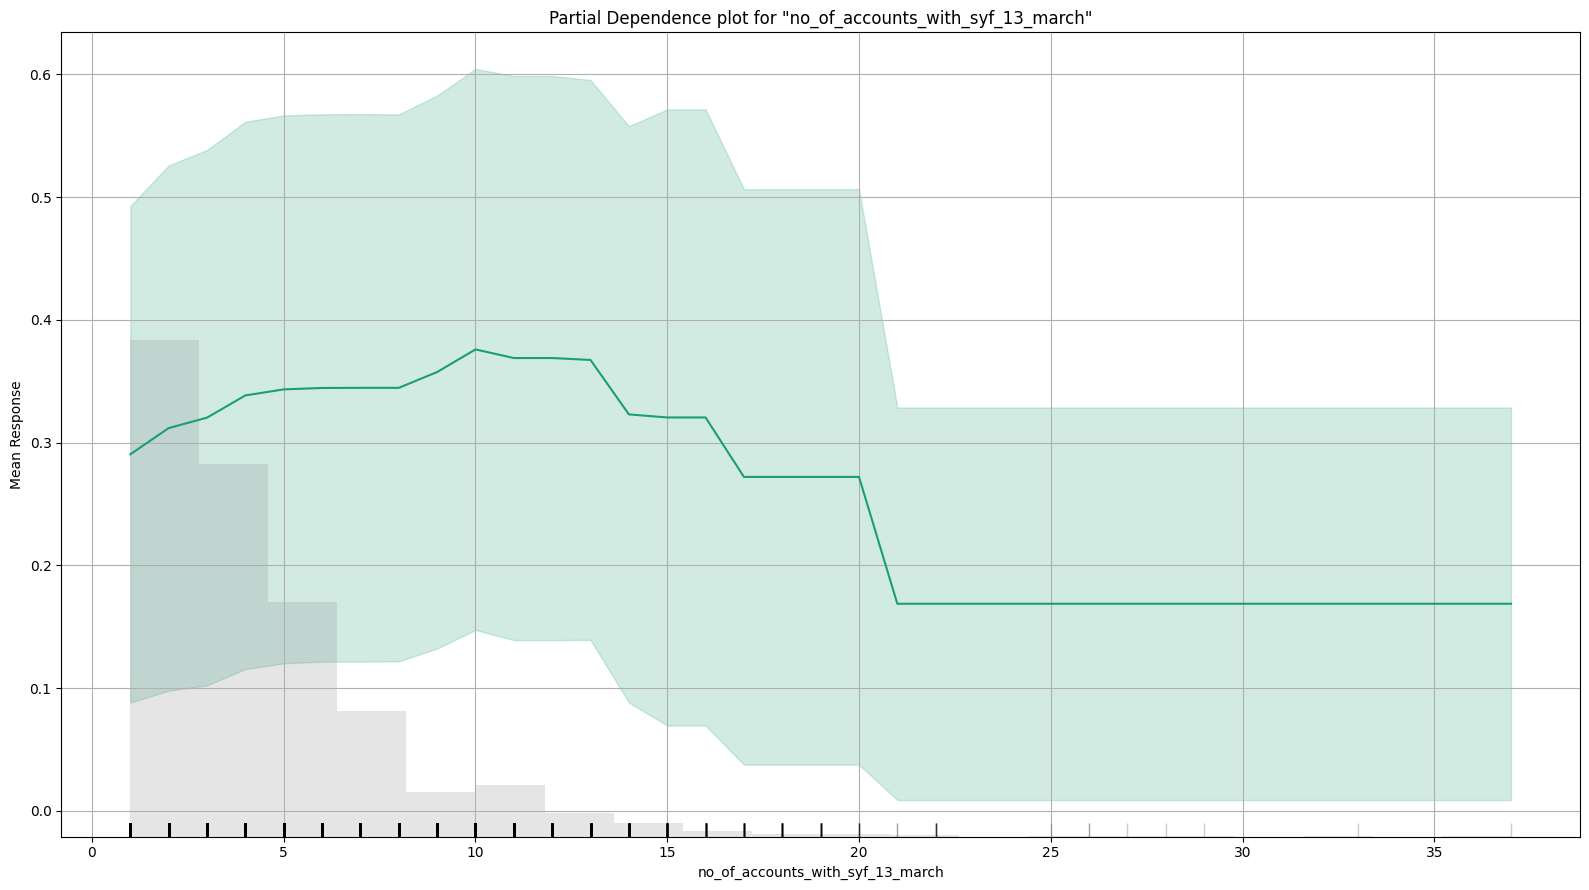



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada07fb55a0>), ('description', <h2o.explanation._explain.Description object at 0x7ada31ffeaa0>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711280219938_16293', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada02c4dab0>), ('plots', H2OExplanation([('XGBoost_model_python_1711280219938_16293', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6759253018780759', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada02c4f610>), ('description', <h2o.explanation._explain.Description object at 0x7ada02c4f220>), ('plots', H2OExplanation([('XGBoost_model_python_1711280219938_16293', <h2o.plot._plot_result._MObject object at 0x7ada0f570ee0>)]))])), ('varimp', H2OE

In [88]:
explanation = mdl_wa.explain(train)
print(explanation)

grid search

In [59]:
sampled_data = auto_df[auto_df['reason'] == "wa"]

response="resolved"
predictor= [x for x in auto_df.columns if x != 'resolved']
train,test,valid = sampled_data.split_frame(ratios=[.6, .2], seed = 2018)

# GBM hyperparameters
gbm_params_wa = {'learn_rate': [0.08, 0.09, 0.1],
               'max_depth': [6, 8],
               'sample_rate': [ 0.8, 0.9, 1.0],
               'scale_pos_weight': [0.5, 0.6],
               'colsample_bytree': [0.5, 0.6]}

# Train and validate a cartesian grid of GBMs
gbm_grid_wa = H2OGridSearch(model=H2OXGBoostEstimator,
                          grid_id='gbm_grid_wa',
                          hyper_params=gbm_params_wa)
gbm_grid_wa.train(x=predictor, y=response,
                training_frame=train,
                validation_frame=valid,
                ntrees=50,
                seed=1)

# Get the grid results, sorted by validation AUC
gbm_gridperf_wa = gbm_grid_wa.get_grid(sort_by='auc', decreasing=True)
gbm_gridperf_wa

# Grab the top GBM model, chosen by validation AUC
best_gbm_wa = gbm_gridperf_wa.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf_wa = best_gbm_wa.model_performance(test)

best_gbm_perf_wa.auc()

xgboost Grid Build progress: |███████████████████████████████████████████████████| (done) 100%


0.6917766110489493

In [60]:
my_param = ['max_depth', 'learn_rate', 'sample_rate', 'scale_pos_weight', 'colsample_bytree']
params = best_gbm_wa.params
for param in my_param:
  print(f"{param}:{params[param]}\n")

max_depth:{'default': 6, 'actual': 6, 'input': 6}

learn_rate:{'default': 0.3, 'actual': 0.1, 'input': 0.1}

sample_rate:{'default': 1.0, 'actual': 0.9, 'input': 0.9}

scale_pos_weight:{'default': 1.0, 'actual': 0.5, 'input': 0.5}

colsample_bytree:{'default': 1.0, 'actual': 0.6, 'input': 0.6}



In [61]:
#performance on test
performance = best_gbm_wa.model_performance(test)
print(best_gbm_wa)
print(performance)

Model Details
H2OXGBoostEstimator : XGBoost
Model Key: gbm_grid_wa_model_12


Model Summary: 
    number_of_trees
--  -----------------
    100

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.060666757471386626
RMSE: 0.24630622702519445
LogLoss: 0.20777731329838312
Mean Per-Class Error: 0.24072434696225234
AUC: 0.9075493642368642
AUCPR: 0.5871970961217123
Gini: 0.8150987284737283

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09825765155255795
          floor    resolved    Error    Rate
--------  -------  ----------  -------  --------------
floor     6812     284         0.04     (284.0/7096.0)
resolved  260      329         0.4414   (260.0/589.0)
Total     7072     613         0.0708   (544.0/7685.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0982577    0.547421  150
max f2                 

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## gbm_grid_wa_model_12

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09825765155255795
          floor    resolved    Error    Rate
--------  -------  ----------  -------  --------------
floor     6812     284         0.04     (284.0/7096.0)
resolved  260      329         0.4414   (260.0/589.0)
Total     7072     613         0.0708   (544.0/7685.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

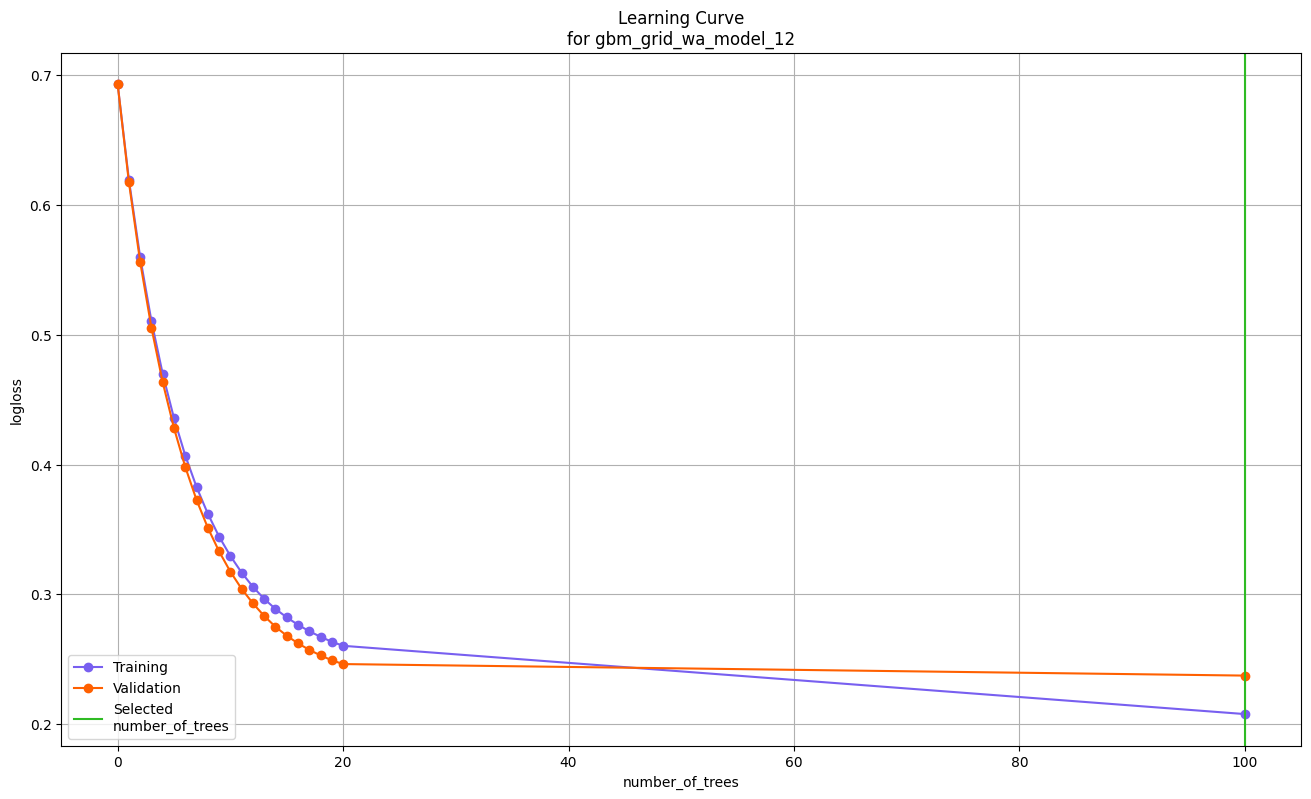

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

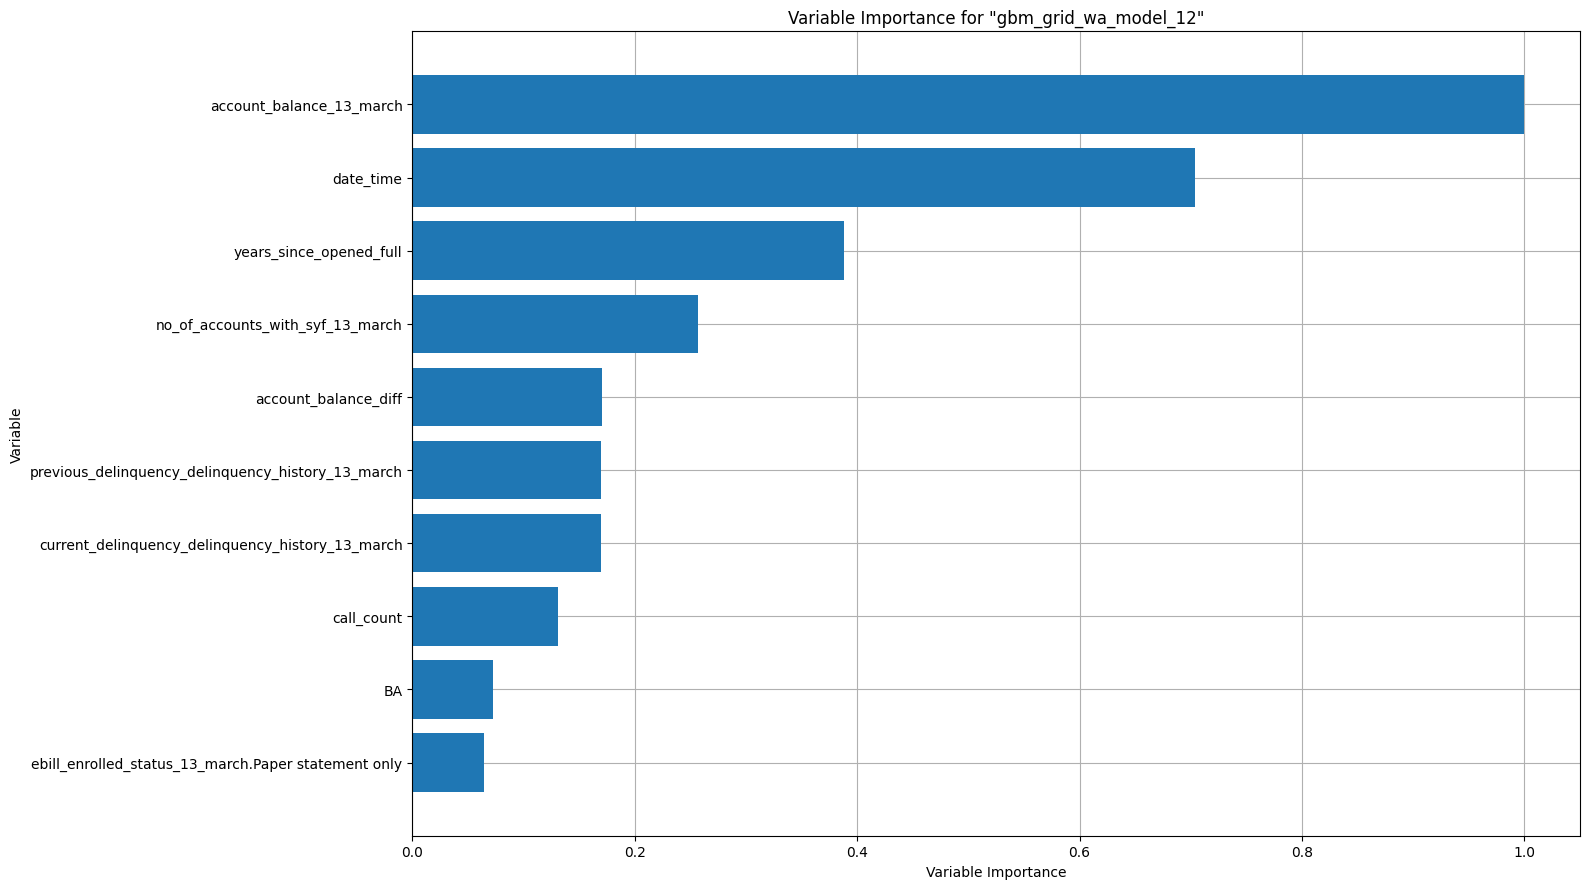

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

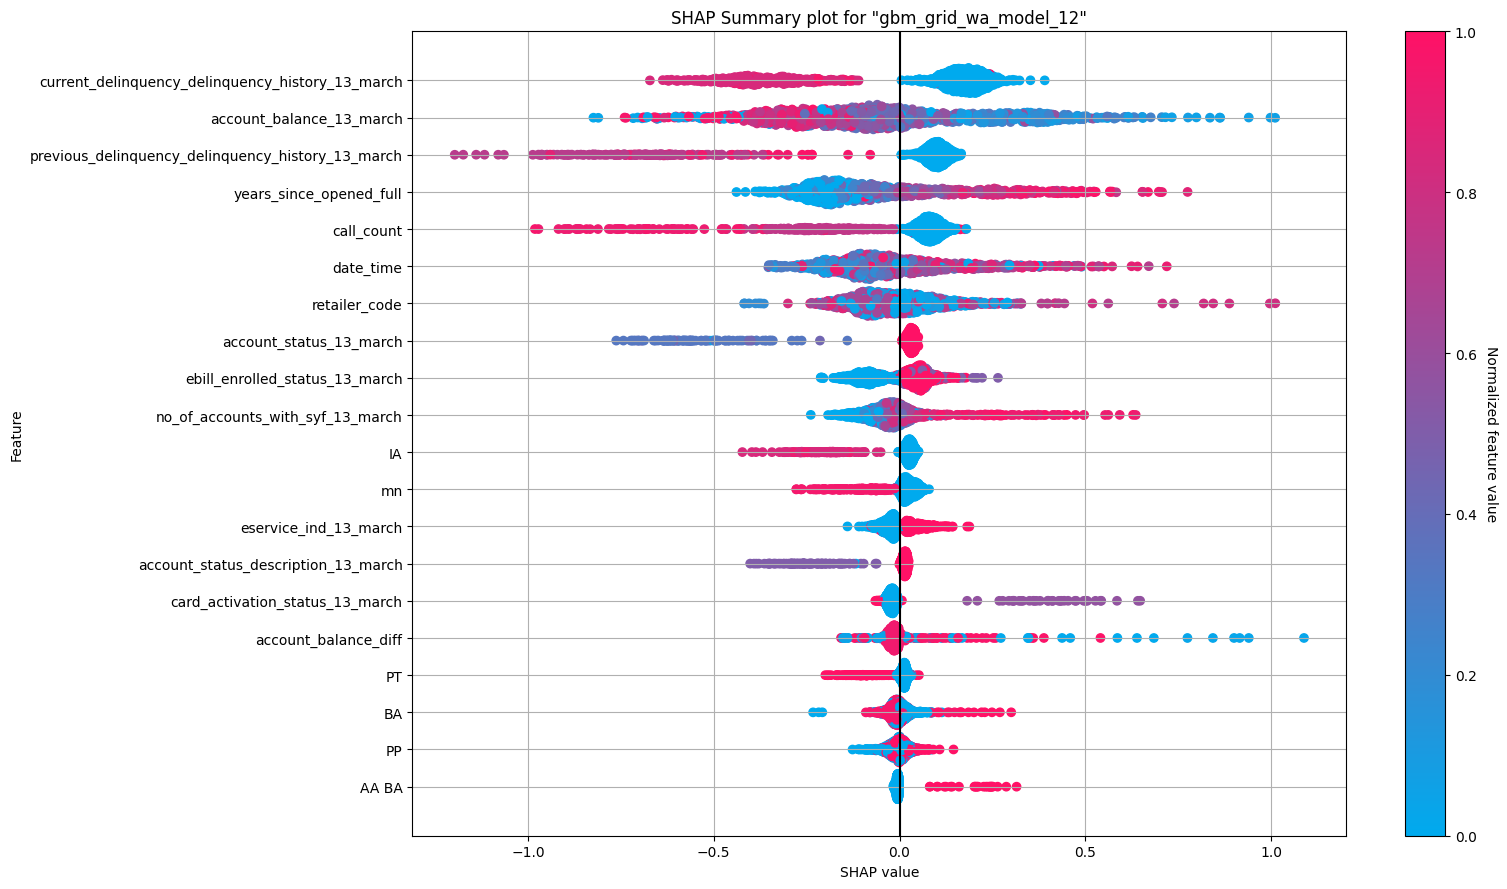

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

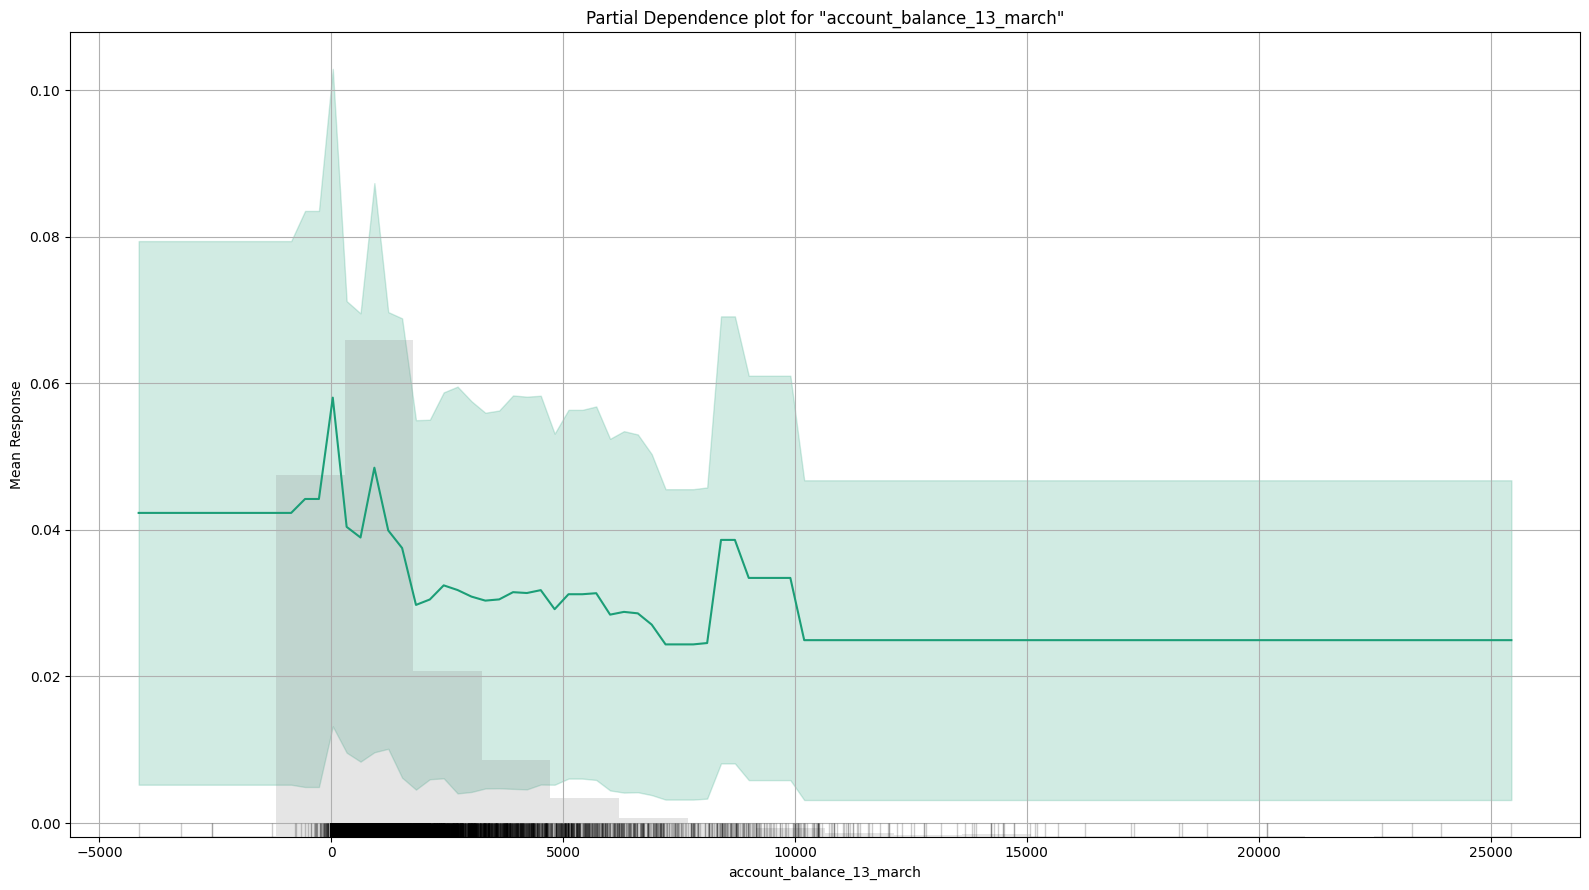

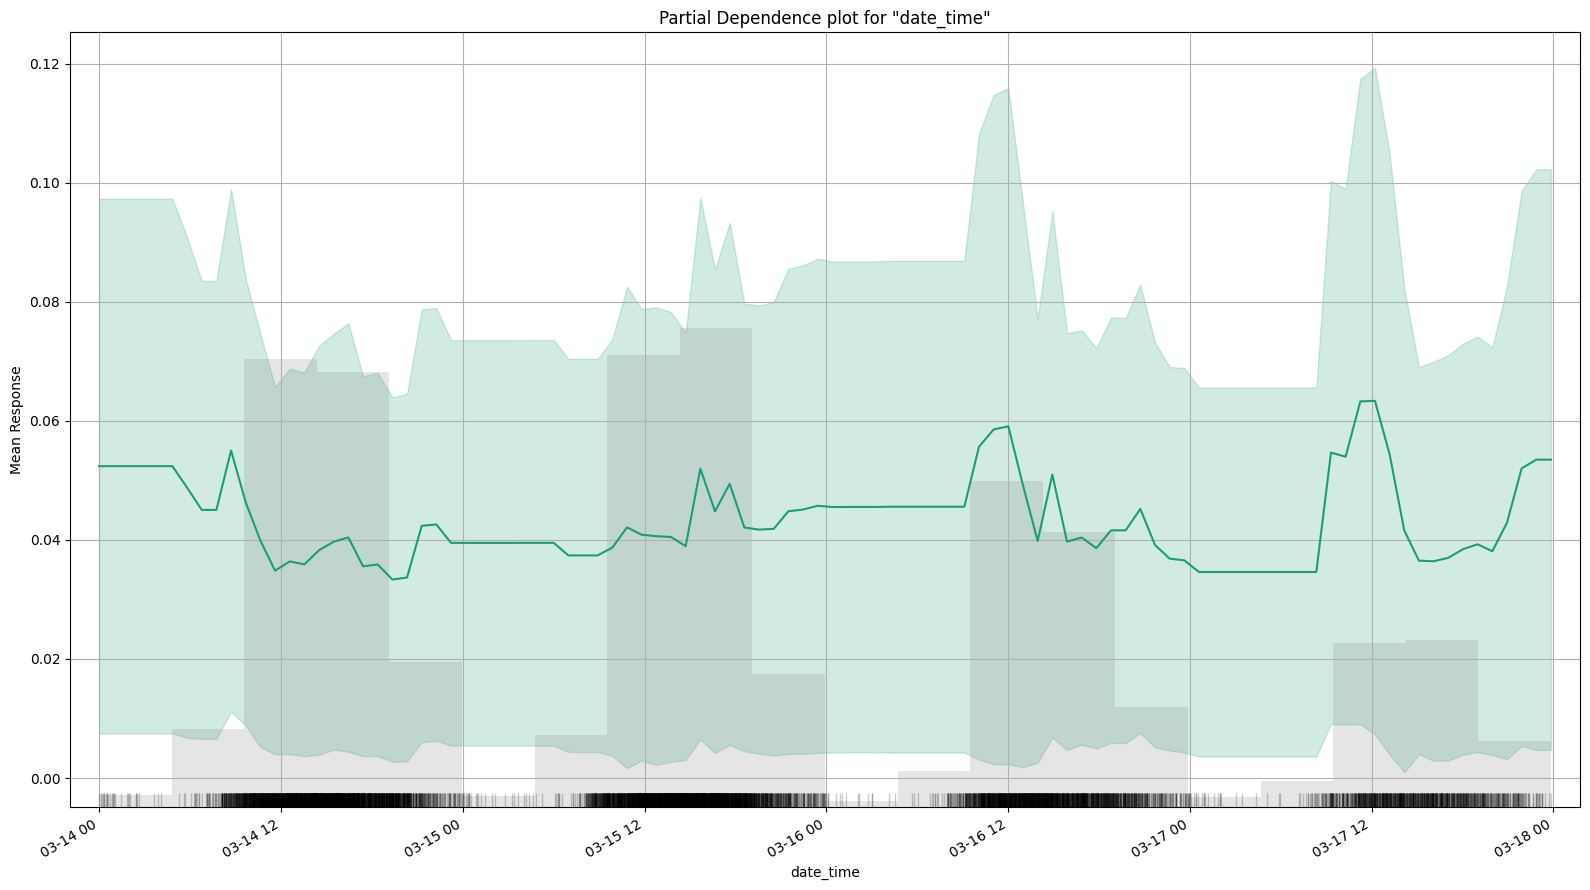

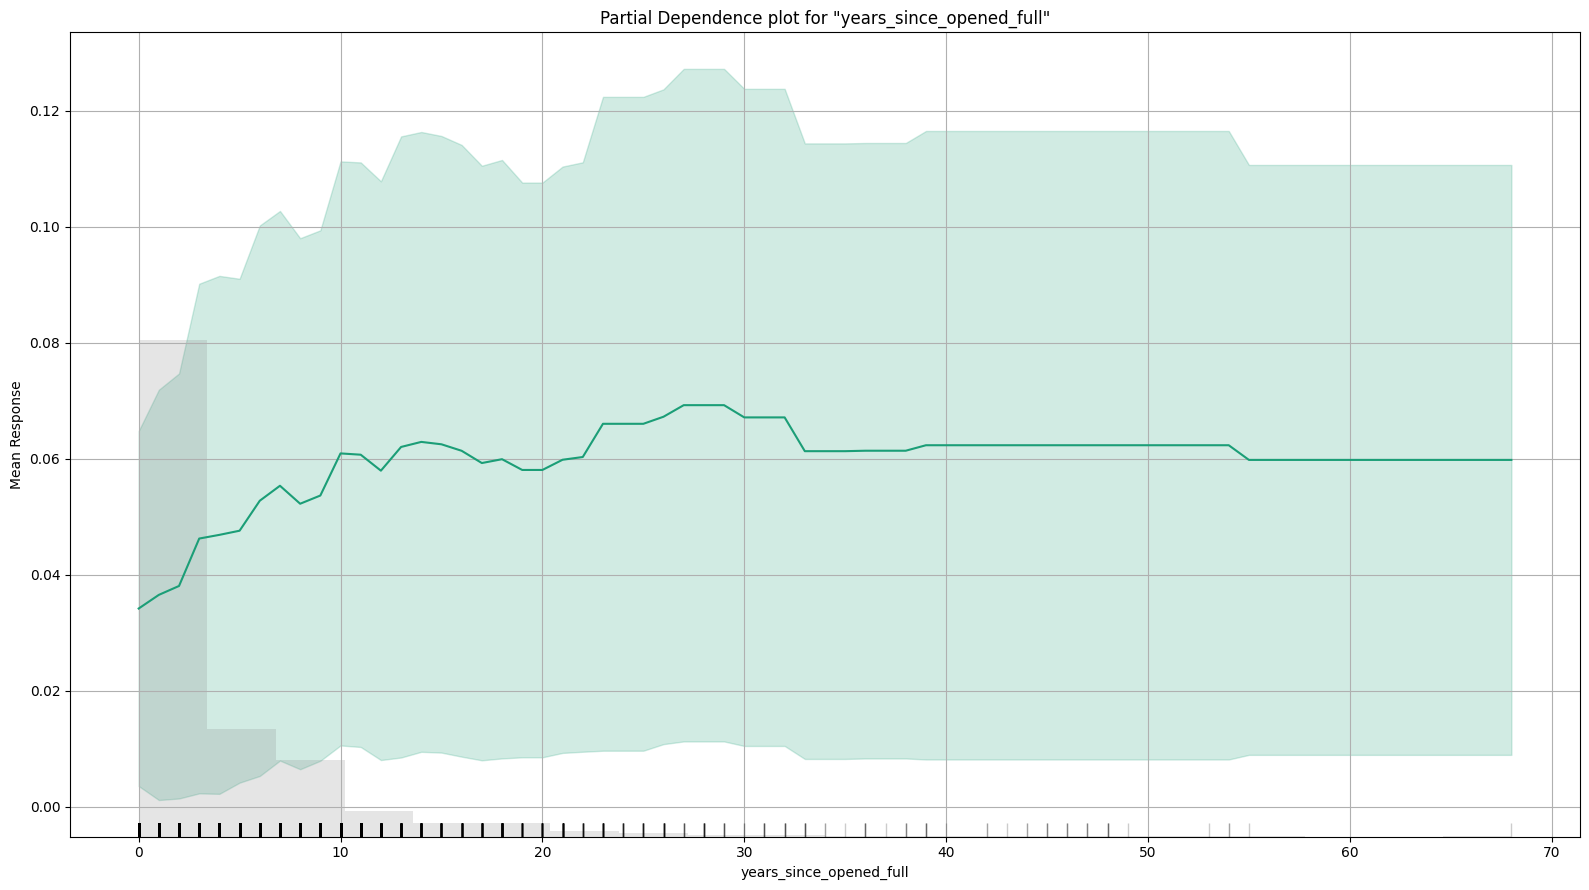

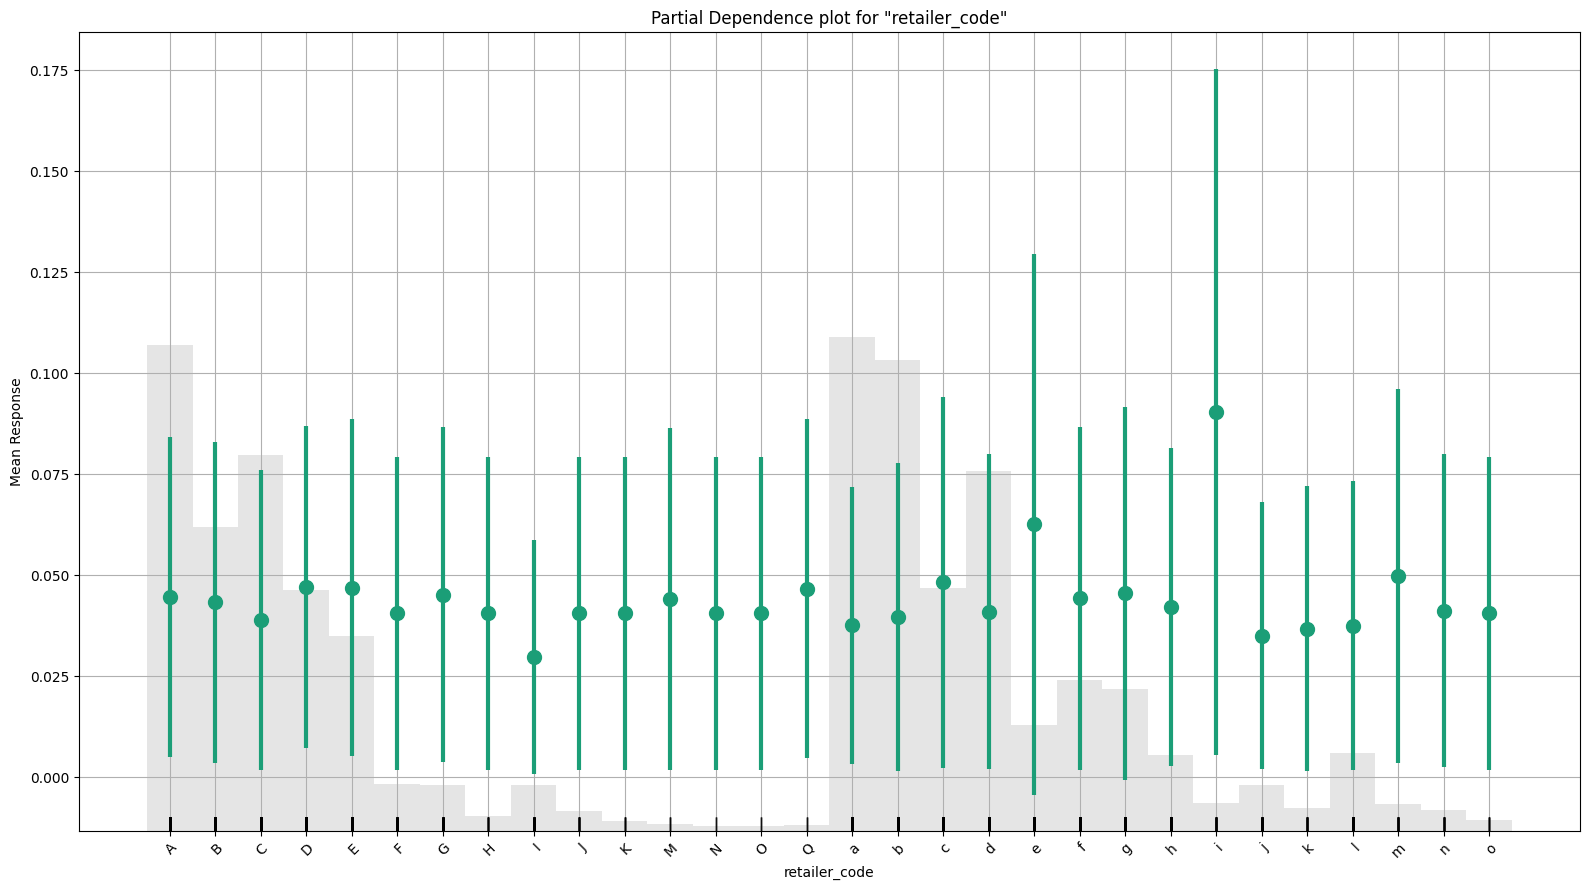

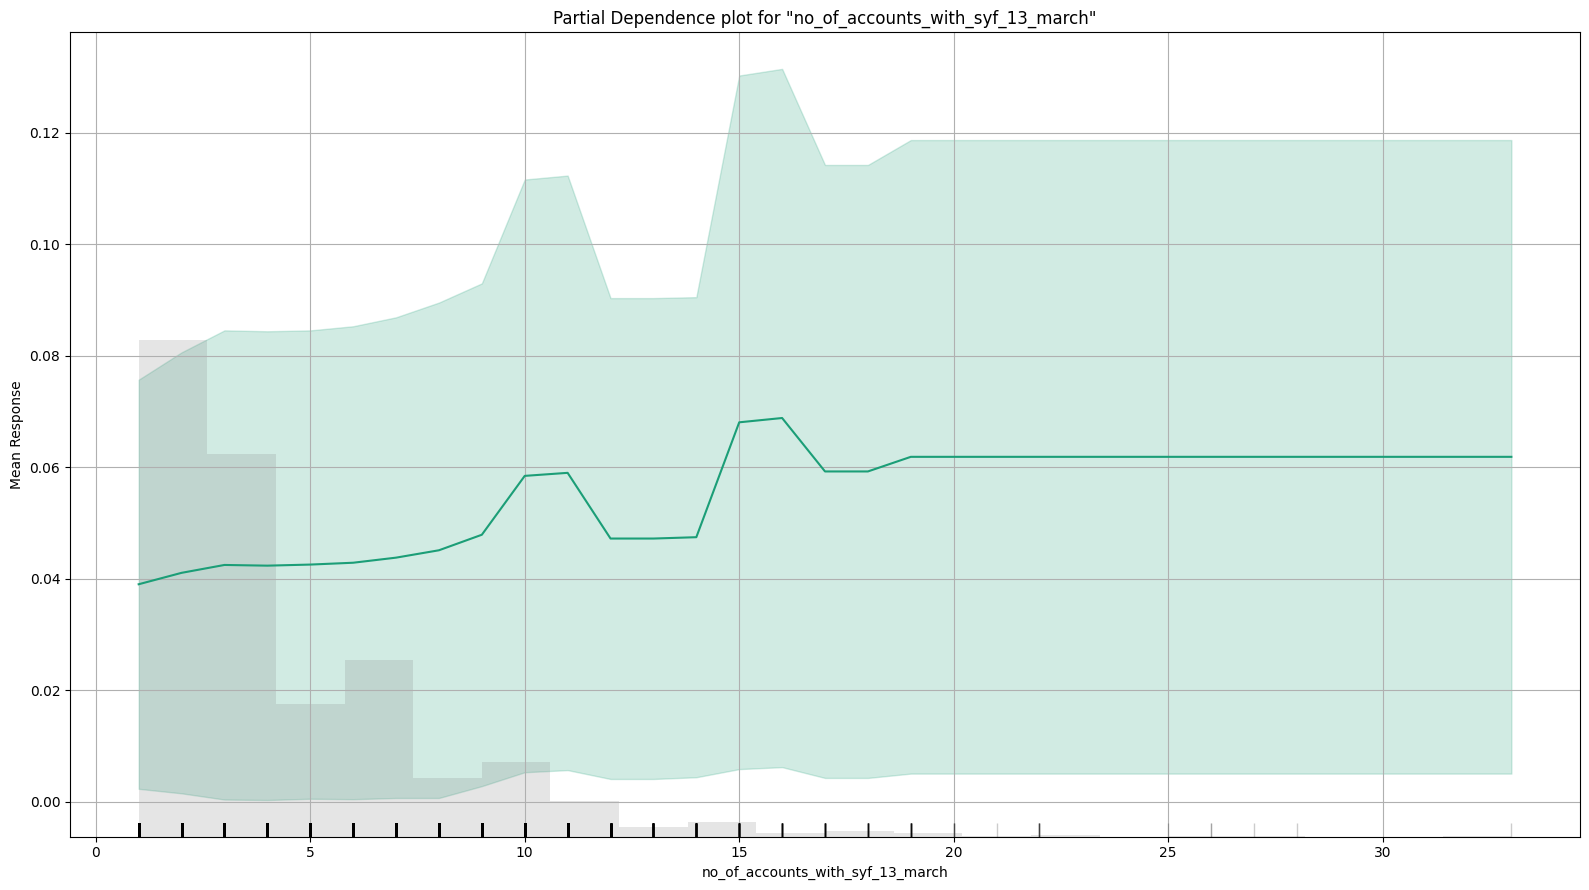



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada03c36830>), ('description', <h2o.explanation._explain.Description object at 0x7ada03c36bc0>), ('subexplanations', H2OExplanation([('gbm_grid_wa_model_12', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada03c376a0>), ('plots', H2OExplanation([('gbm_grid_wa_model_12', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09825765155255795', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada03c37310>), ('description', <h2o.explanation._explain.Description object at 0x7ada03c369e0>), ('plots', H2OExplanation([('gbm_grid_wa_model_12', <h2o.plot._plot_result._MObject object at 0x7ada03c745b0>)]))])), ('varimp', H2OExplanation([('header', <h2o.explanation._explain.Header obj

In [62]:
explanation = best_gbm_wa.explain(train)
print(explanation)

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [IA IC, reason, FI PP, AA RC, iO, HI mm, AP mm, iS, FI PI, LW, iT, LS mm, RI mm, eS, eB mm, CT wa, HI IA, AA mm, eY mm, AA mt, DE wa, iS mm, HI LS, GA mm, mP wa, eR mm, Ls, IA PS, ER, IA LS, PI mm, IA LW, DR PT, AA PT, SR mm, AU mm, AA LW, VP, mo wa, AA iR, iT mm, FD, AA DP, AA CT, RV, IA SR, IC mm, NU, IA SP, eS mm, FR, mp wa, GA wa, iM mm, eP mm, FM mm, HI PP, AA GA, FI IA, eA mm, RP mm, NU mm, FM IA, VA mm, IA NU, AA SP, CS, PP SP, PP SR, mm wa, CT mm, LW PI, mP mm, iF]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████| (done) 100%
ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.15406701708956136
RMSE: 0.3925137157980105
LogLoss: 0.4644604836576876
Mean Per-Class Error: 0.36576297953543463
AUC: 0.6792846802470413
AUCPR: 0.1358980574799416
Gini: 0.3585693604940825

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42081936200459796
          floor    resolved    Error    Rate
--------  -------  ----------  -------  --------------
floor     1604     734         0.3139   (734.0/2338.0)
resolved  76       106         0.4176   (76.0/182.0)
Total     1680     840         0.3214   (810.0/2520.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.420819     0.207436  170
max f2                       0.303877     0.351379  228
max f0point5                 0.713541     0.184615  4

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711280219938_11318

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6754186123609542
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     9159     378         0.0396   (378.0/9537.0)
resolved  235      505         0.3176   (235.0/740.0)
Total     9394     883         0.0596   (613.0/10277.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

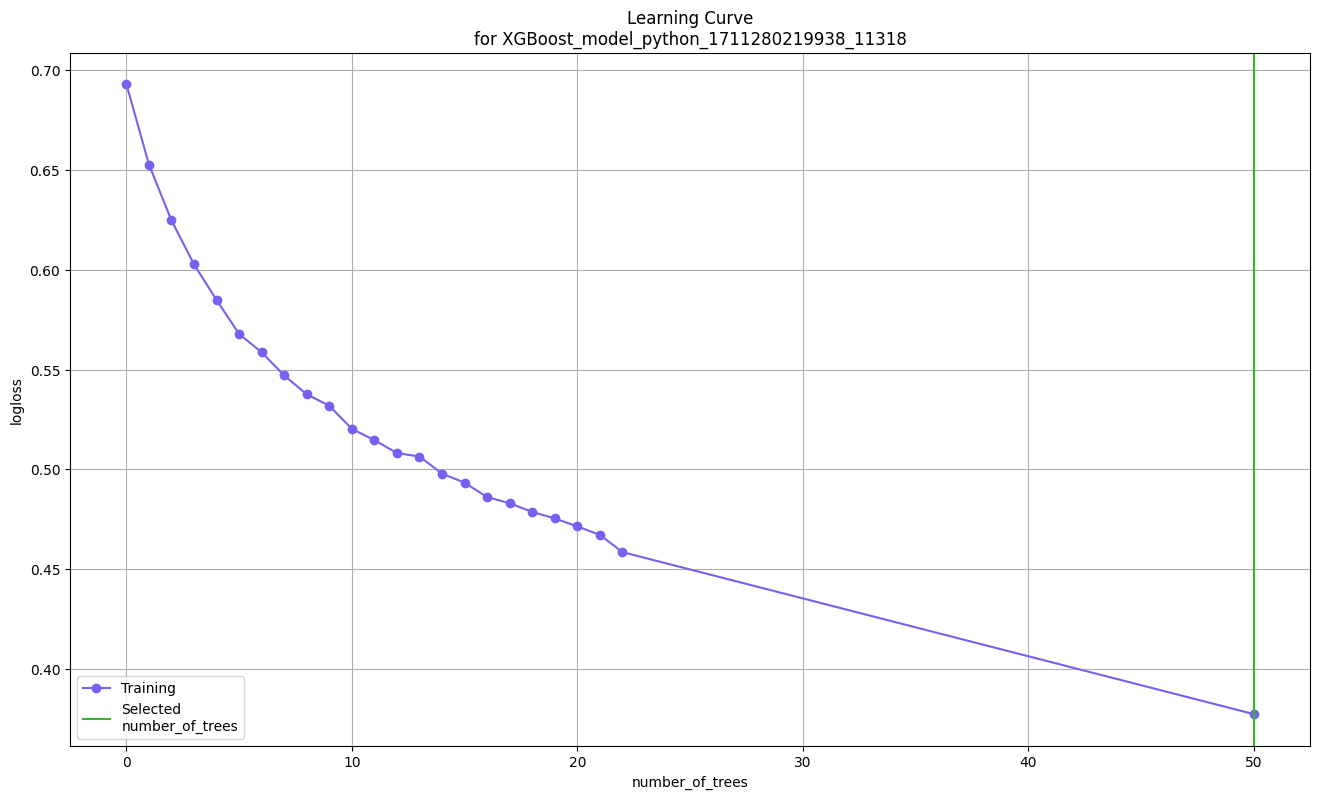

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

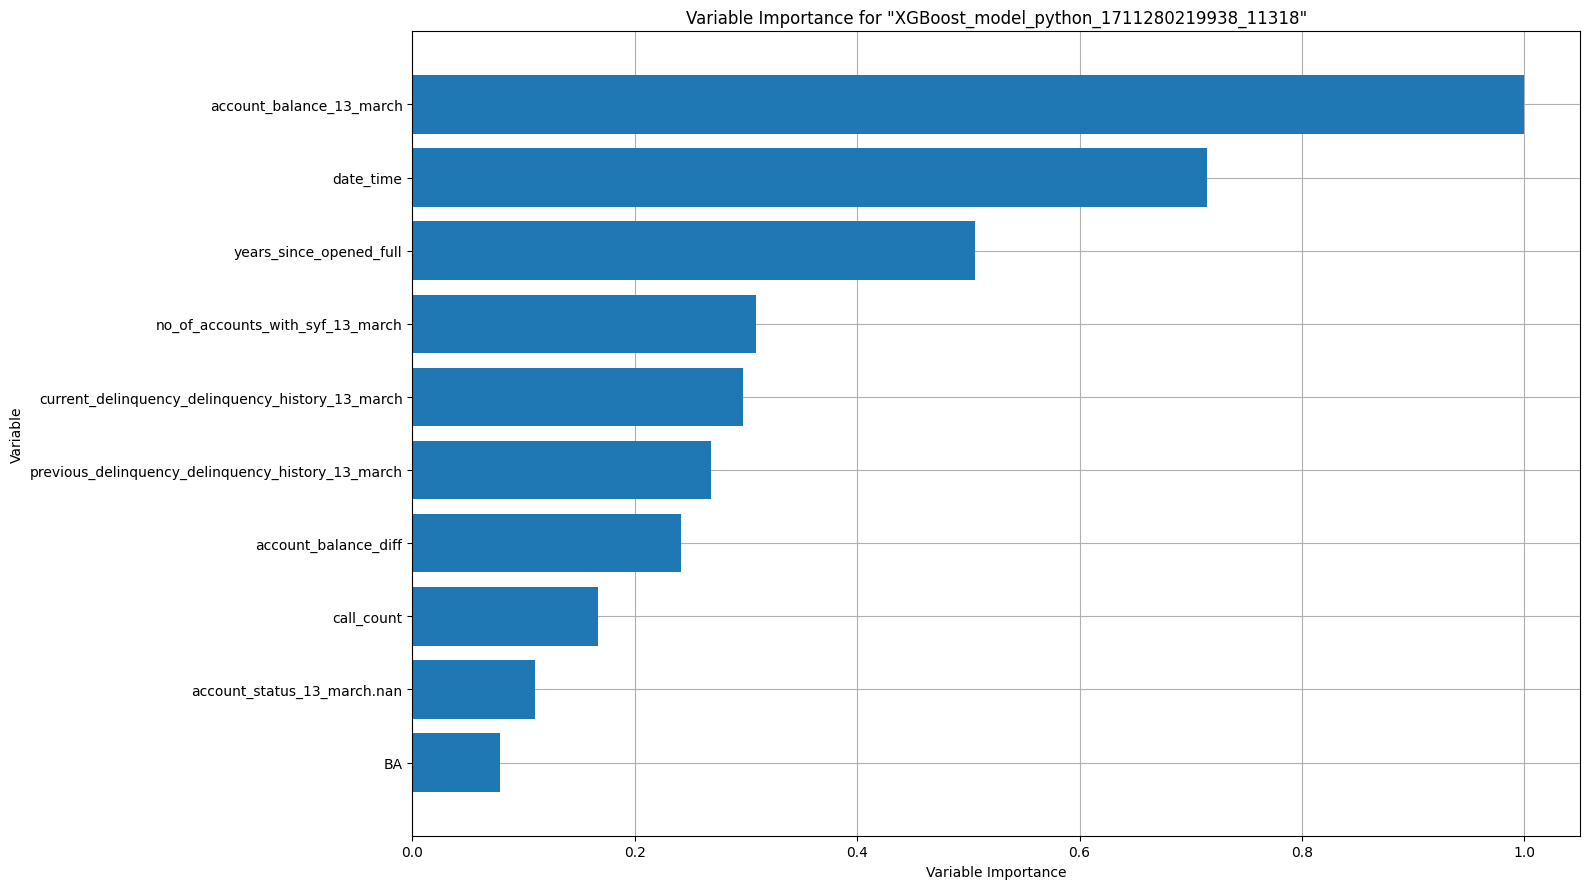

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

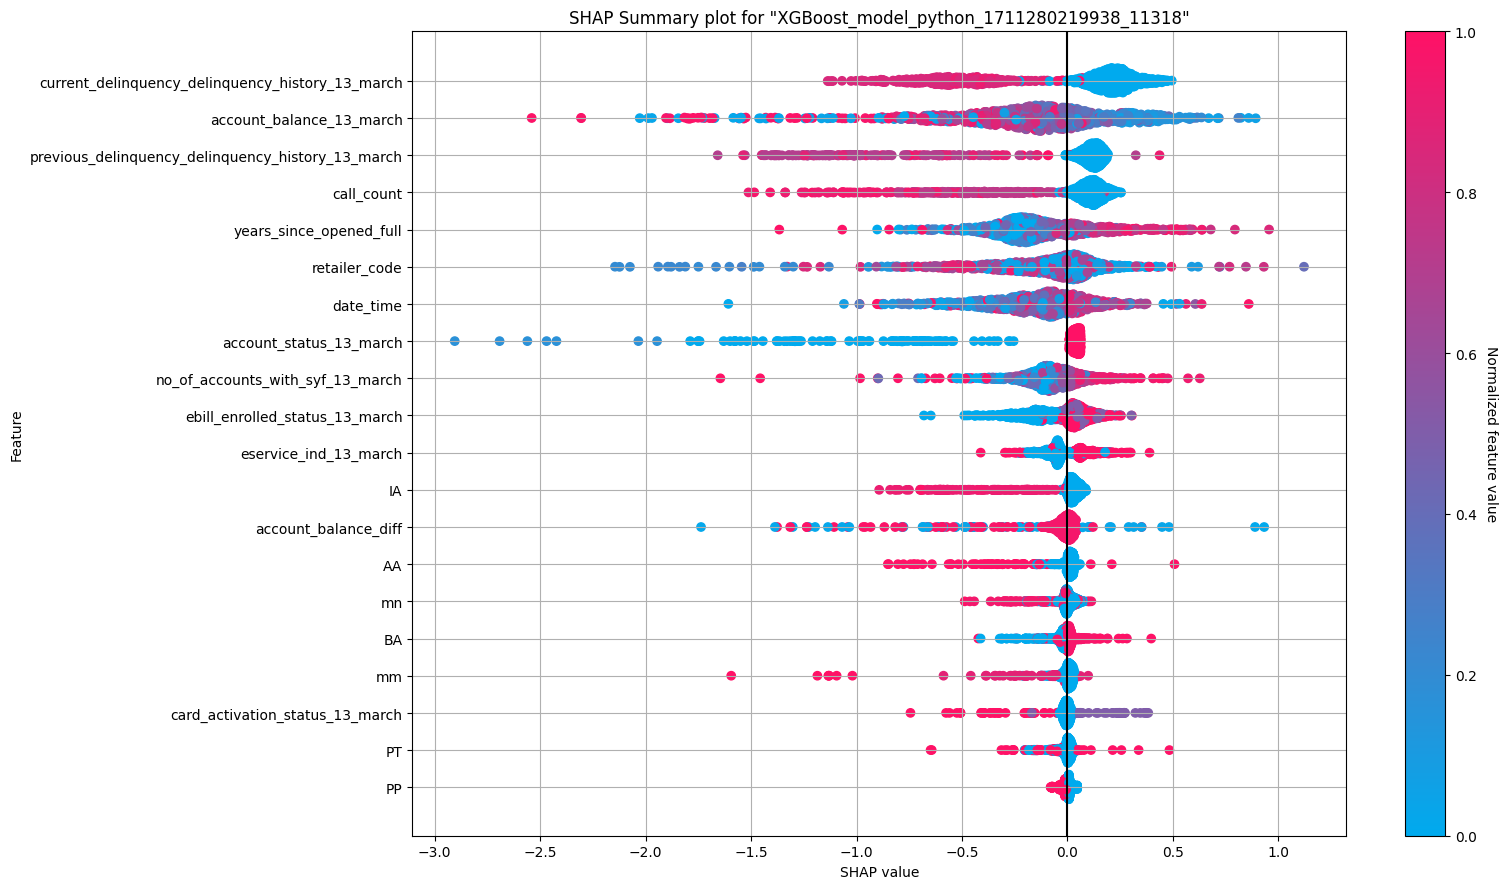

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

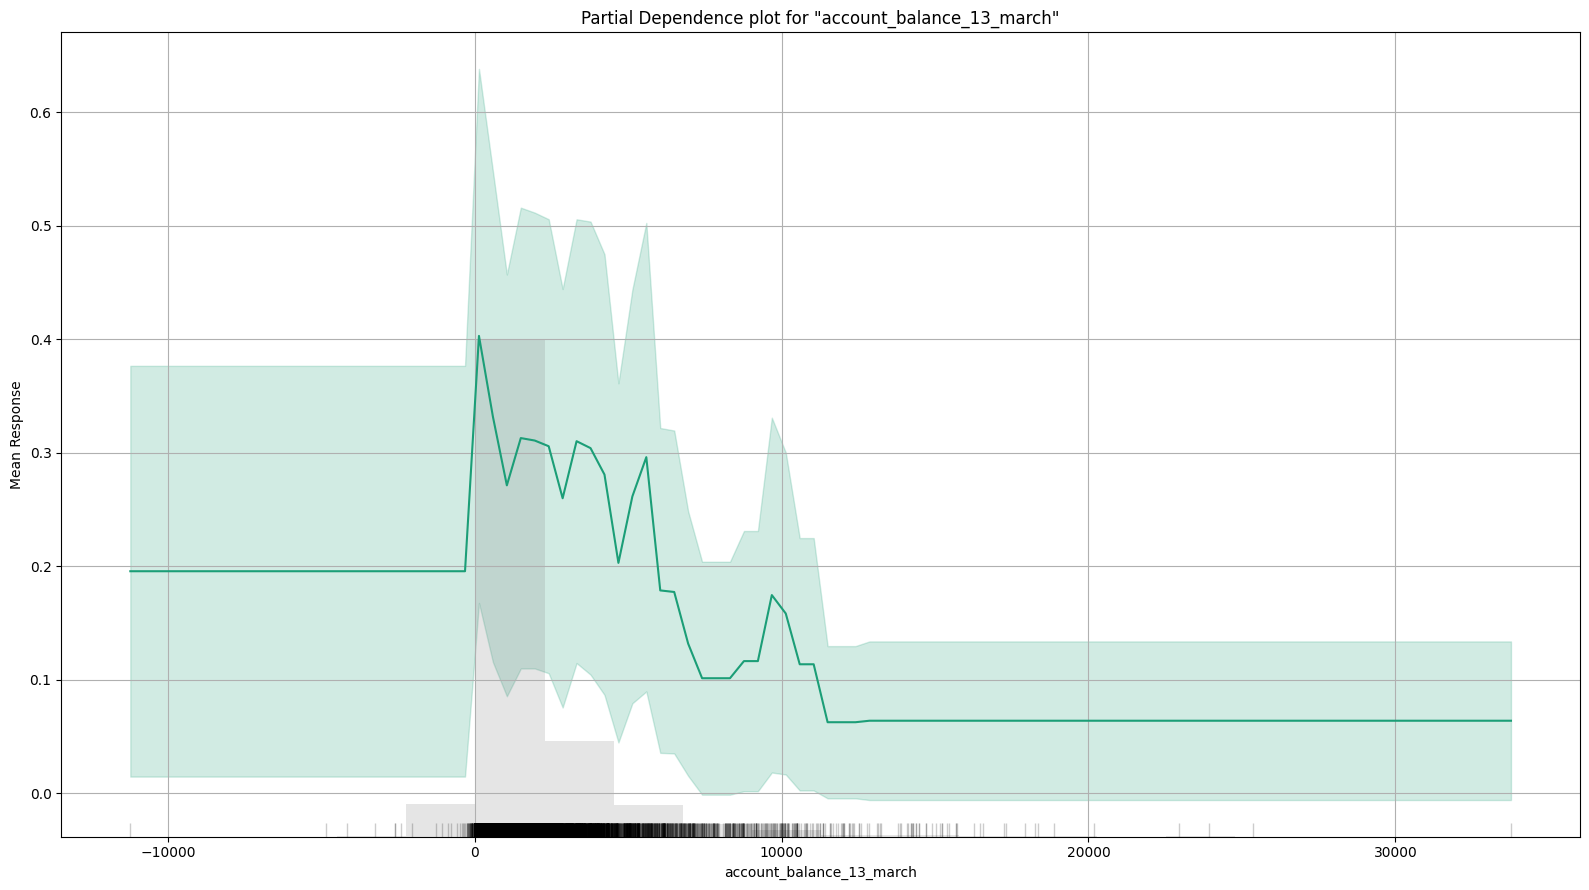

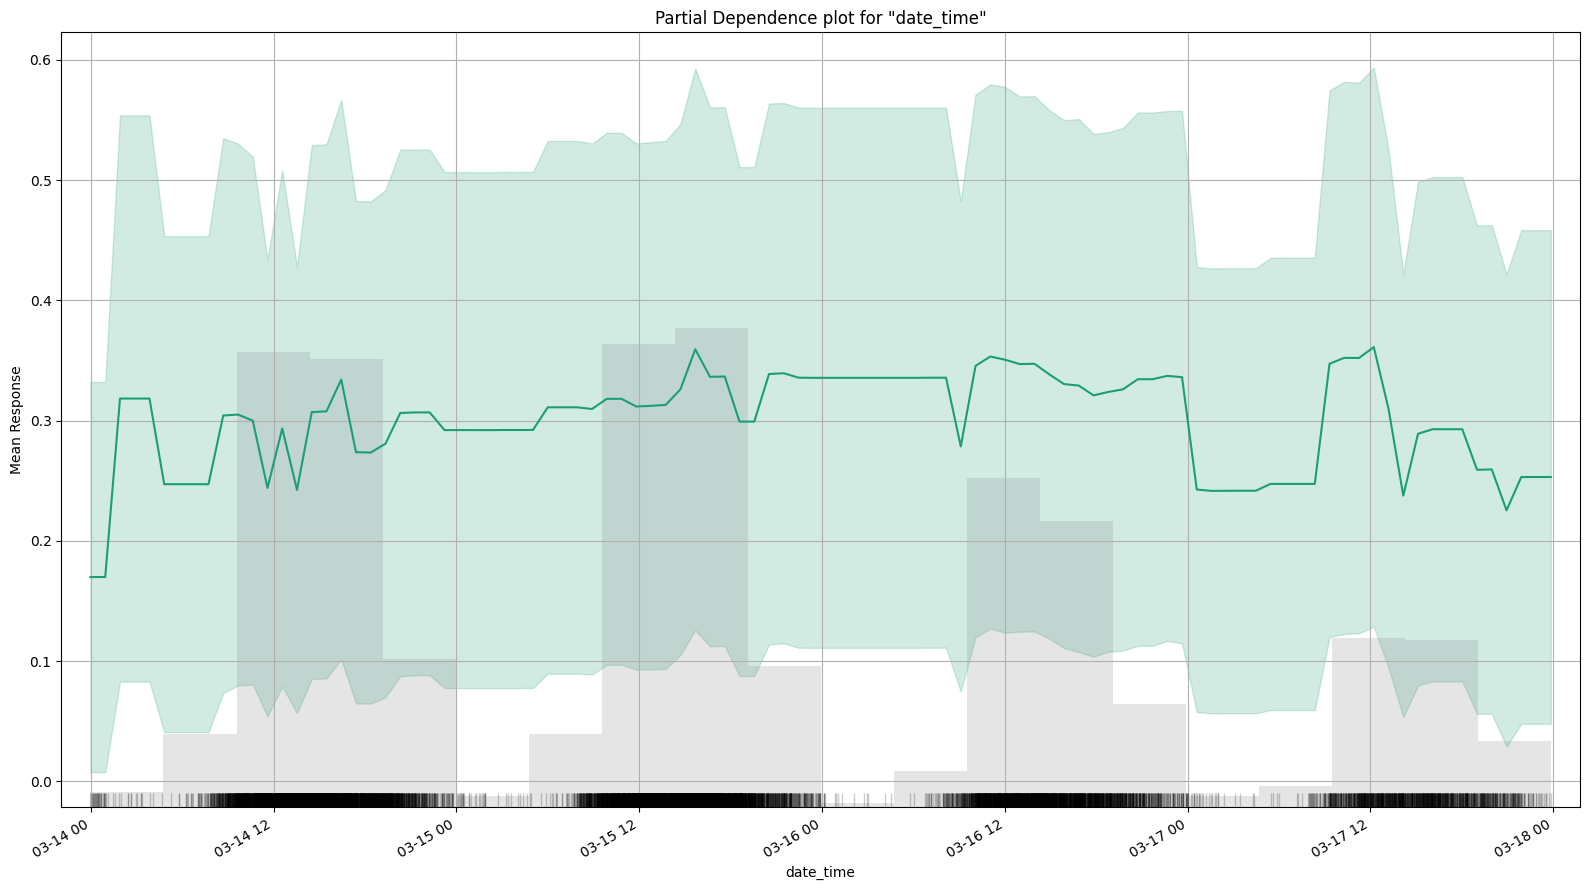

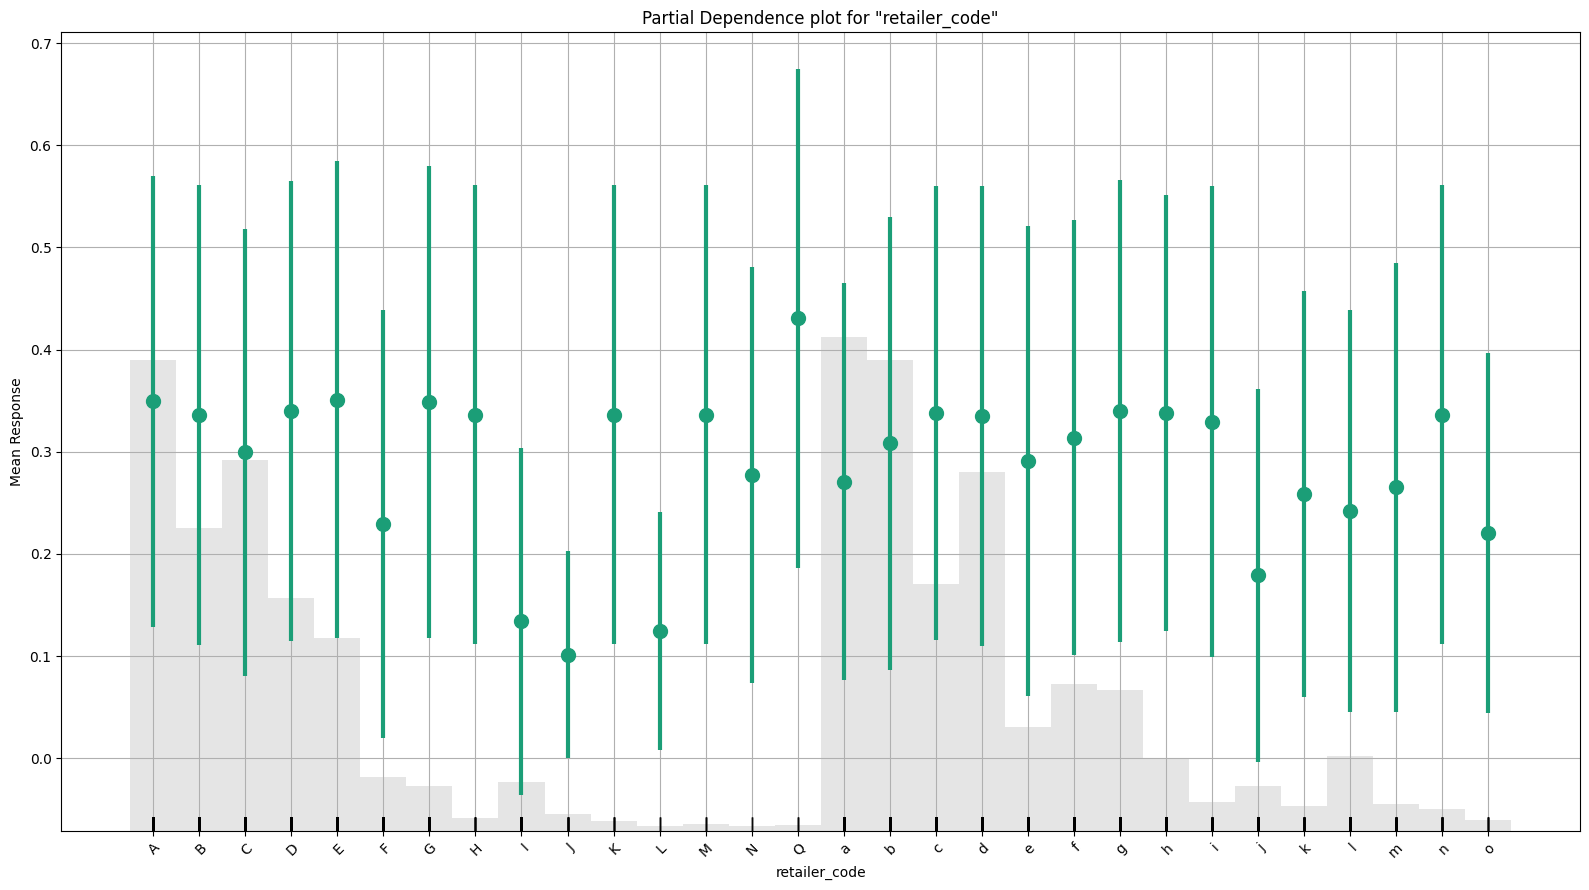

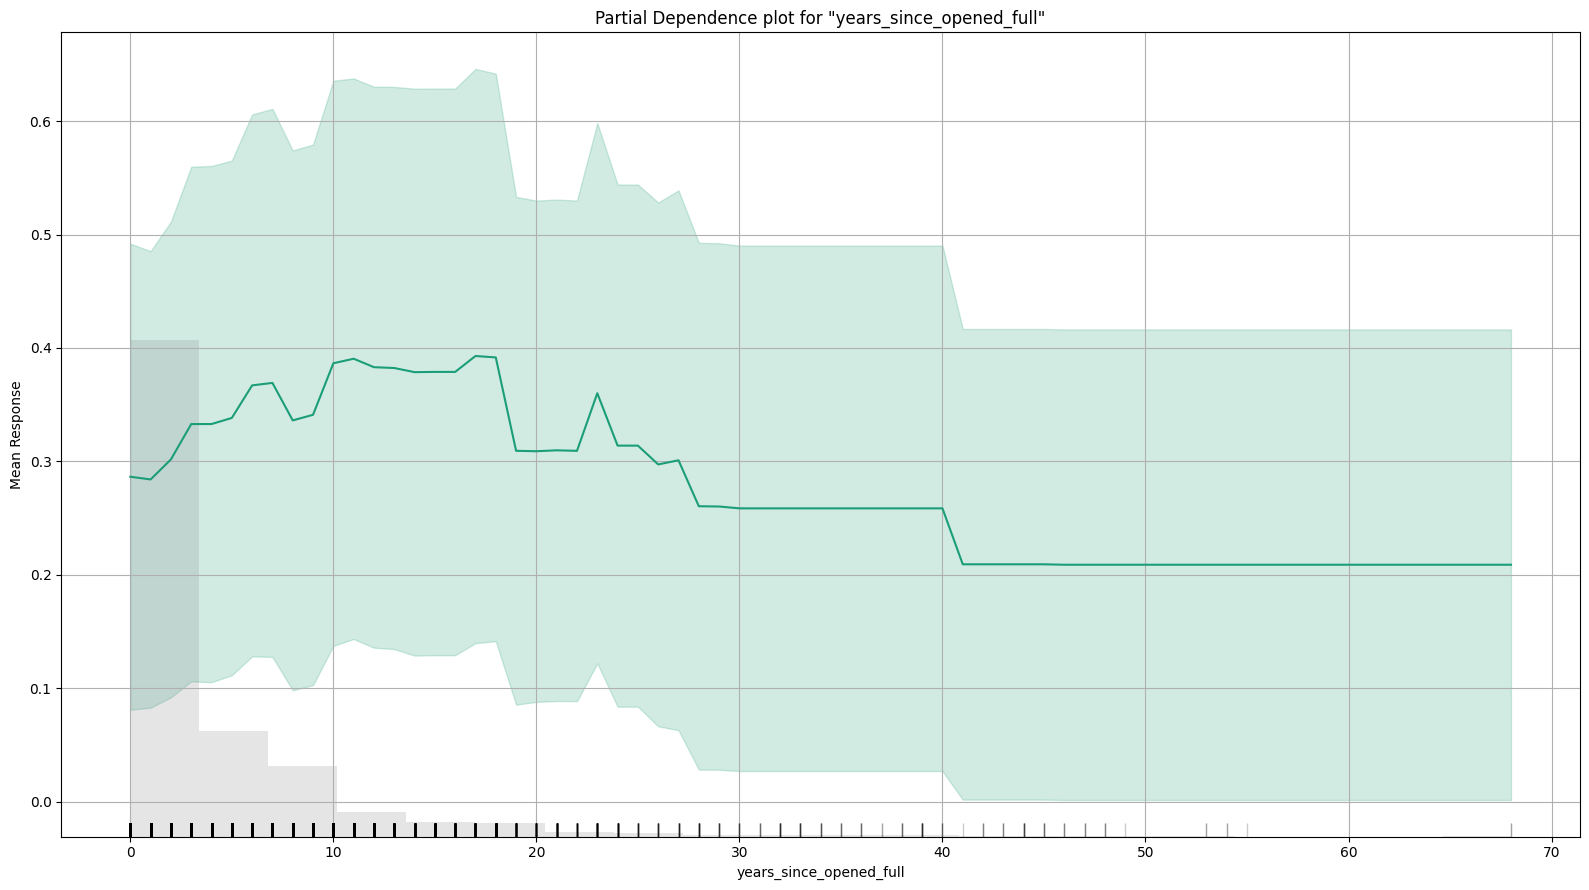

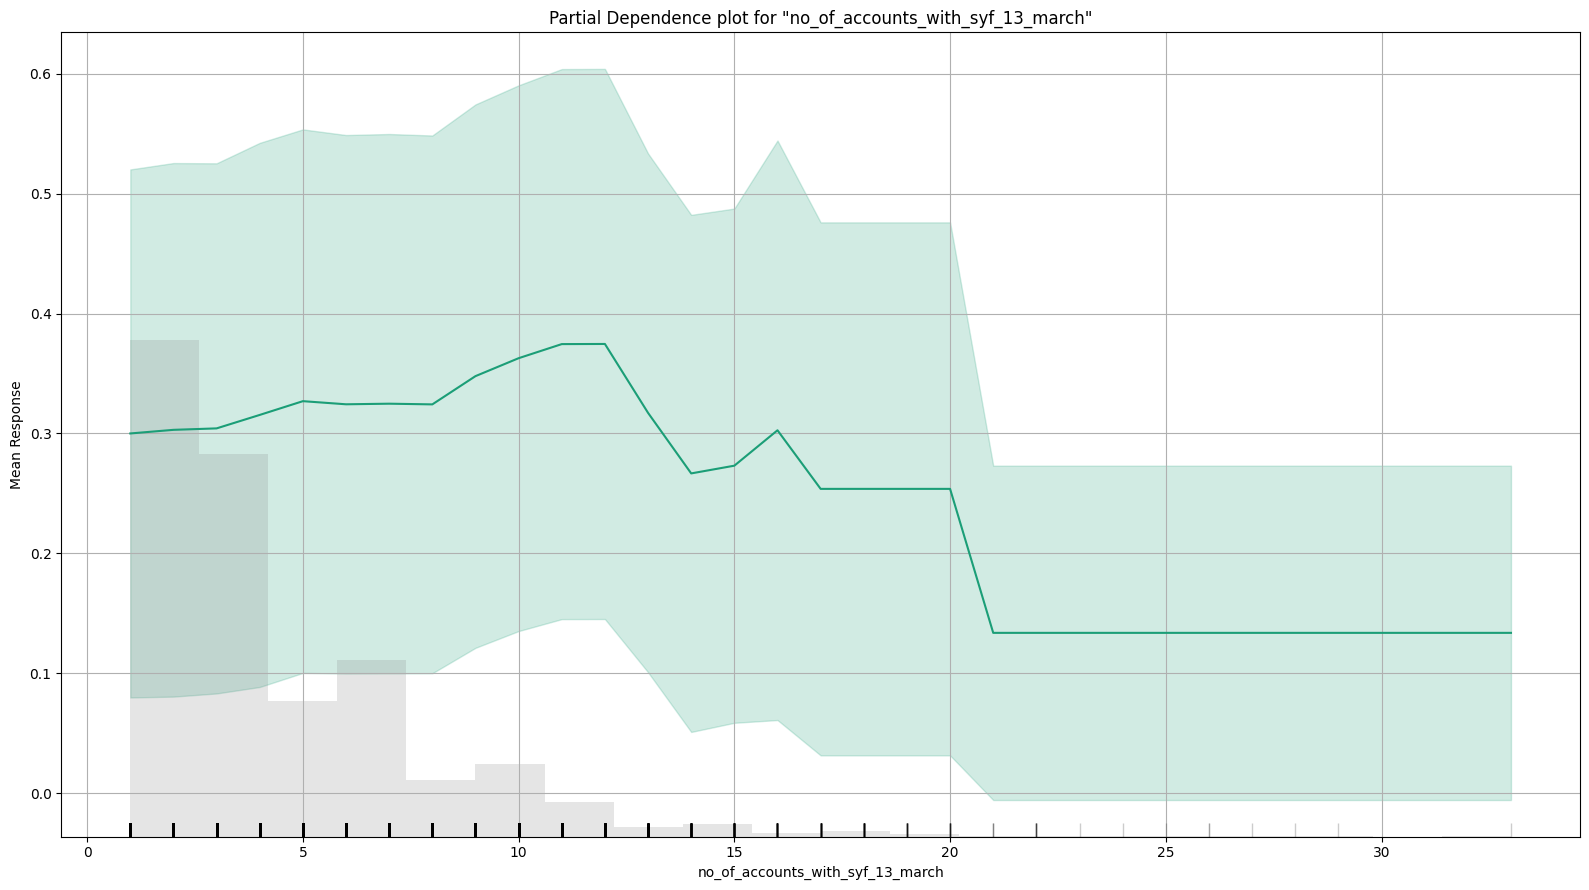



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada02cb3b80>), ('description', <h2o.explanation._explain.Description object at 0x7ada02cb3190>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711280219938_11318', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ad957537280>), ('plots', H2OExplanation([('XGBoost_model_python_1711280219938_11318', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6754186123609542', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7ada02d0bd90>), ('description', <h2o.explanation._explain.Description object at 0x7ad9575371c0>), ('plots', H2OExplanation([('XGBoost_model_python_1711280219938_11318', <h2o.plot._plot_result._MObject object at 0x7ada939f27a0>)]))])), ('varimp', H2OE

(Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711280219938_11318


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.11773269972980953
RMSE: 0.34312198957485884
LogLoss: 0.3772432829422445
Mean Per-Class Error: 0.17860133647330878
AUC: 0.9575114986014639
AUCPR: 0.6857636365044449
Gini: 0.9150229972029278

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6754186123609542
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     9159     378         0.0396   (378.0/9537.0)
resolved  235      505         0.3176   (235.0/740.0)
Total     9394     883         0.0596   (613.0/10277.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.675419     0.622304  67
max f

In [58]:
train_and_evaluate_model(auto_df, 'resolved', predictor, 'wa')

#### LS XGB

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [IA IC, reason, FI PP, AA RC, iO, VA wa, me mm, iP, HI mm, AP mm, iS, LW, iT, LS mm, RI mm, eS, eB mm, CT wa, HI IA, AA mt, DE wa, iS mm, HI LS, mP wa, eR mm, Ls, IA PS, PA mm, ER, IA LS, iA mm, PP PS, IA LW, DR PT, iP mm, AA PT, AA LW, Pd mm, VP, mo wa, AA iR, iT mm, FD, AA DP, AA CT, RV, IA SR, IC mm, NU, IA SP, eS mm, FR, RC mm, mp wa, GA wa, CD, eP mm, FM mm, HI PP, AA GA, eA mm, RP mm, NU mm, eL mm, CA mm, FM IA, VA mm, AA CB, IA NU, AA SP, CS, PP SP, PP SR, iA, DE mt, mm wa, CT mm, LW PI, mP mm, iR mm, eB, iF]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711252856962_133


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1640130497640594
RMSE: 0.40498524635356703
LogLoss: 0.49261133240795096
Mean Per-Class Error: 0.24327665791630787
AUC: 0.8456278857457519
AUCPR: 0.7356396003500972
Gini: 0.6912557714915037

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35838473193785725
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     4421     1782        0.2873   (1782.0/6203.0)
resolved  603      2423        0.1993   (603.0/3026.0)
Total     5024     4205        0.2584   (2385.0/9229.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric         

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711252856962_133

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35838473193785725
          floor    resolved    Error    Rate
--------  -------  ----------  -------  ---------------
floor     4421     1782        0.2873   (1782.0/6203.0)
resolved  603      2423        0.1993   (603.0/3026.0)
Total     5024     4205        0.2584   (2385.0/9229.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

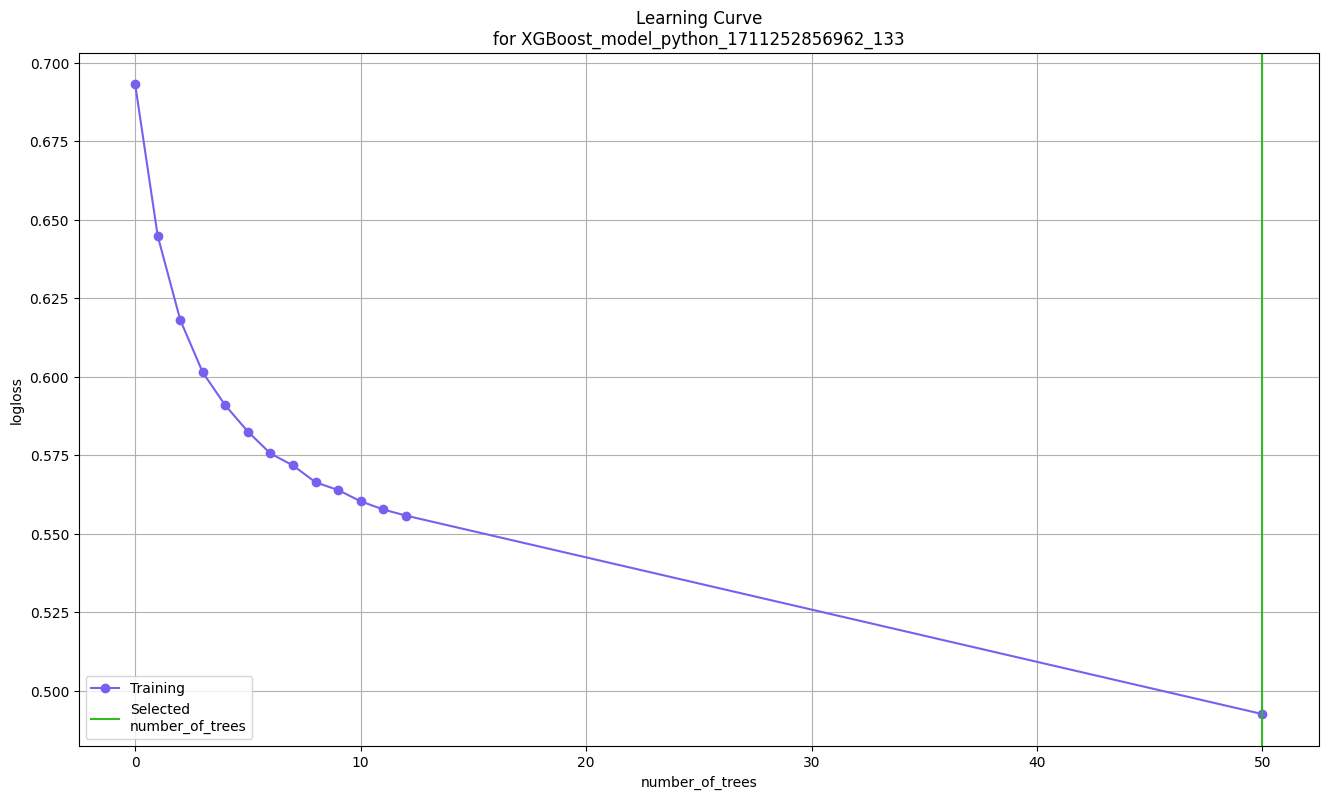

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

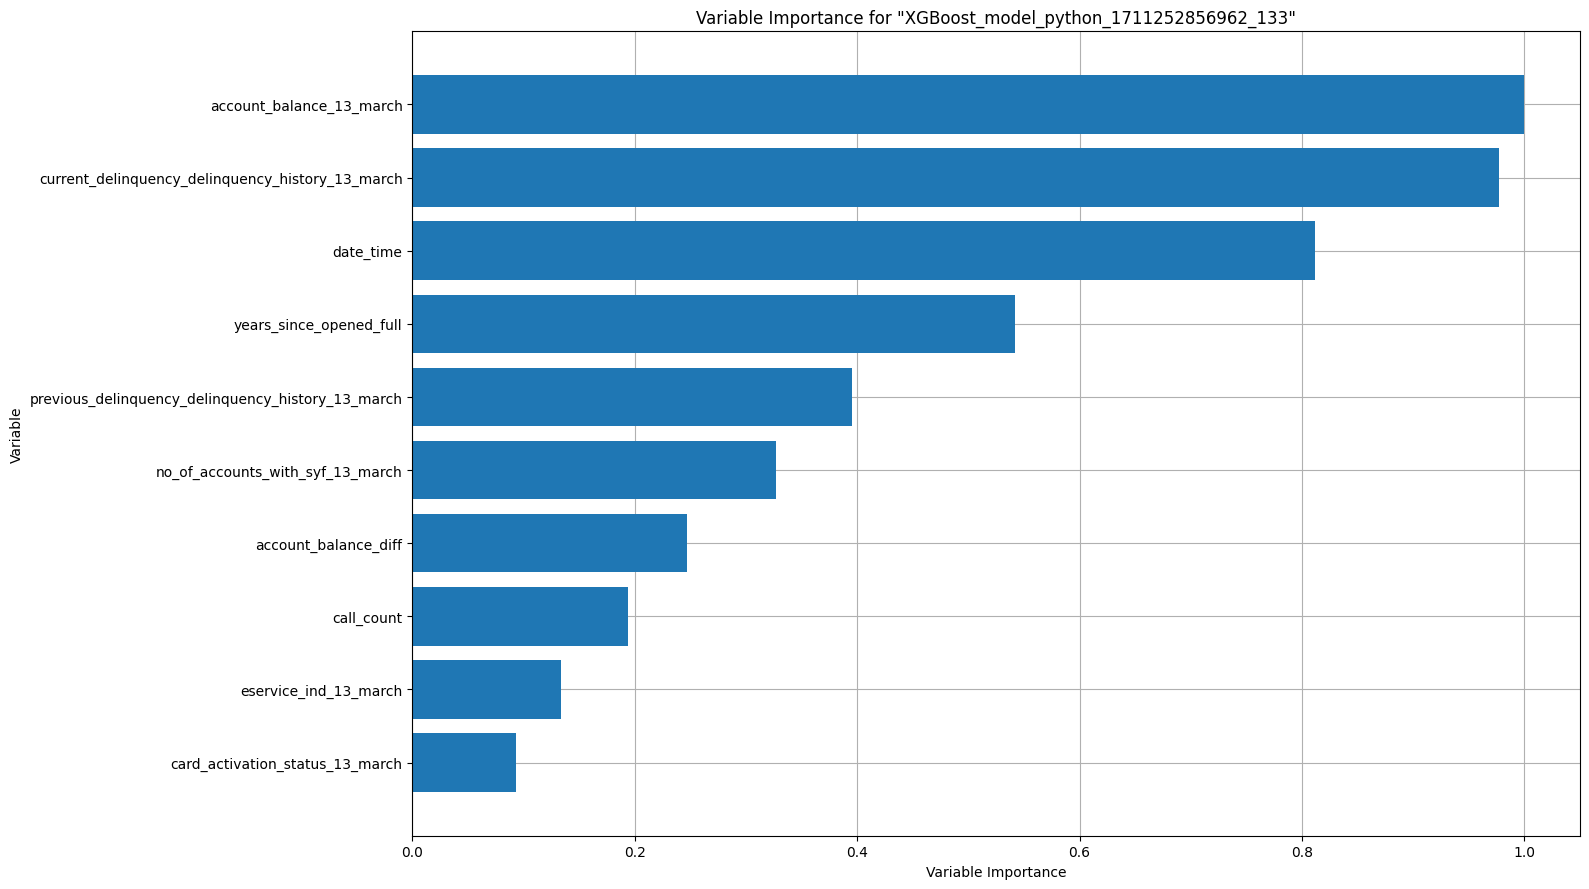

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

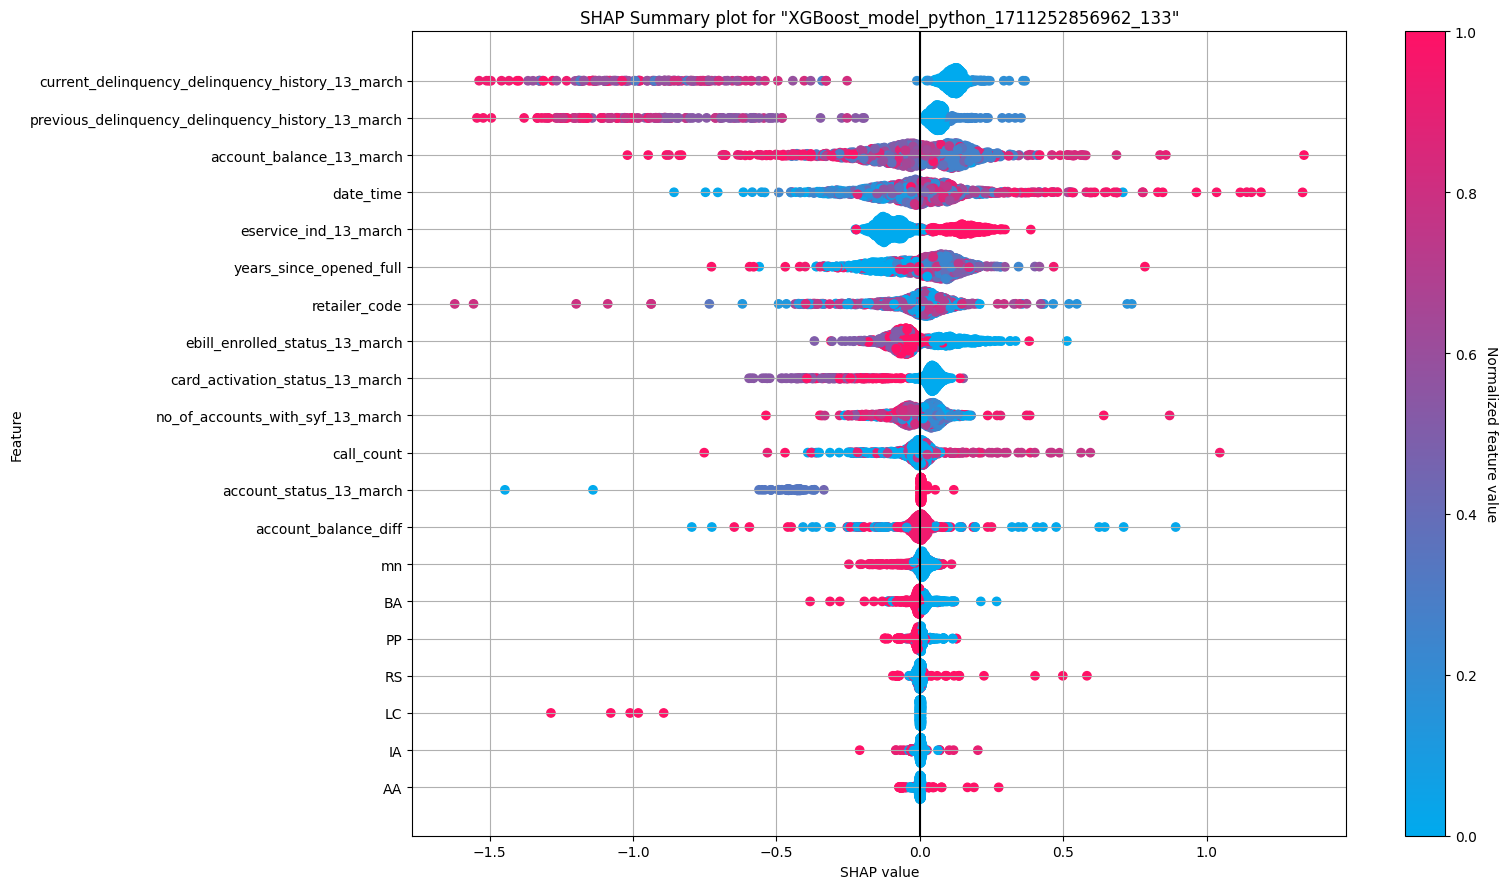

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

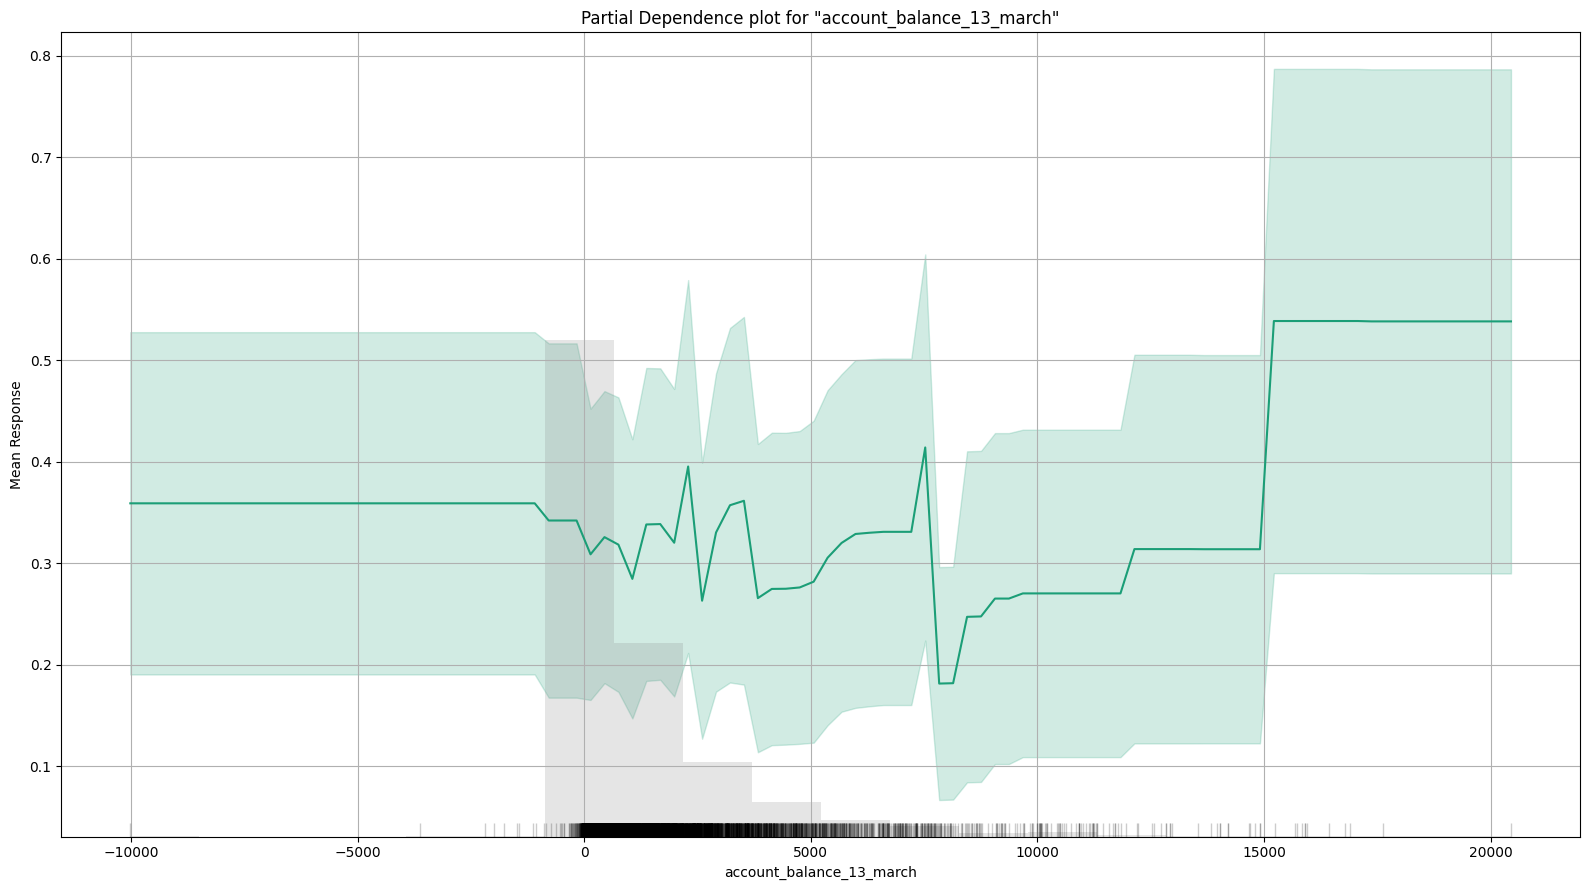

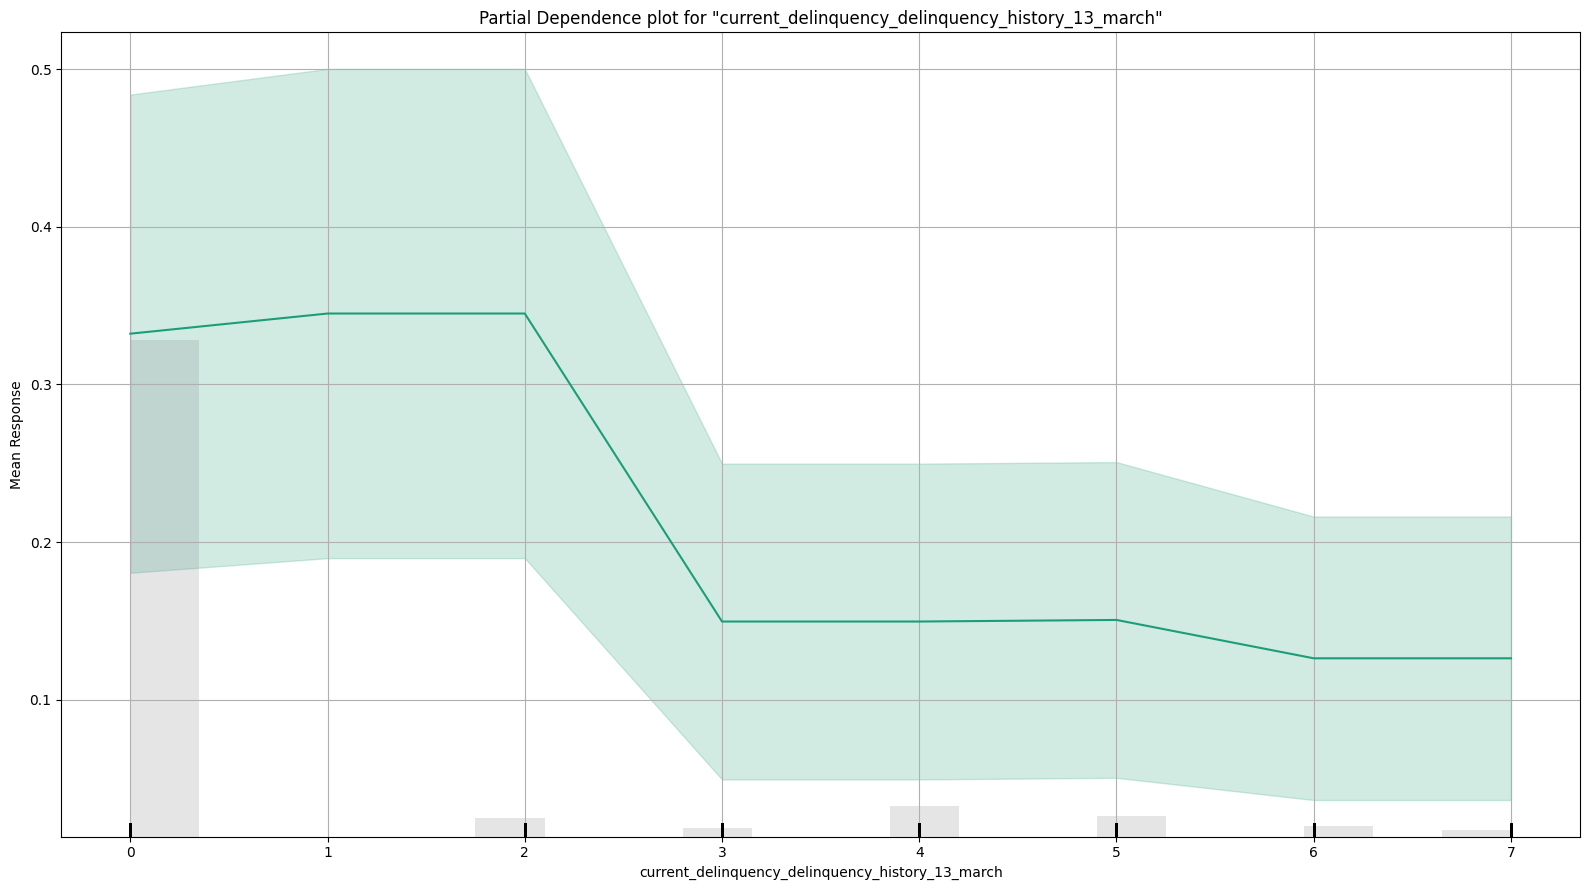

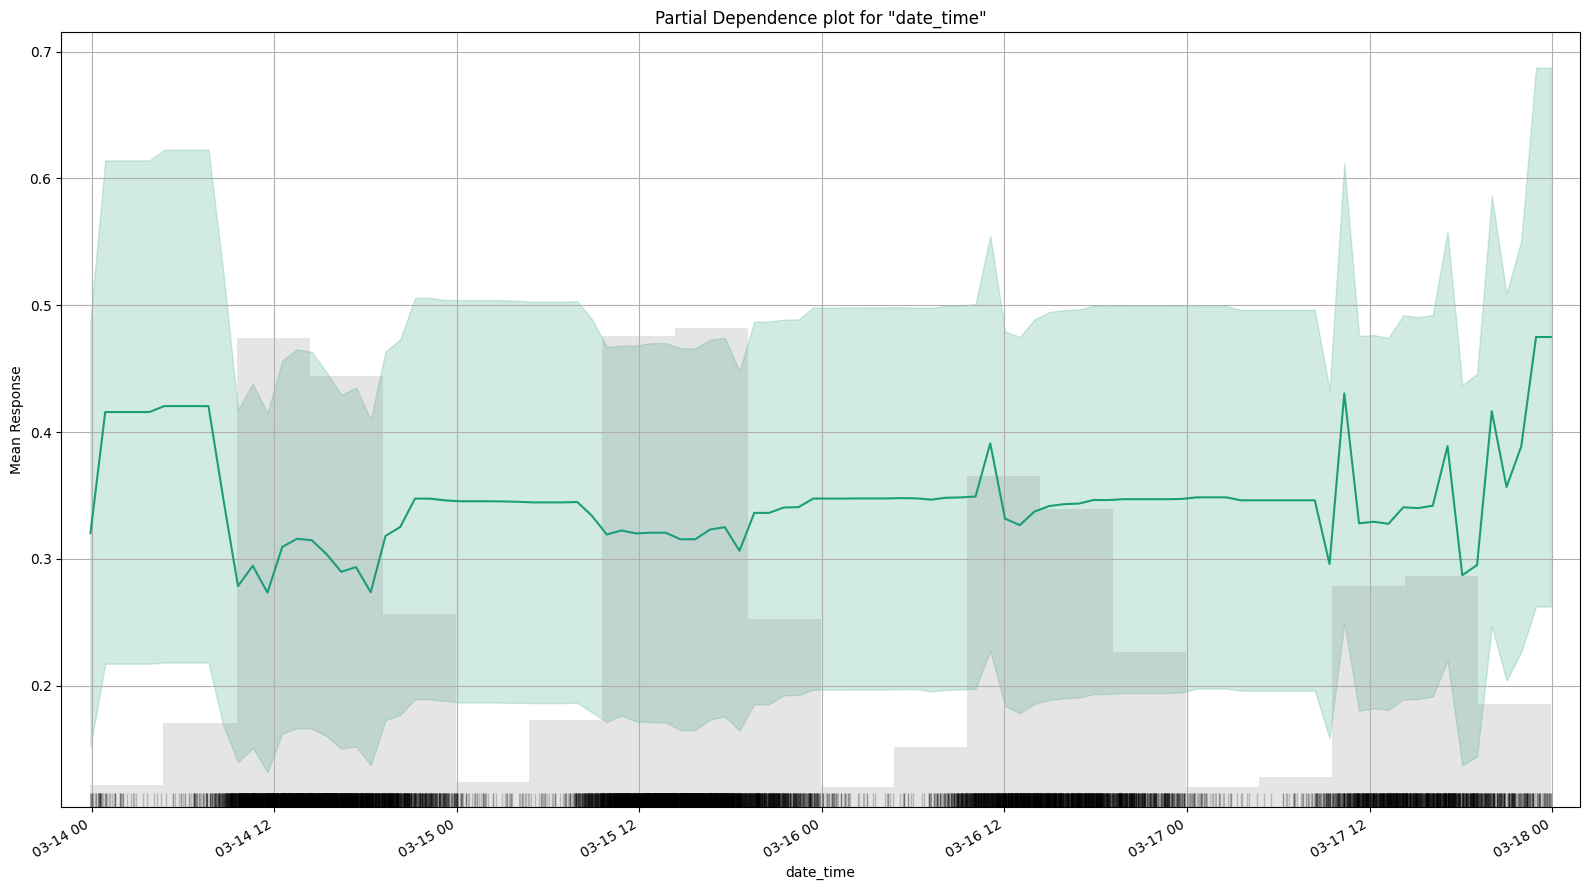

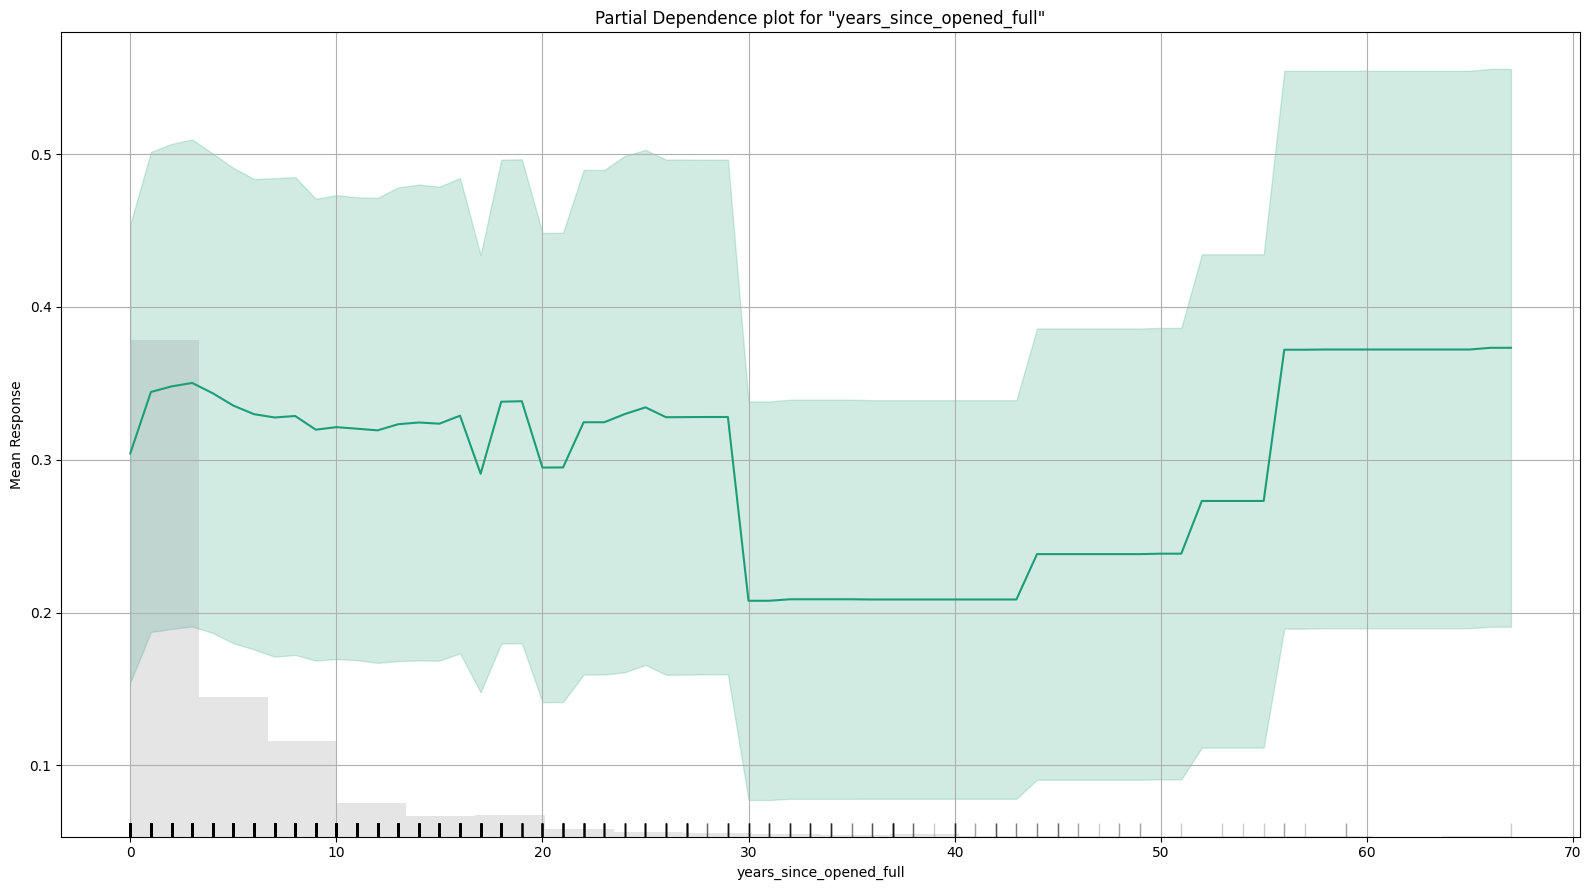

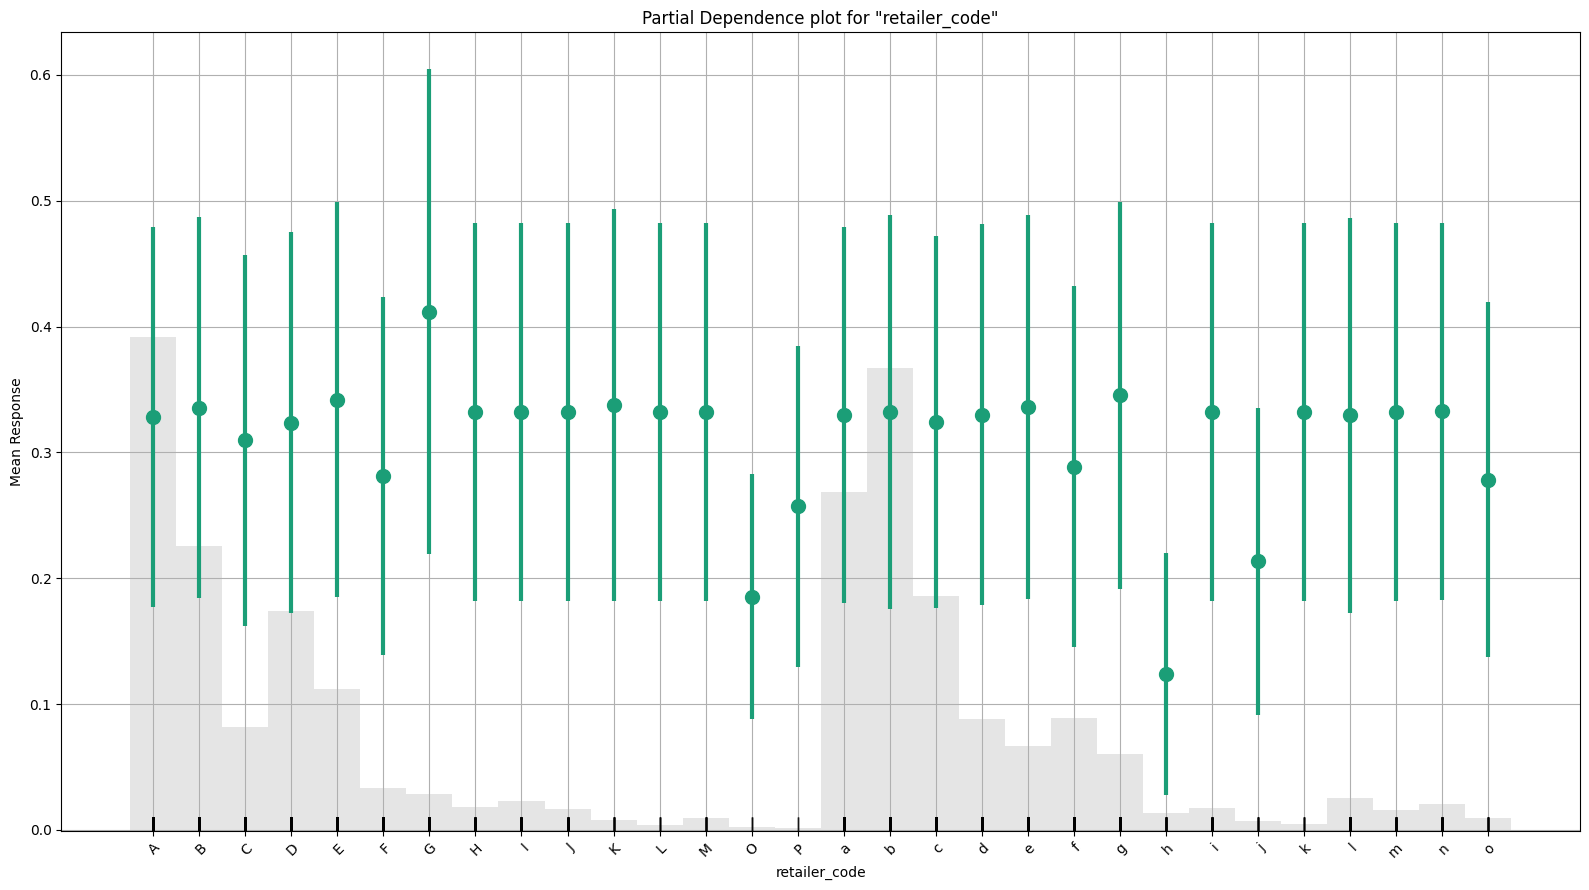



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7edc7de82710>), ('description', <h2o.explanation._explain.Description object at 0x7edc3506d8a0>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711252856962_133', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7edc3506f970>), ('plots', H2OExplanation([('XGBoost_model_python_1711252856962_133', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35838473193785725', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7edc3506cdf0>), ('description', <h2o.explanation._explain.Description object at 0x7edc855440d0>), ('plots', H2OExplanation([('XGBoost_model_python_1711252856962_133', <h2o.plot._plot_result._MObject object at 0x7edc9c8df3d0>)]))])), ('varimp', H2OExplan

In [ ]:
train_and_evaluate_model(auto_df, 'resolved', predictor, 'LS')

#### FD XGB

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


xgboost Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [IA IC, reason, FI PP, AA RC, iO, VA wa, me mm, iP, HI mm, iS, FI PI, LW, iT, LS mm, RI mm, eR, eS, eB mm, CT wa, HI IA, AA mm, eY mm, AA mt, DE wa, iS mm, HI LS, GA mm, mP wa, eR mm, Ls, IA PS, ER, IA LS, iA mm, PI mm, PP PS, IA LW, DR PT, iP mm, AA PT, SR mm, AA LW, Pd mm, VP, mo wa, AA iR, iT mm, FD, AA DP, AA CT, RV, IA SR, NU, IA SP, eS mm, FR, RC mm, mp wa, GA wa, iM mm, eP mm, FM mm, HI PP, AA GA, FI IA, eA mm, RP mm, NU mm, eL mm, CA mm, FM IA, VA mm, IA NU, AA SP, CS, PP SP, PP SR, mm wa, CT mm, LW PI, mP mm, eB, iF]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████| (done) 100%
xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_model_python_1711252856962_33


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.021352967681877107
RMSE: 0.14612654680747475
LogLoss: 0.08126690902085798
Mean Per-Class Error: 0.15727646235182294
AUC: 0.9819037475160861
AUCPR: 0.8268110554351583
Gini: 0.9638074950321722

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22320476671059927
          floor    resolved    Error    Rate
--------  -------  ----------  -------  --------------
floor     7876     42          0.0053   (42.0/7918.0)
resolved  107      239         0.3092   (107.0/346.0)
Total     7983     281         0.018    (149.0/8264.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric             

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_model_python_1711252856962_33

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22320476671059927
          floor    resolved    Error    Rate
--------  -------  ----------  -------  --------------
floor     7876     42          0.0053   (42.0/7918.0)
resolved  107      239         0.3092   (107.0/346.0)
Total     7983     281         0.018    (149.0/8264.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

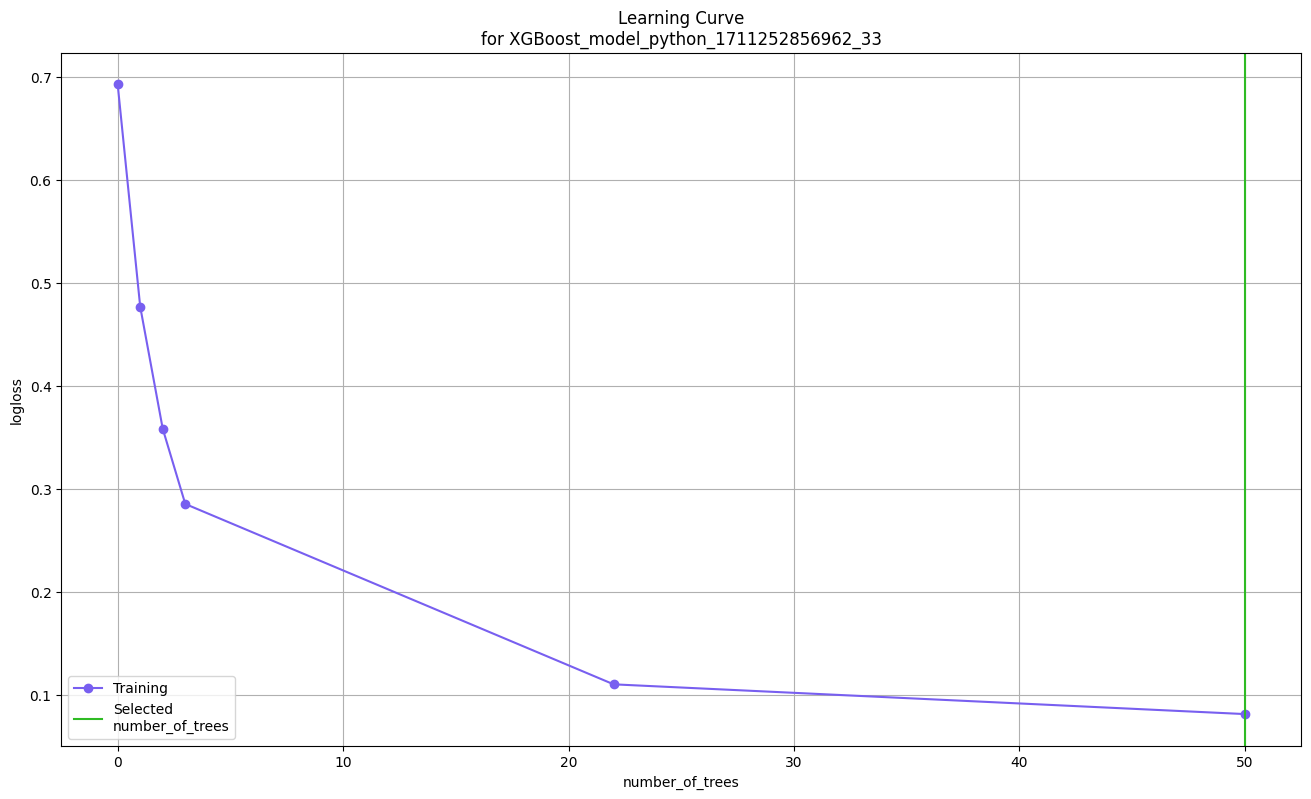

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

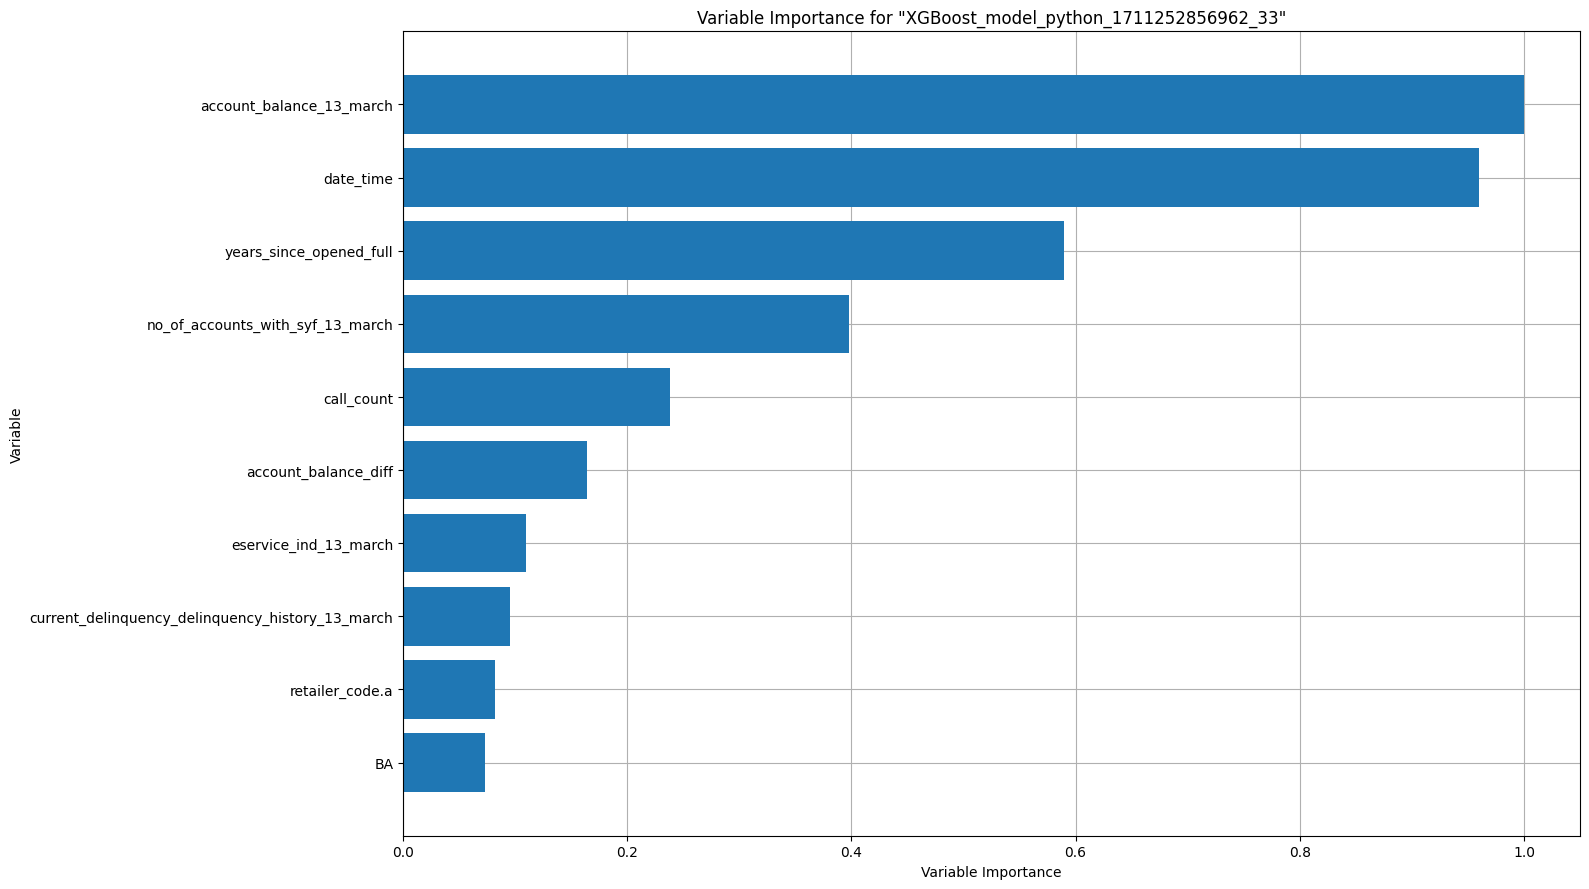

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

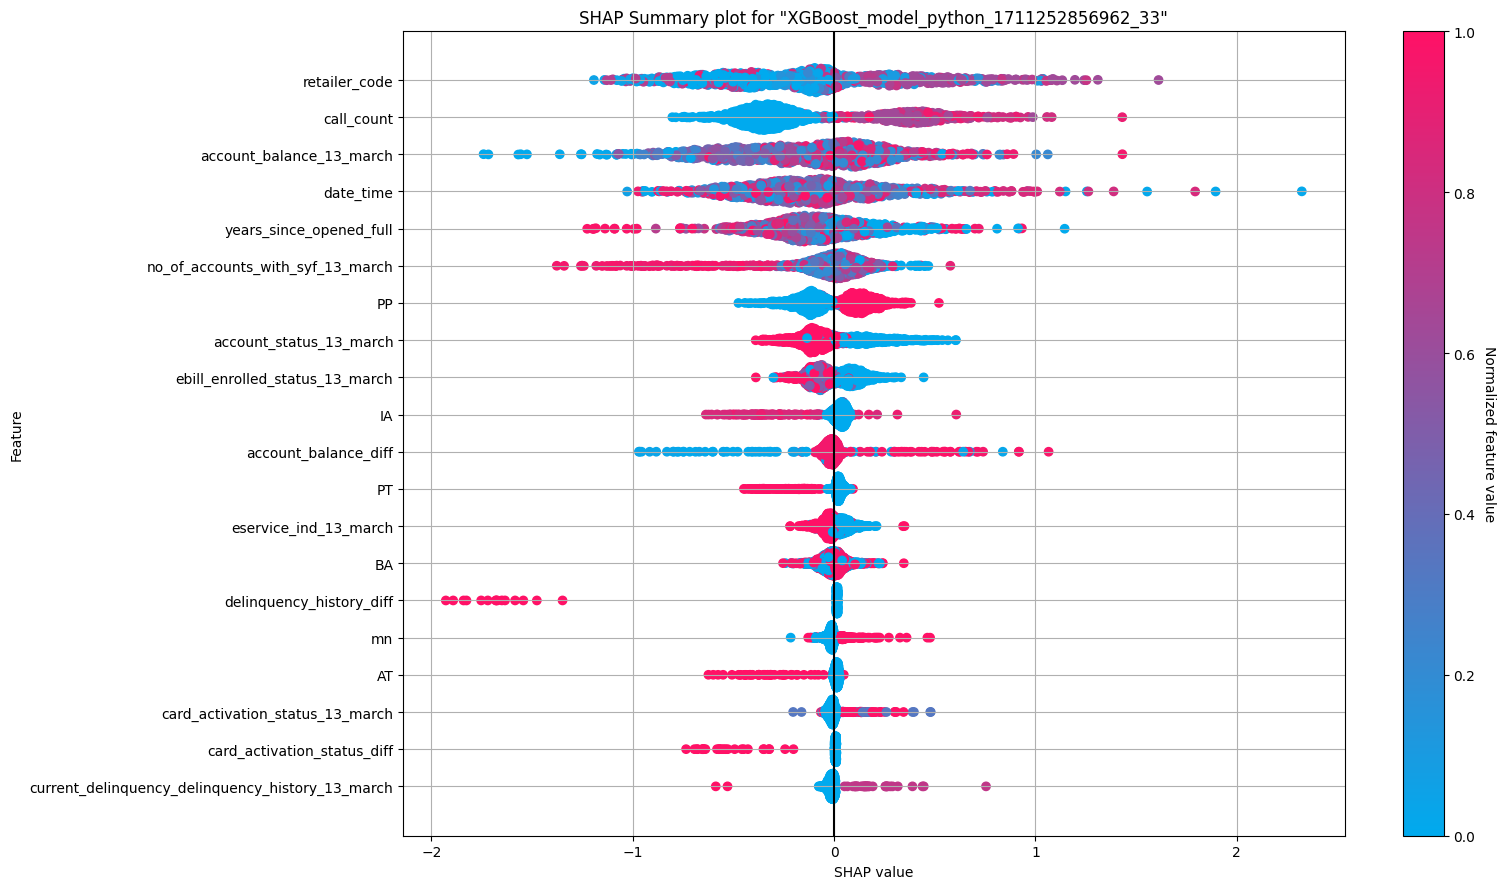

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

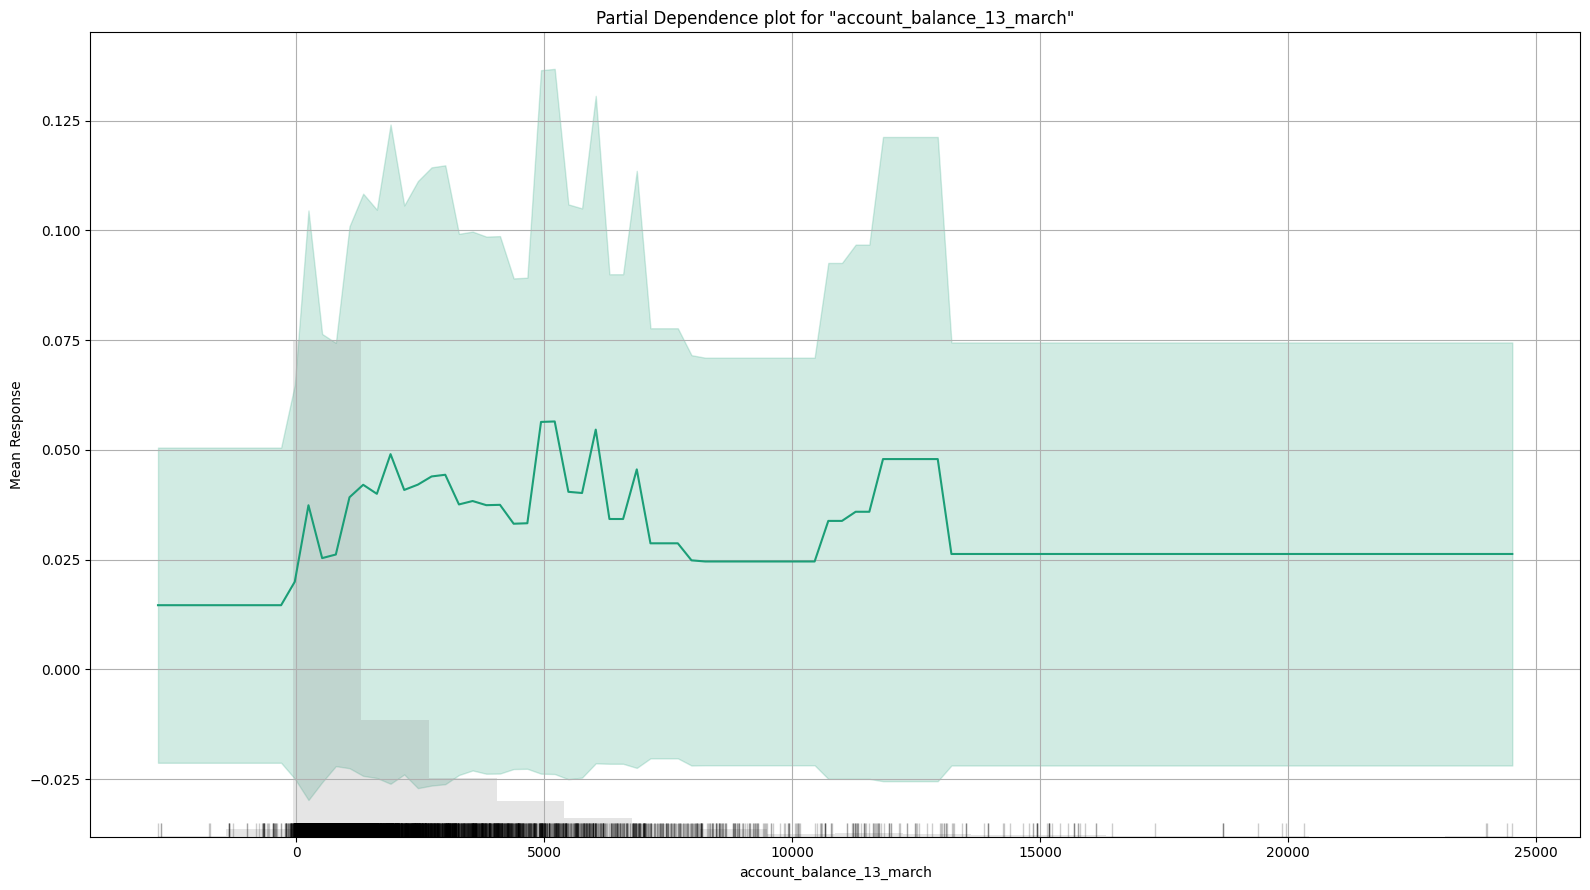

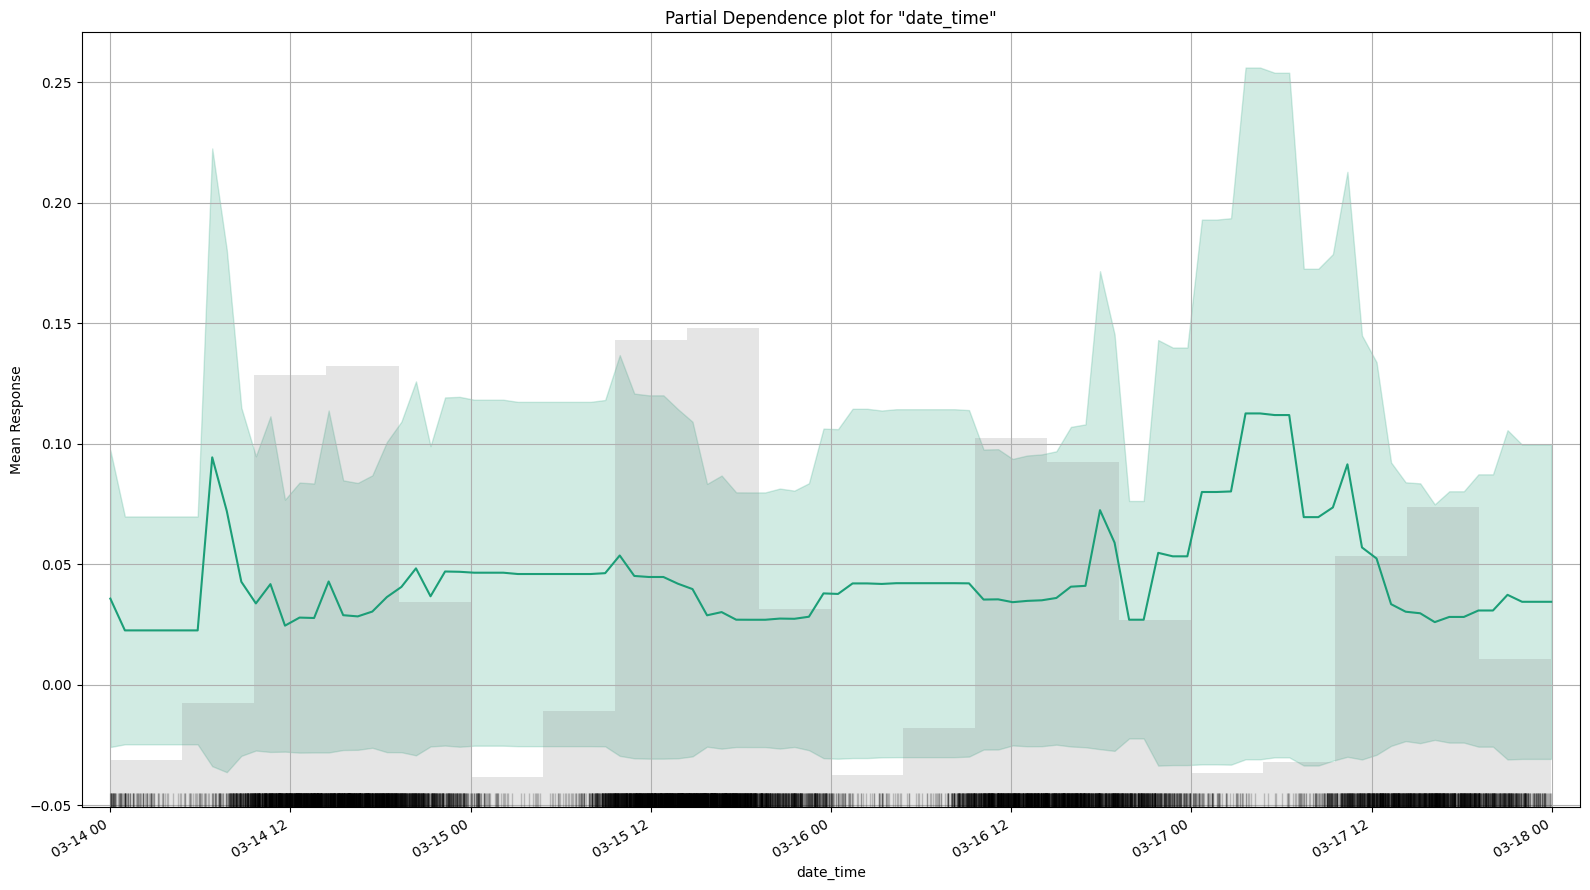

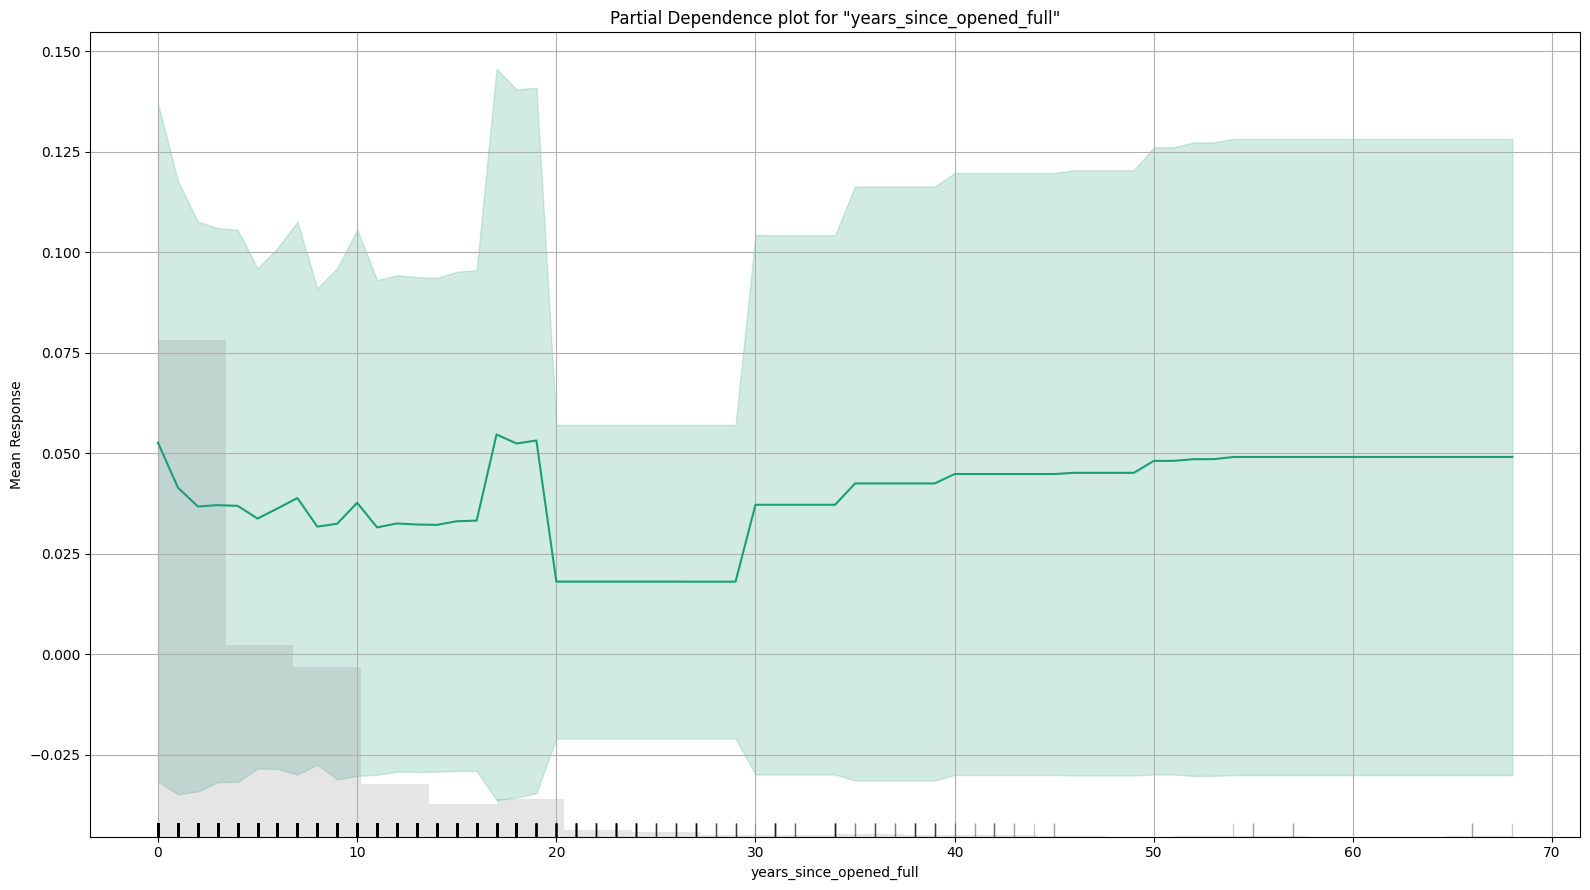

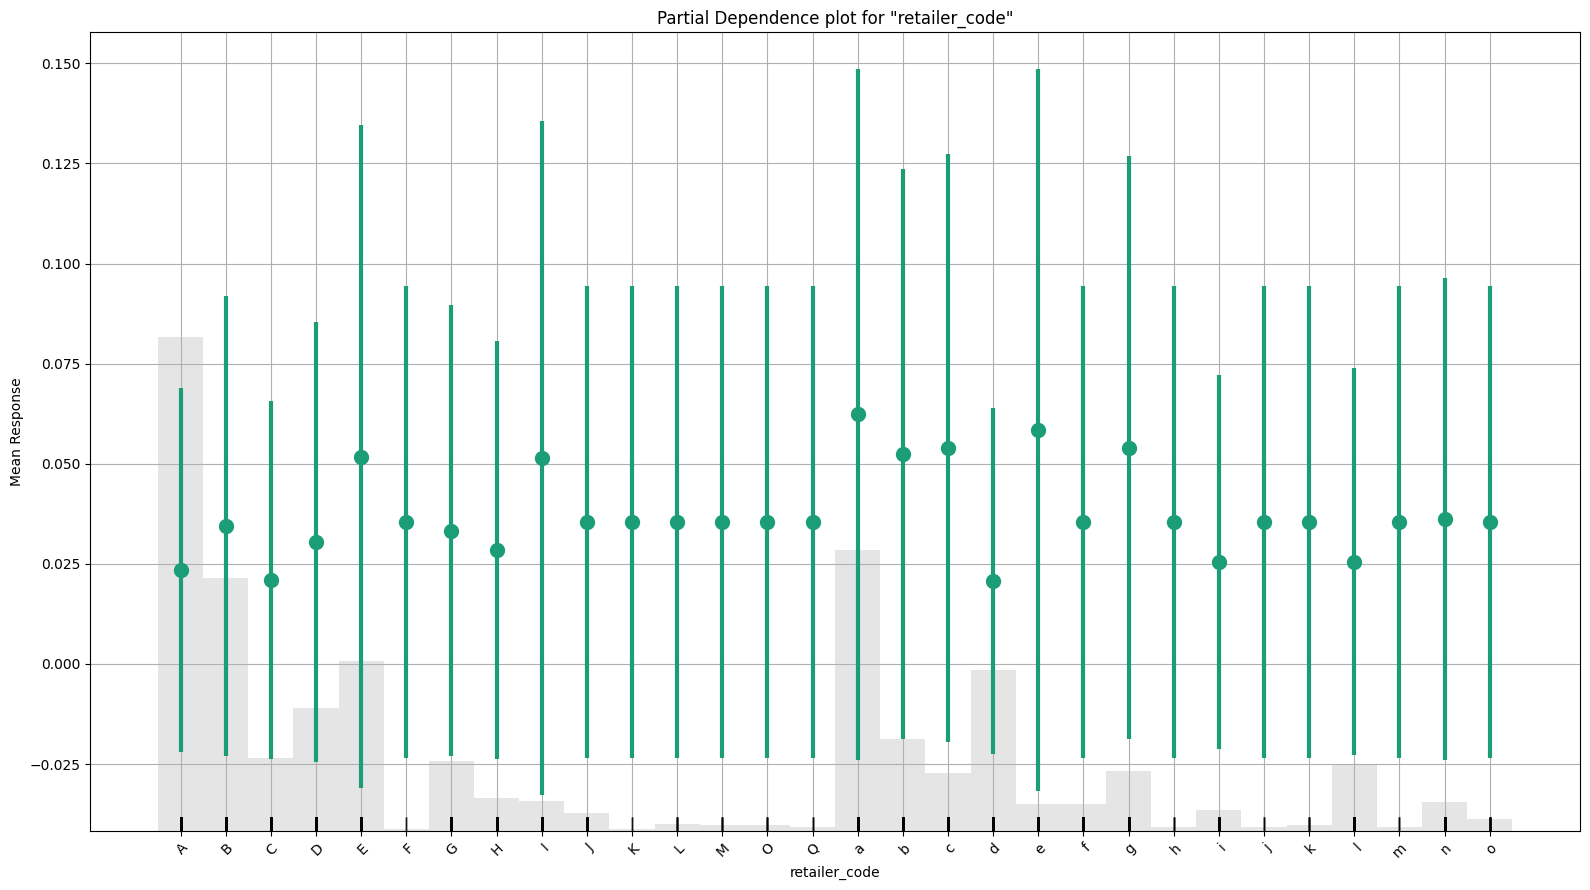

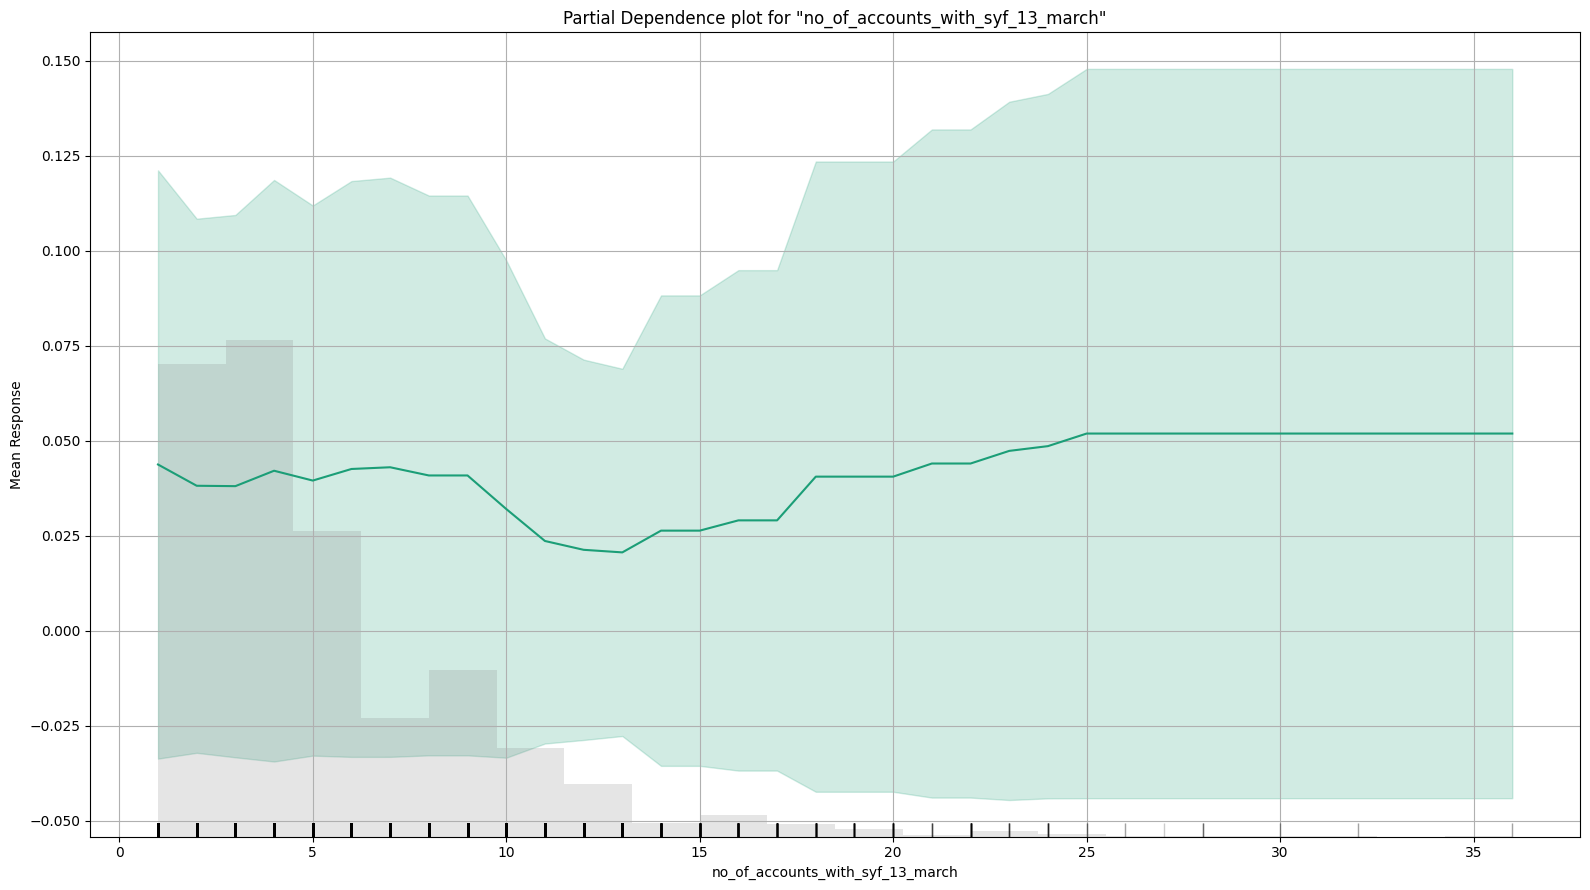



H2OExplanation([('confusion_matrix', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7edc9d7e6320>), ('description', <h2o.explanation._explain.Description object at 0x7edc9d7e6350>), ('subexplanations', H2OExplanation([('XGBoost_model_python_1711252856962_33', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7edc9d7e52a0>), ('plots', H2OExplanation([('XGBoost_model_python_1711252856962_33', ConfusionMatrix({'table': H2OTwoDimTable({'_table_header': 'Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22320476671059927', '_col_header': ['', 'floor', 'resolved', 'Error', 'Rate']})}))]))]))]))])), ('learning_curve', H2OExplanation([('header', <h2o.explanation._explain.Header object at 0x7edc9d7e7a90>), ('description', <h2o.explanation._explain.Description object at 0x7edc9d7e5ab0>), ('plots', H2OExplanation([('XGBoost_model_python_1711252856962_33', <h2o.plot._plot_result._MObject object at 0x7edc9d756260>)]))])), ('varimp', H2OExplanati

In [ ]:
train_and_evaluate_model(auto_df, 'resolved', predictor, 'FD')

## Beatiful Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your pandas DataFrame.
resolved_data = [data['resolved'] == 'resolved']
floor_data = data[data['resolved'] == 'floor']

# Extract the columns we're interested in
columns_to_compare = [
    'no_of_accounts_with_syf_13_march', 'account_balance_13_march', 'eservice_ind_13_march',
    'auto_pay_enrolled_status_13_march', 'no_of_accounts_with_syf_18_march', 'account_balance_18_march',
    'eservice_ind_18_march', 'auto_pay_enrolled_status_18_march', 'previous_delinquency_delinquency_history_13_march',
    'current_delinquency_delinquency_history_18_march', 'previous_delinquency_delinquency_history_18_march',
    'call_count', 'years_since_opened', 'years_since_opened_full', 'no_of_accounts_with_syf_diff',
    'account_balance_diff', 'eservice_ind_diff', 'auto_pay_enrolled_status_diff'
]

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Loop through the columns and create histograms for each.
for column in columns_to_compare:
  plt.figure(figsize=(12, 6))
  # Overlay the two histograms for comparison
  sns.histplot(resolved_data[column], color="blue", label='Resolved', kde=True, stat="density", common_norm=False)
  sns.histplot(floor_data[column], color="red", label='Floor', kde=True, stat="density", common_norm=False)

  plt.title(f'Distribution of {column} for Resolved vs. Floor')
  plt.xlabel(column)
  plt.ylabel('Density')
  plt.legend()

  # Show plot
  plt.show()

NameError: name 'data' is not defined